In [7]:
import pandas as pd
import pickle 
from os.path import join
from glob import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import matplotlib_setup
import ntpath


In [8]:
def get_cols4ml():
    return ['Dst Port', 'Protocol',
       'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']

In [9]:
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
markers = ['>','*','<','o','^']
LINEWIDTH = 12
MSIZE = 40
MEDGESIZE = 12
feature_names = get_cols4ml()[:-1]
feature_names = np.array(feature_names)
csv_gt = 'CSVs_r_1.0_m_1.0'
top_k = 5
N=20

In [10]:
def plot_importance(r_feature_names,r_importances,std, fn):
    matplotlib_setup(fontsize=35)
    
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(50,12))    
    plt.xticks(np.arange(N) ,r_feature_names[:N],rotation=30)
    plt.ylabel('Feature Rank (Importance)')
    ax.bar(range(N), r_importances[:N],
        color="r", yerr=std[:N], align="center")
    ax.grid(linewidth=3,axis='y', color='grey')
    ax.set_xlim([-1, N])
    fig.tight_layout()
    plt.savefig(fn)
    return plt

In [15]:
import numpy as np
def get_feature_rank_kfold(d):
    print(join(d,'10fold_*.pkl'))
    for fn in glob(join(d,'10fold_*.pkl')):
        print(fn)
        get_feature_rank(fn)
        
def get_feature_rank(fn):
    clf = pickle.load(open(fn,'rb'))
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    if 'noprint'=='print':
        # Print the feature ranking
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

    if csv_gt in fn:
        print(fn)
        plt = plot_importance(feature_names[indices],importances[indices],std[indices],\
                              fn.replace('.pkl','.png'))
        #plt.show()
    return feature_names[indices], importances[indices]


def read_top_k_cols(d, col_names, category='ALL'):
    col_names = np.append(col_names,'Label')
    return pd.concat([pd.read_csv(fn, usecols=col_names) for fn in glob(join(d,'10fold_0.csv'))], sort=False)

def read_top_k_cols_for_cat(d, col_names, category):
    col_names = np.append(col_names,'Label')
    df_list = []
    for fn in glob(join(d,'fold_0.csv')):
        df_i = pd.read_csv(fn, usecols=col_names)
        df_i = df_i[df_i['Label']==category]
        df_list.append(df_i)
    return pd.concat(df_list, sort=False)
    

In [12]:
csv_dirs = ['CSVs_r_1.0_m_1.0', 'CSVs_r_0.1_m_1.0', 'CSVs_r_0.01_m_1.0', 'CSVs_r_0.001_m_1.0']
clf_path = 'c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25/log/10fold_0.pkl'

def plot_feature_trend_for_sampler(sampler_dir):
    names, importance = get_feature_rank(join(sampler_dir,clf_path))
    
    df_trend = [read_top_k_cols(sampler_dir.replace(csv_gt, csv_dir),names[:top_k]) for csv_dir in csv_dirs]
    print('-------{}--------'.format(sampler_dir))
    for category in tqdm(df_trend[0].Label.unique()):
        if category=='Benign':
            continue
        df_trend_for_cat = [read_top_k_cols_for_cat(sampler_dir.replace(csv_gt, csv_dir),names[:top_k], category)\
                    for csv_dir in csv_dirs]
        means = [df_i.mean() for df_i in df_trend_for_cat]
        stds = [df_i.std() for df_i in df_trend_for_cat]
        
        matplotlib_setup(fontsize=35)
        fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(25,12))
        ax.grid(linewidth=3,axis='y', color='grey')
        xtick_labels = ['100%','10%','1%','0.1%']#,'5%','1%','0.5','0.1%']
        xtick_indices = np.arange(len(xtick_labels))
        for feature_name in names[:top_k]:
            means_for_cat = [ms[feature_name] for ms in means]
            stds_for_cat = [std_per_FC[feature_name] for std_per_FC in stds]
            
            ax.errorbar(np.arange(4),means_for_cat,yerr=stds_for_cat, label= feature_name,\
                        linewidth=LINEWIDTH,markersize=MSIZE,\
                markeredgewidth=MEDGESIZE,markerfacecolor='none', alpha=0.7)
            
        plt.xticks(xtick_indices,xtick_labels)
        plt.ylabel('Feature Value (mean)')
        sampler_name = ntpath.basename(sampler_dir)[:3]
        plt.xlabel('{} / {}: Flow Cache size (100% is ideal size for WS)'.format(sampler_name, category))
        plt.ylim([-1,1.6])
        plt.legend(ncol=3)
        
        outfile = 'top_k_feature_trend_across_FC_{}.png'.format(category)
        plt.savefig(join(sampler_dir,outfile))
        #plt.show()


In [ ]:
csv_dirs = ['CSVs_r_1.0_m_1.0', 'CSVs_r_0.1_m_1.0', 'CSVs_r_0.01_m_1.0', 'CSVs_r_0.001_m_1.0']
clf_path = 'c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25/log/10fold_0.pkl'

def plot_feature_trend_for_sampler_per_flow(sampler_dir):
    names, importance = get_feature_rank(join(sampler_dir,clf_path))
    
    df_trend = [read_top_k_cols(sampler_dir.replace(csv_gt, csv_dir),names[:top_k]) for csv_dir in csv_dirs]
    print('-------{}--------'.format(sampler_dir))
    for category in tqdm(df_trend[0].Label.unique()):
        if category=='Benign':
            continue
        df_trend_for_cat = [read_top_k_cols_for_cat(sampler_dir.replace(csv_gt, csv_dir),names[:top_k], category)\
                    for csv_dir in csv_dirs]
        means = [df_i.mean() for df_i in df_trend_for_cat]
        stds = [df_i.std() for df_i in df_trend_for_cat]
        
        matplotlib_setup(fontsize=35)
        fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(25,12))
        ax.grid(linewidth=3,axis='y', color='grey')
        xtick_labels = ['100%','10%','1%','0.1%']#,'5%','1%','0.5','0.1%']
        xtick_indices = np.arange(len(xtick_labels))
        for feature_name in names[:top_k]:
            means_for_cat = [ms[feature_name] for ms in means]
            stds_for_cat = [std_per_FC[feature_name] for std_per_FC in stds]
            
            ax.errorbar(np.arange(4),means_for_cat,yerr=stds_for_cat, label= feature_name,\
                        linewidth=LINEWIDTH,markersize=MSIZE,\
                markeredgewidth=MEDGESIZE,markerfacecolor='none', alpha=0.7)
            
        plt.xticks(xtick_indices,xtick_labels)
        plt.ylabel('Feature Value (mean)')
        sampler_name = ntpath.basename(sampler_dir)[:3]
        plt.xlabel('{} / {}: Flow Cache size (100% is ideal size for WS)'.format(sampler_name, category))
        plt.ylim([-1,1.6])
        plt.legend(ncol=3)
        
        outfile = 'top_k_feature_trend_across_FC_{}.png'.format(category)
        plt.savefig(join(sampler_dir,outfile))
        #plt.show()


/data/juma/.local/lib/python3.5/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/data/juma/.local/lib/python3.5/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_0.1/FFS_(8,16,400)_l/c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25/log/10fold_0.pkl


  0%|          | 0/12 [00:00<?, ?it/s]

-------/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_0.1/FFS_(8,16,400)_l--------


100%|██████████| 12/12 [00:22<00:00,  1.89s/it]


/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_0.1/SFS_SI_685.08_l/c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25/log/10fold_0.pkl


  0%|          | 0/9 [00:00<?, ?it/s]

-------/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_0.1/SFS_SI_685.08_l--------


 67%|██████▋   | 6/9 [00:11<00:05,  1.69s/it]/data/juma/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_0.1/SGS_e_11.5_l/c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25/log/10fold_0.pkl


  0%|          | 0/11 [00:00<?, ?it/s]

-------/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_0.1/SGS_e_11.5_l--------


100%|██████████| 11/11 [00:23<00:00,  2.17s/it]


/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_0.1/SRS_SI_1000_l/c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25/log/10fold_0.pkl


  0%|          | 0/12 [00:00<?, ?it/s]

-------/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_0.1/SRS_SI_1000_l--------


100%|██████████| 12/12 [00:18<00:00,  1.53s/it]


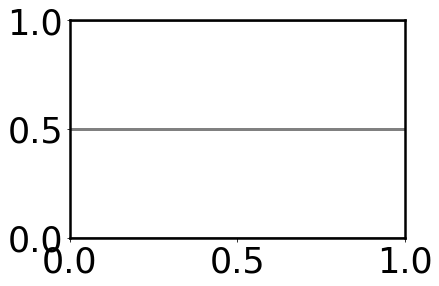

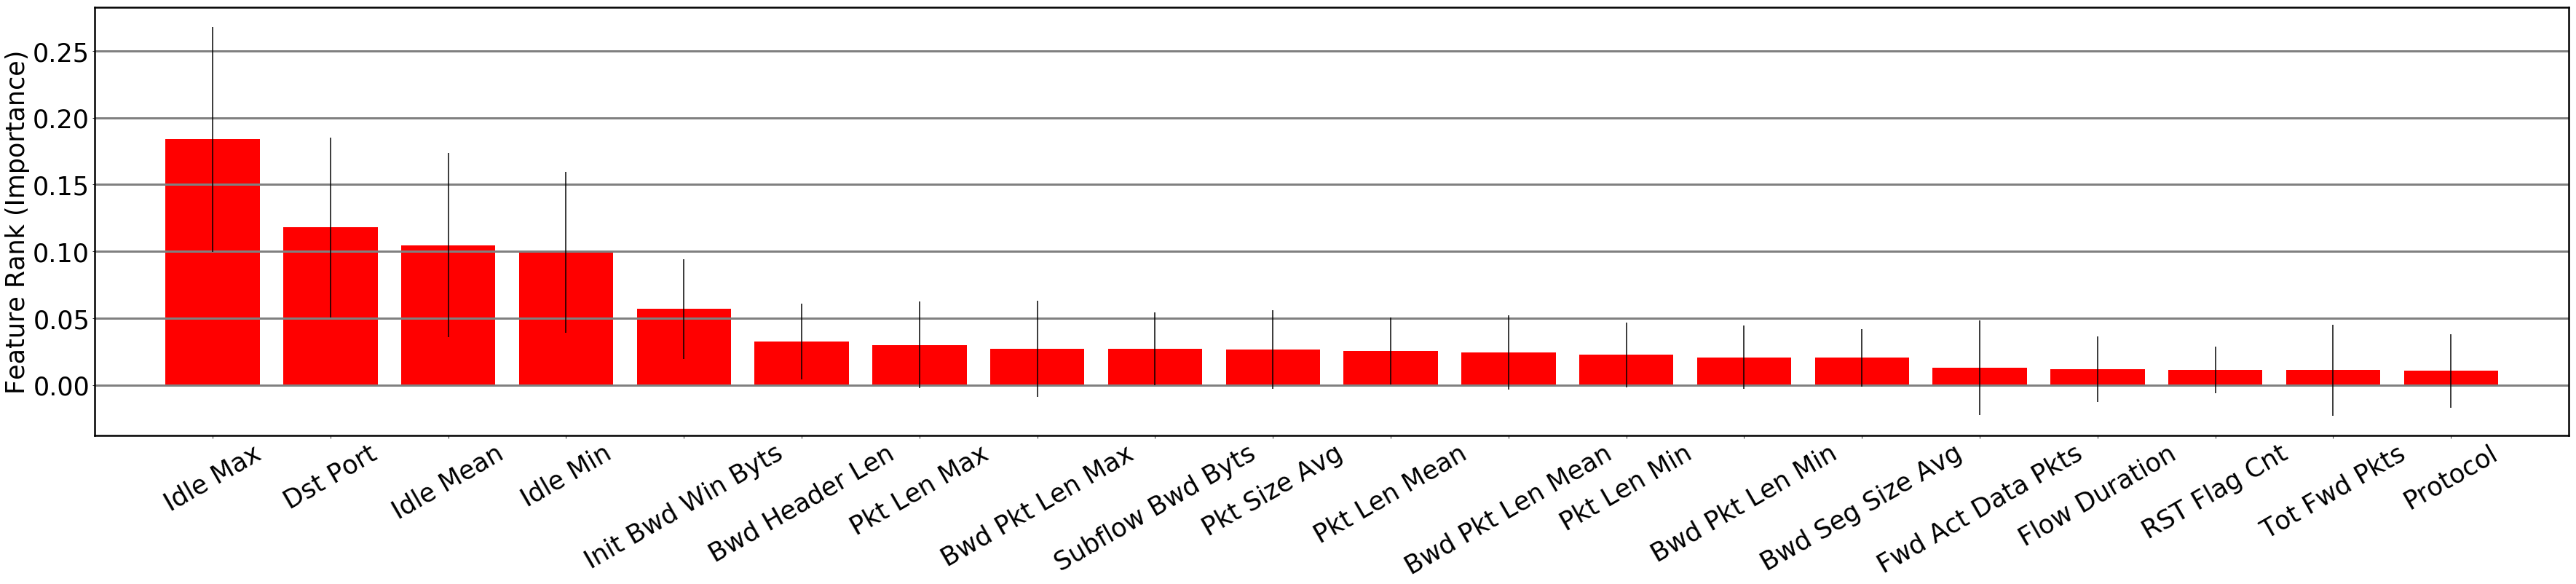

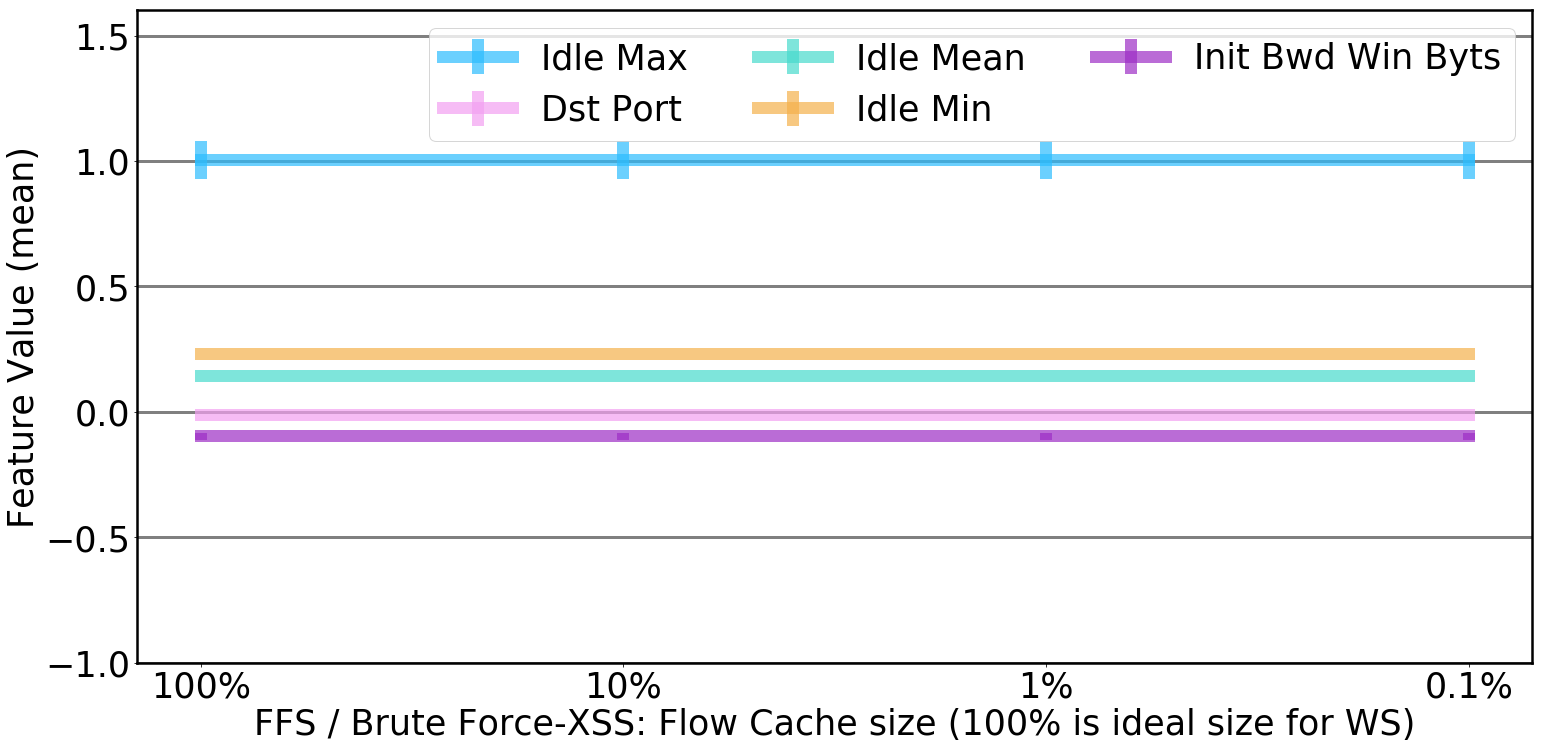

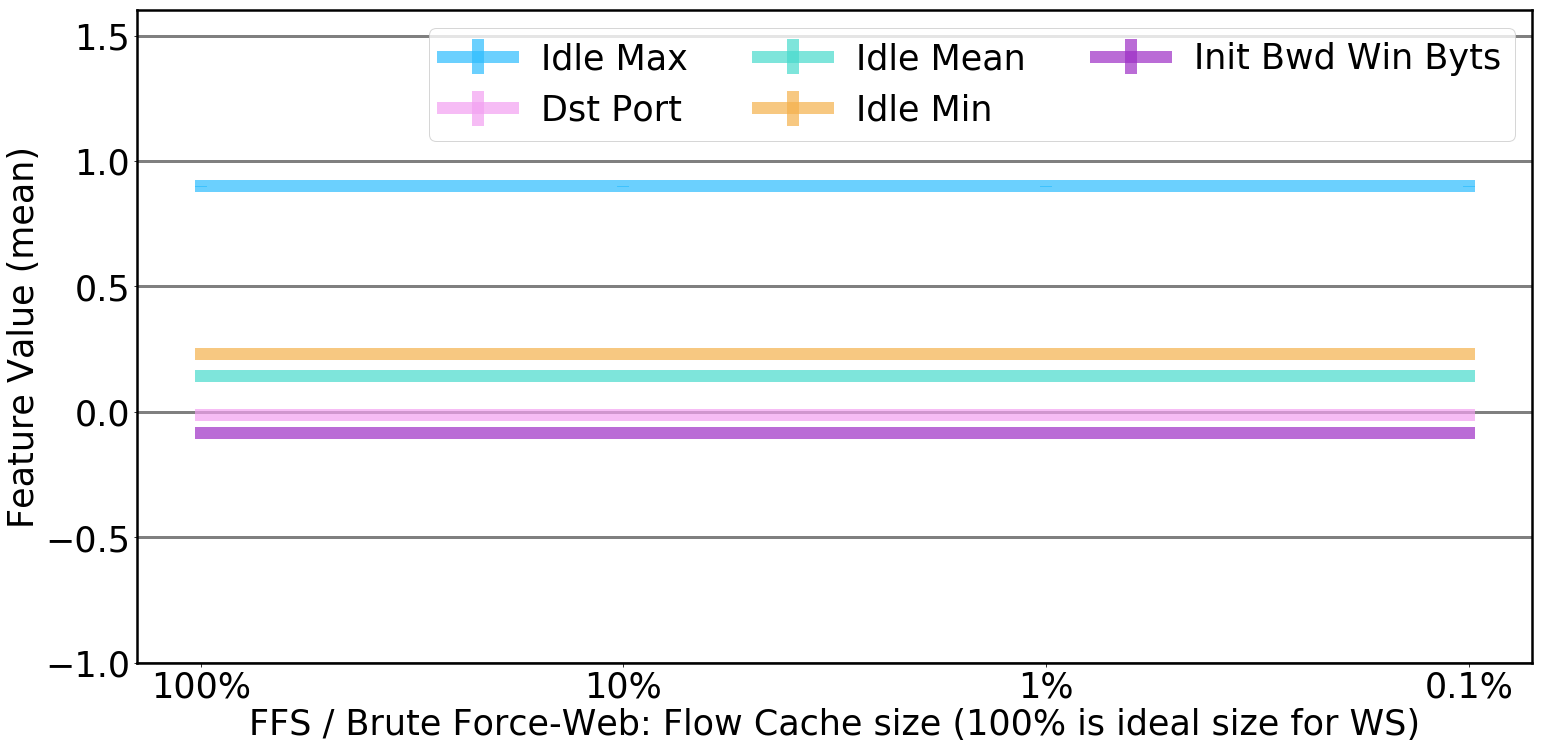

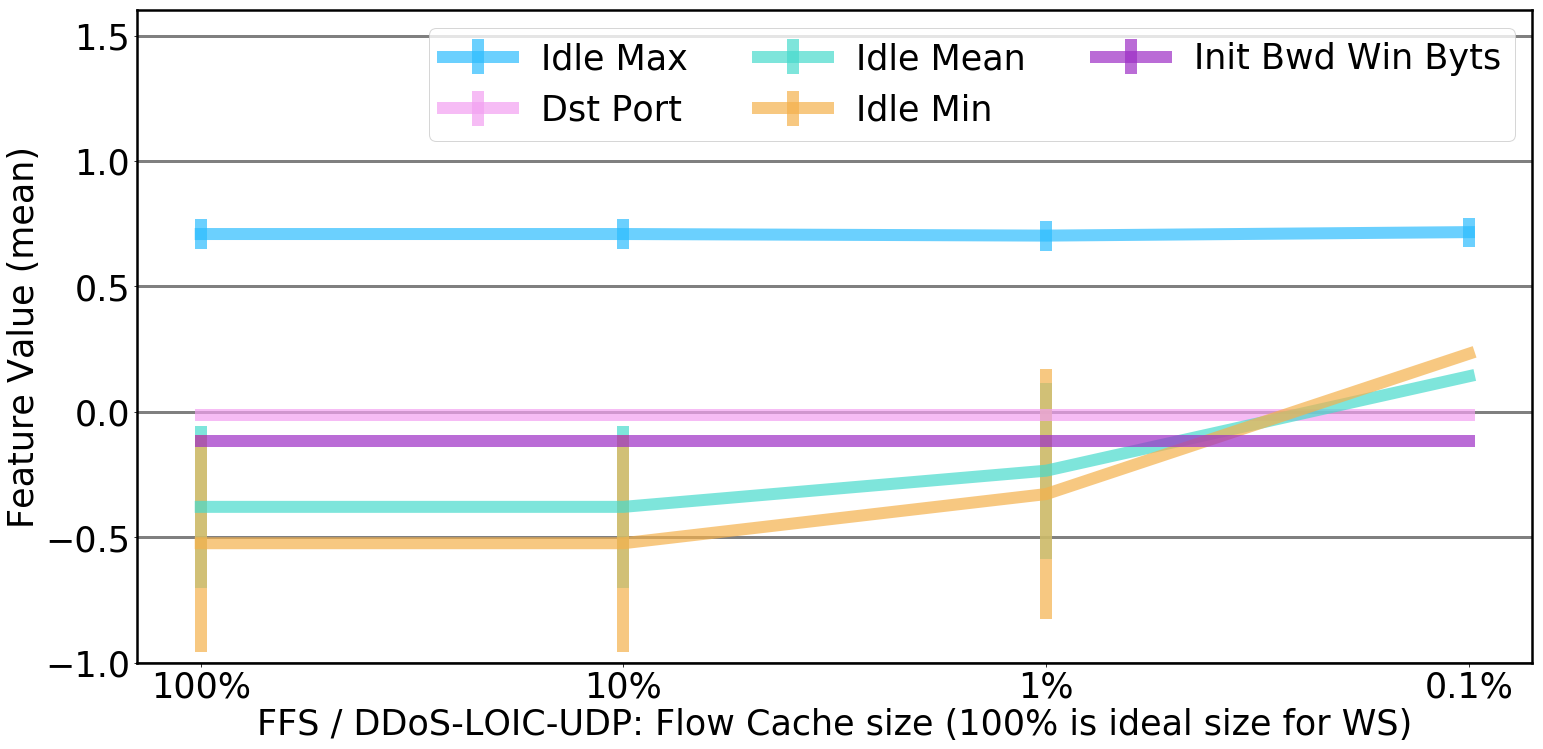

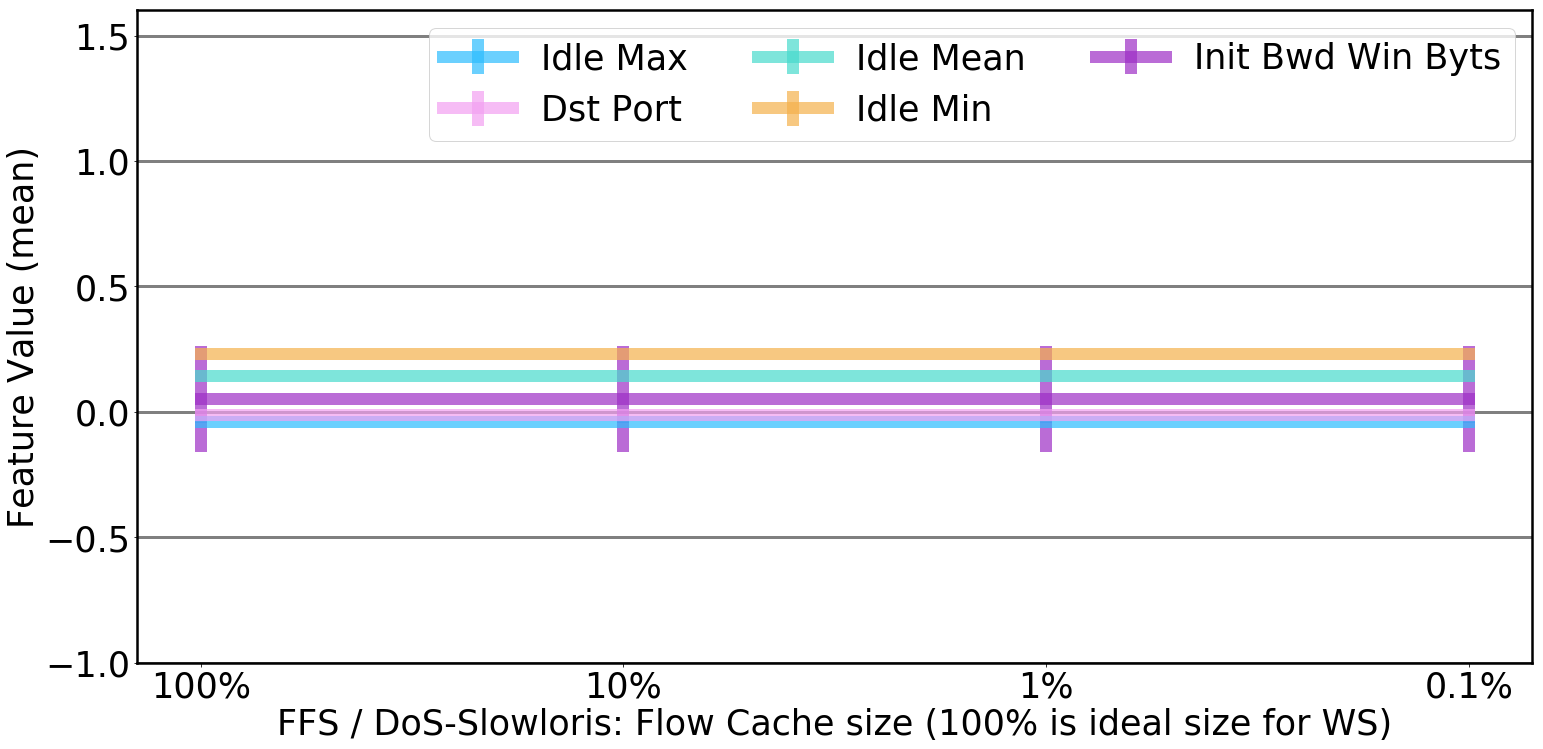

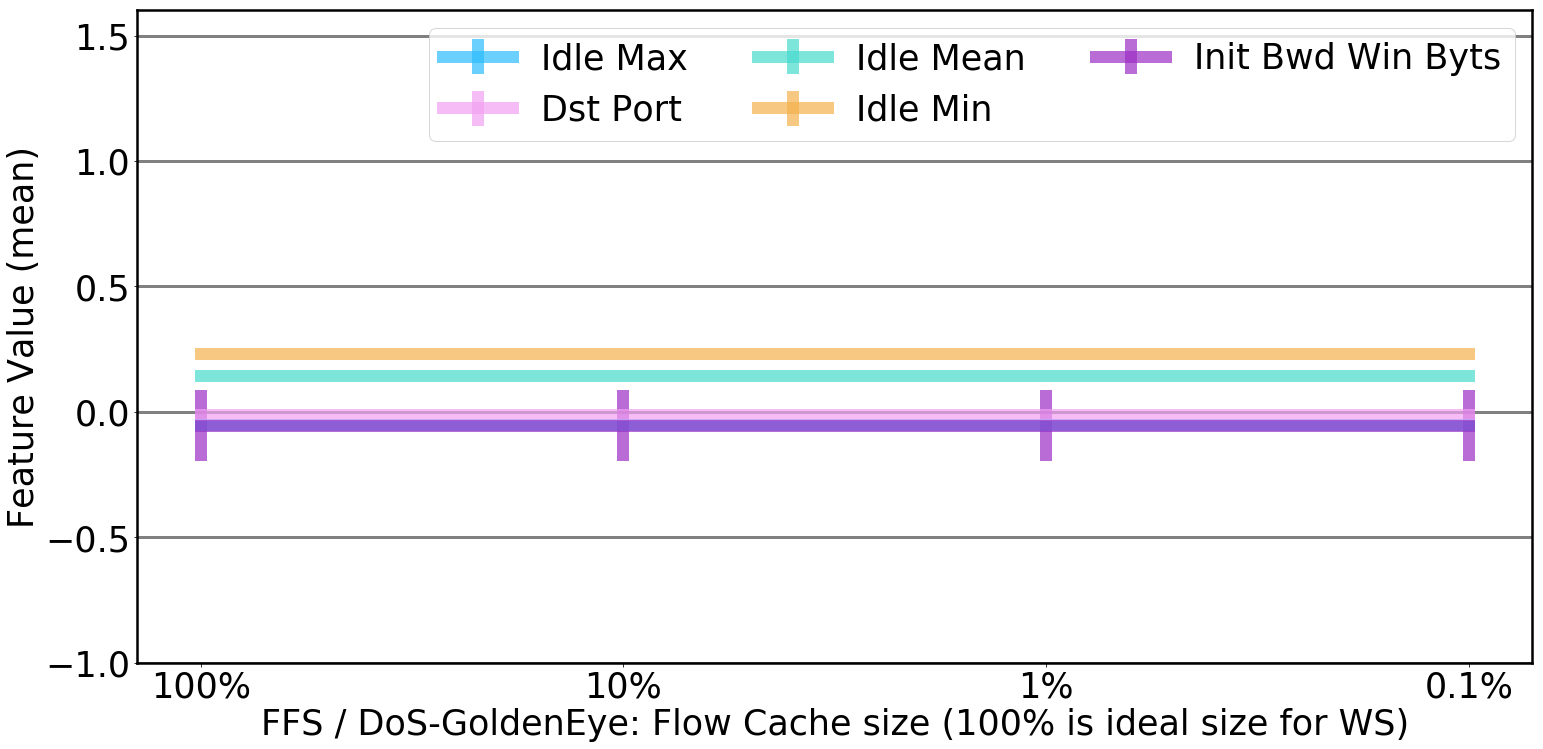

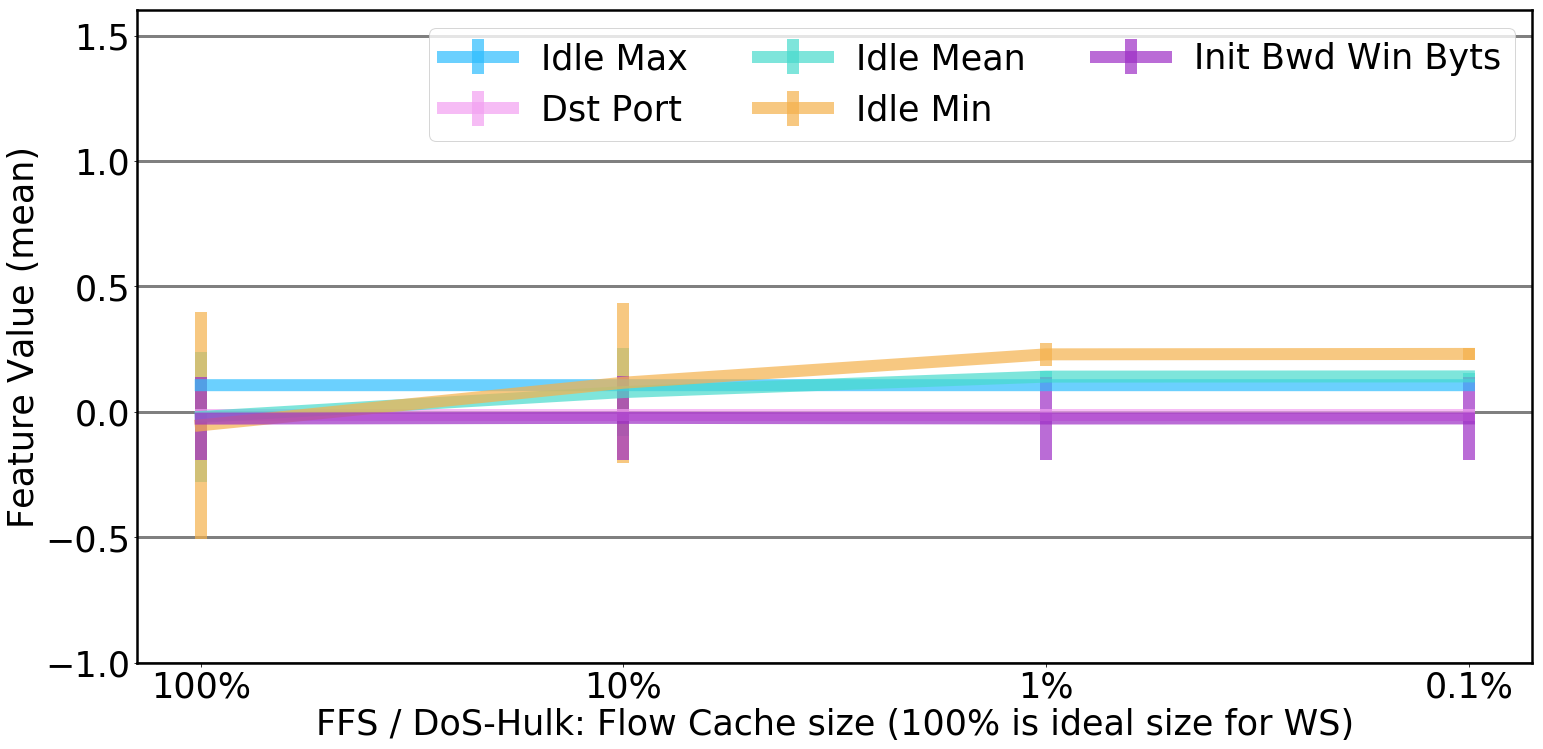

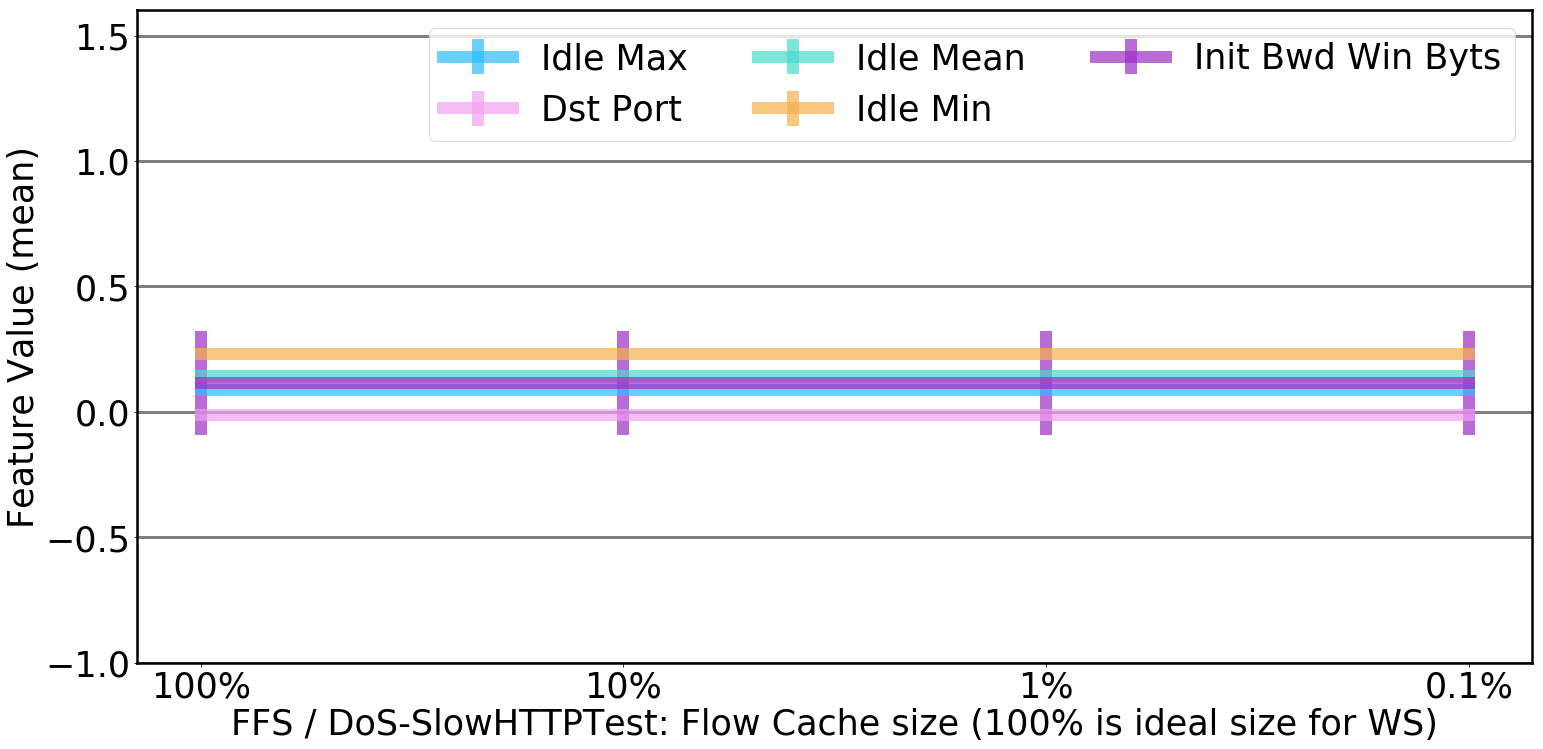

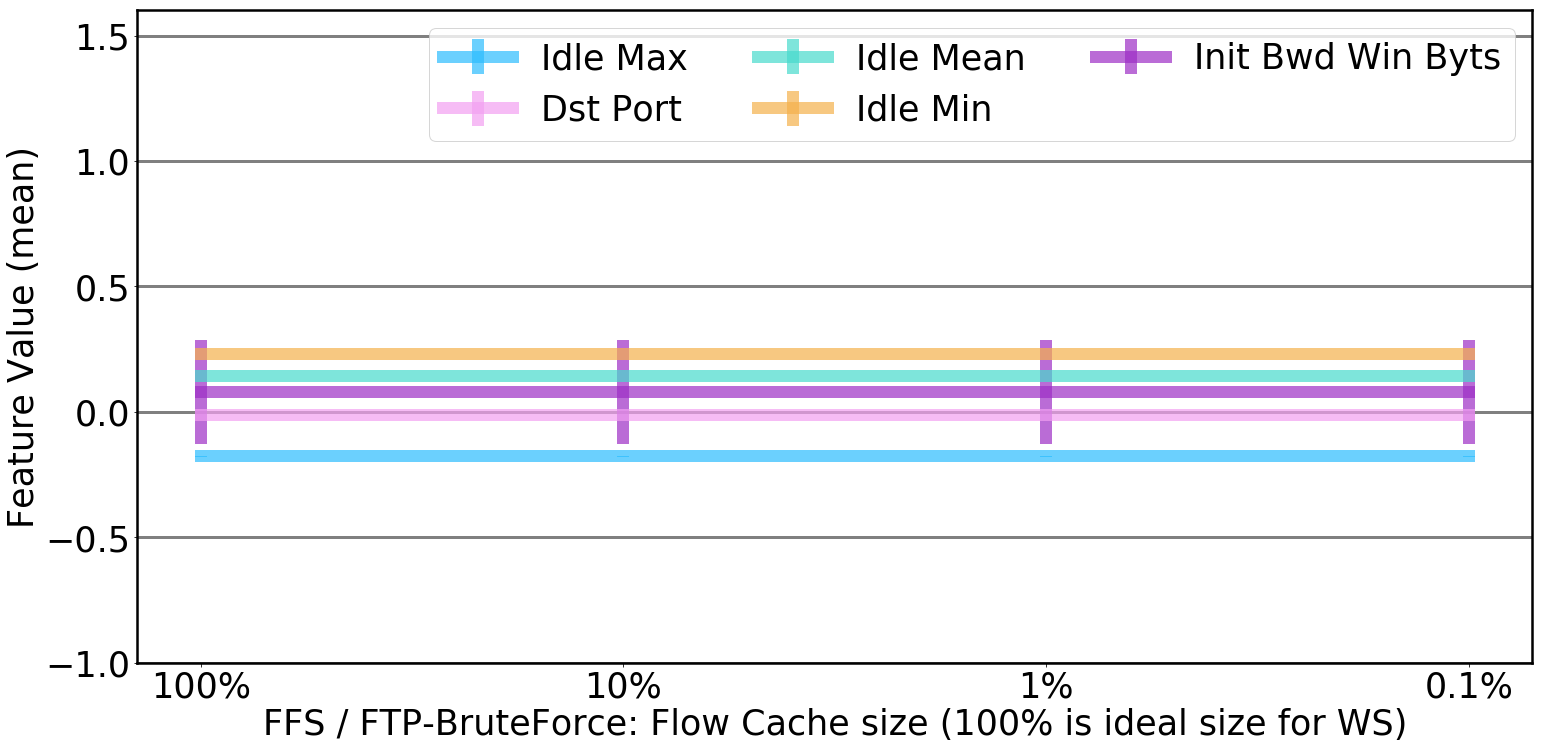

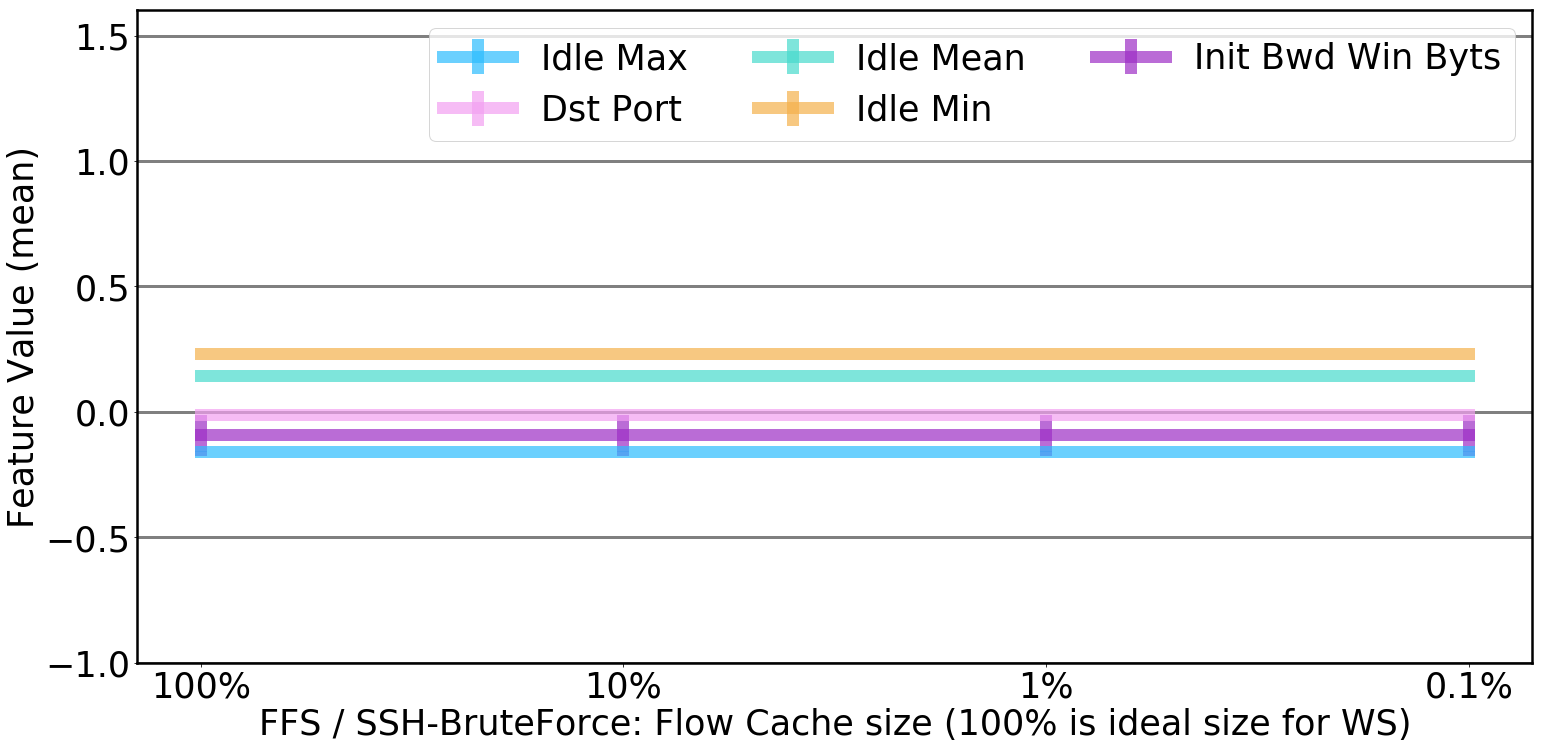

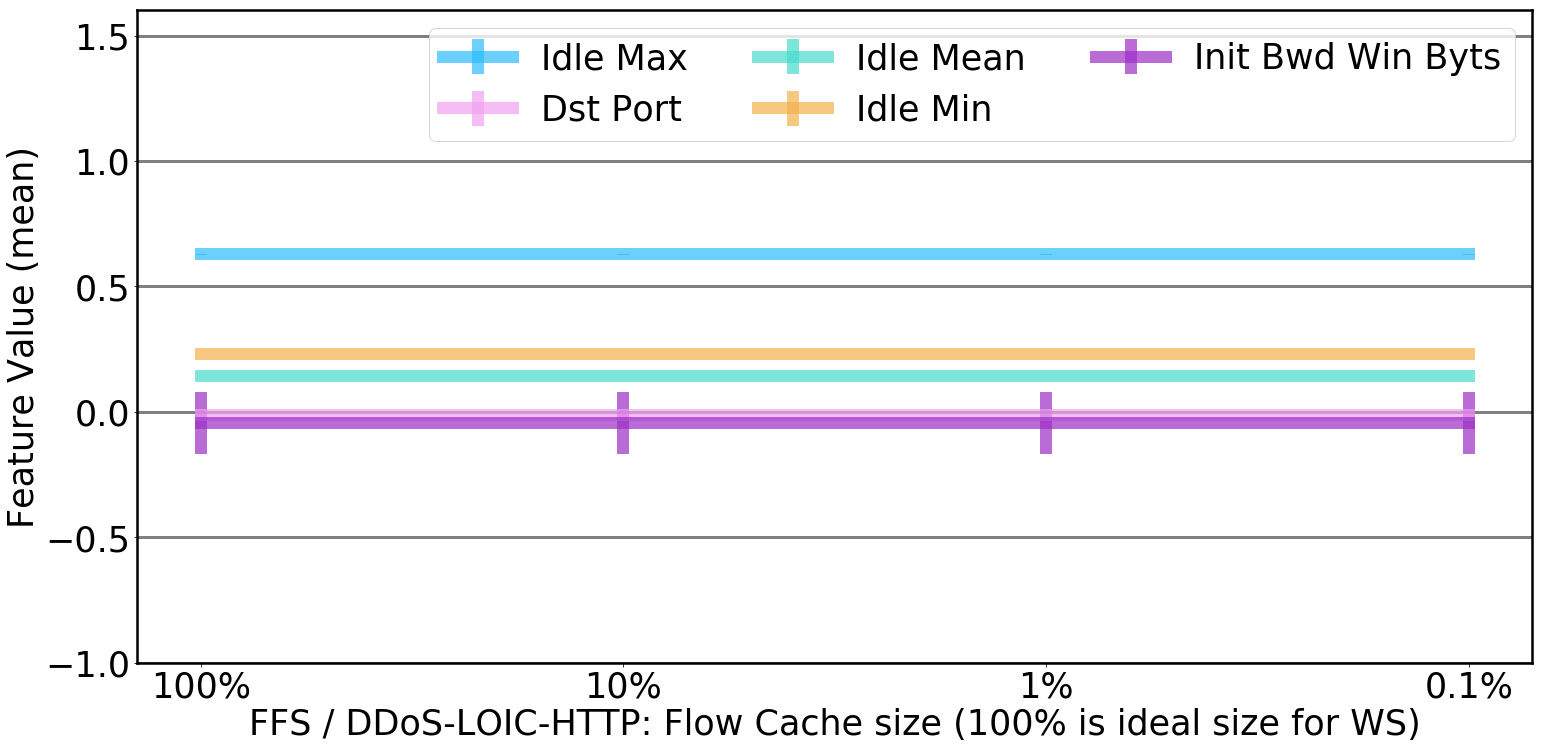

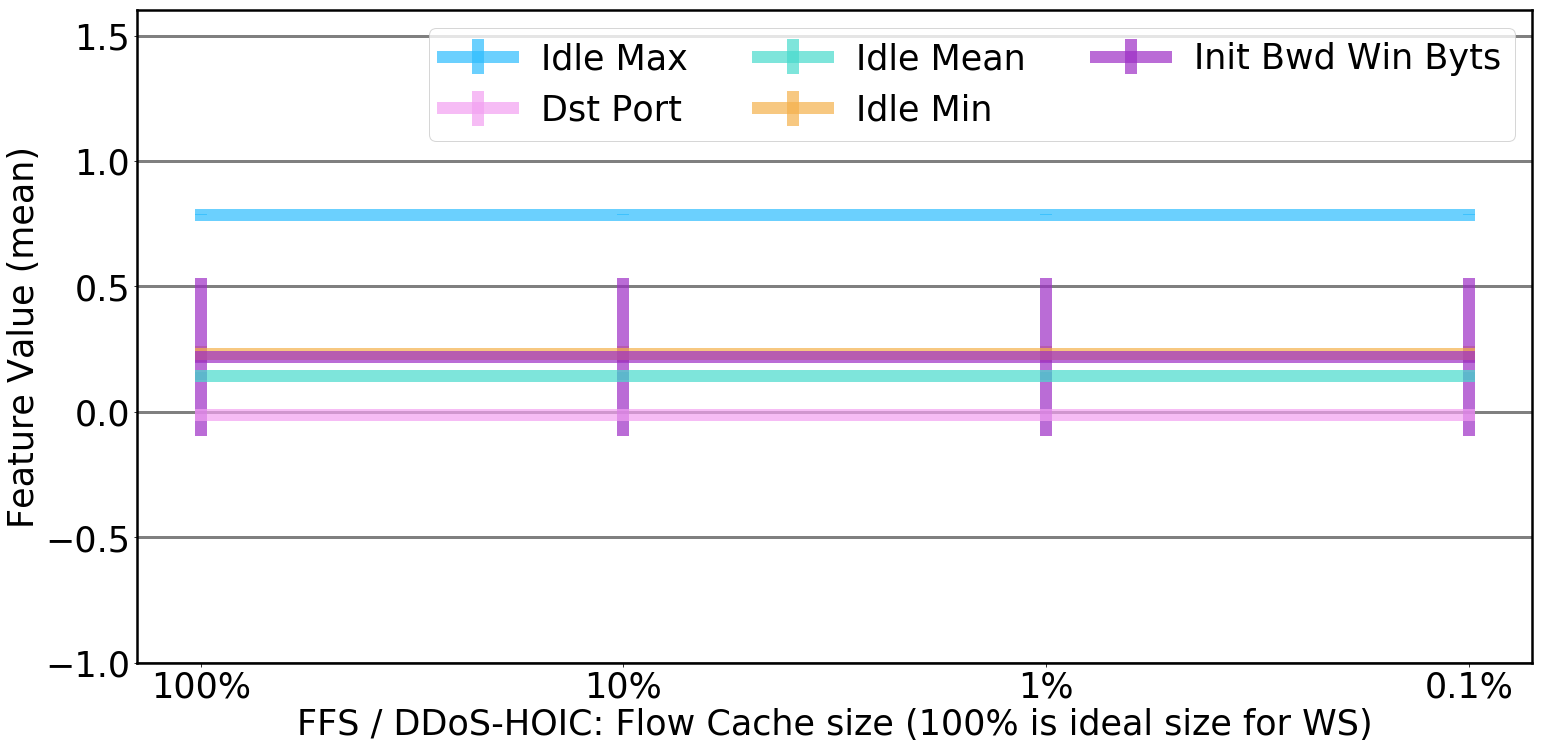

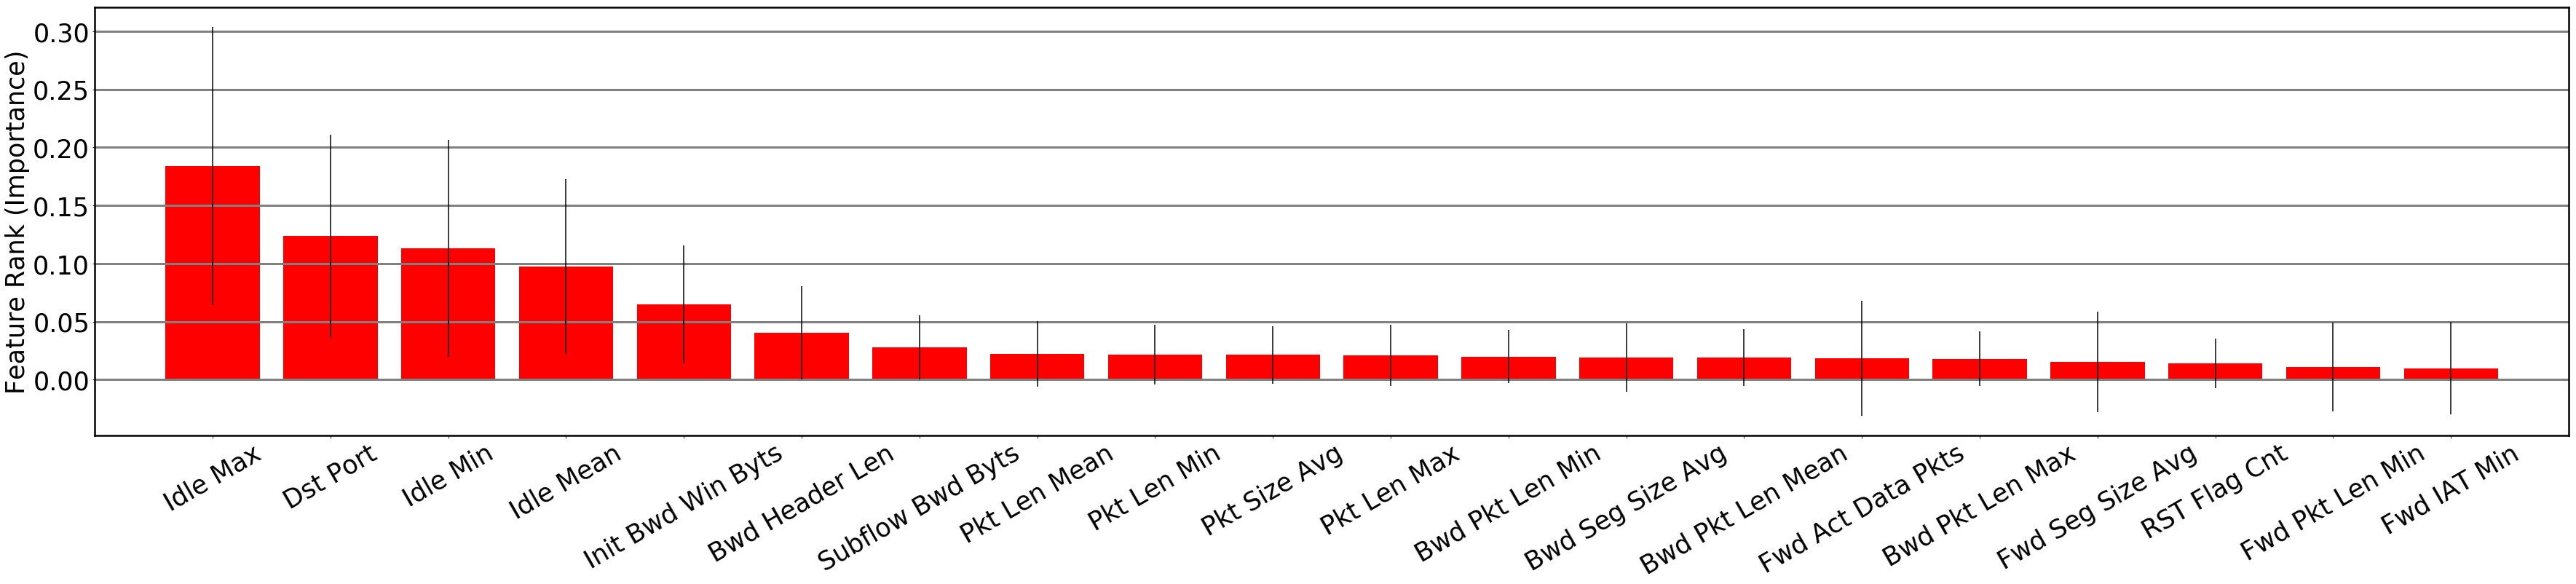

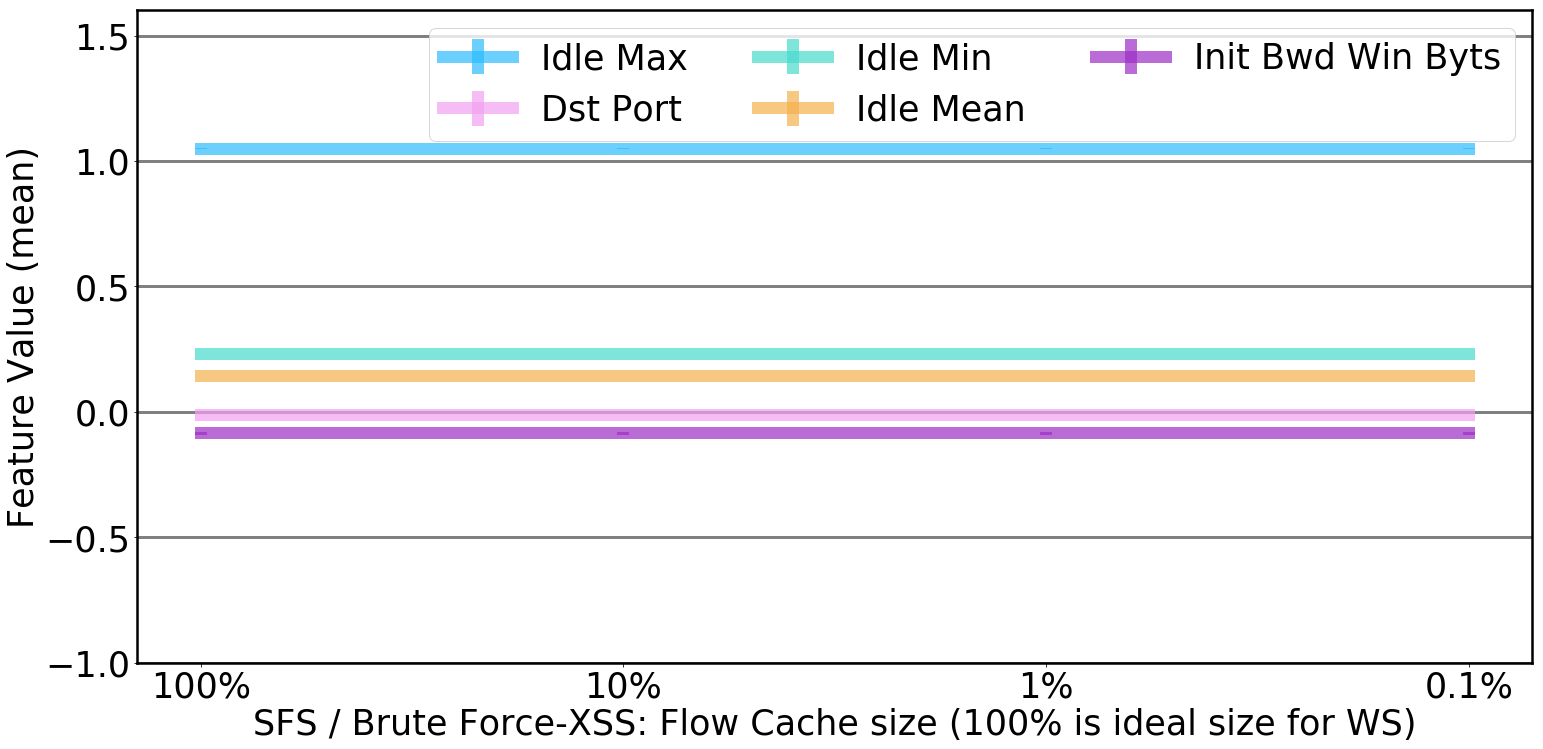

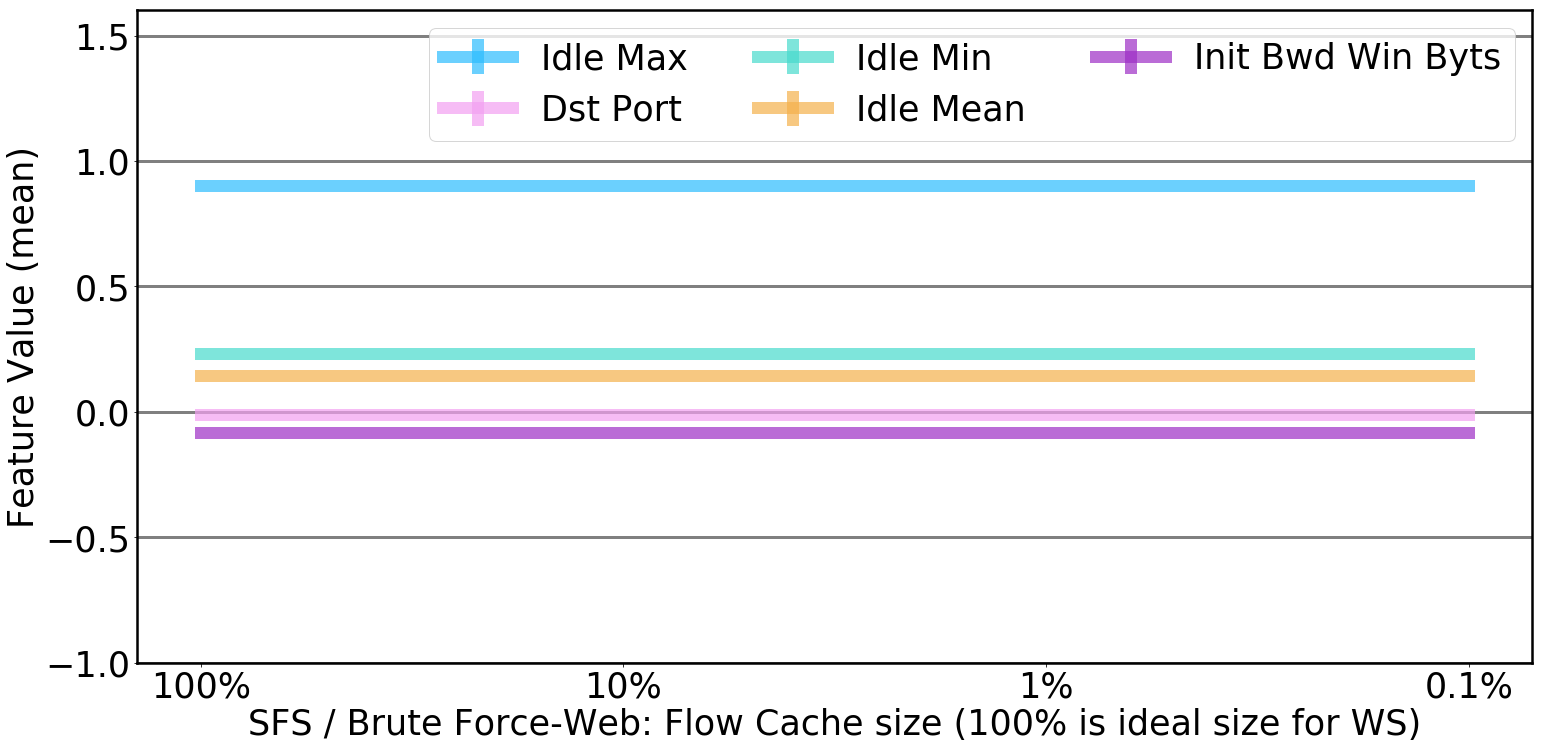

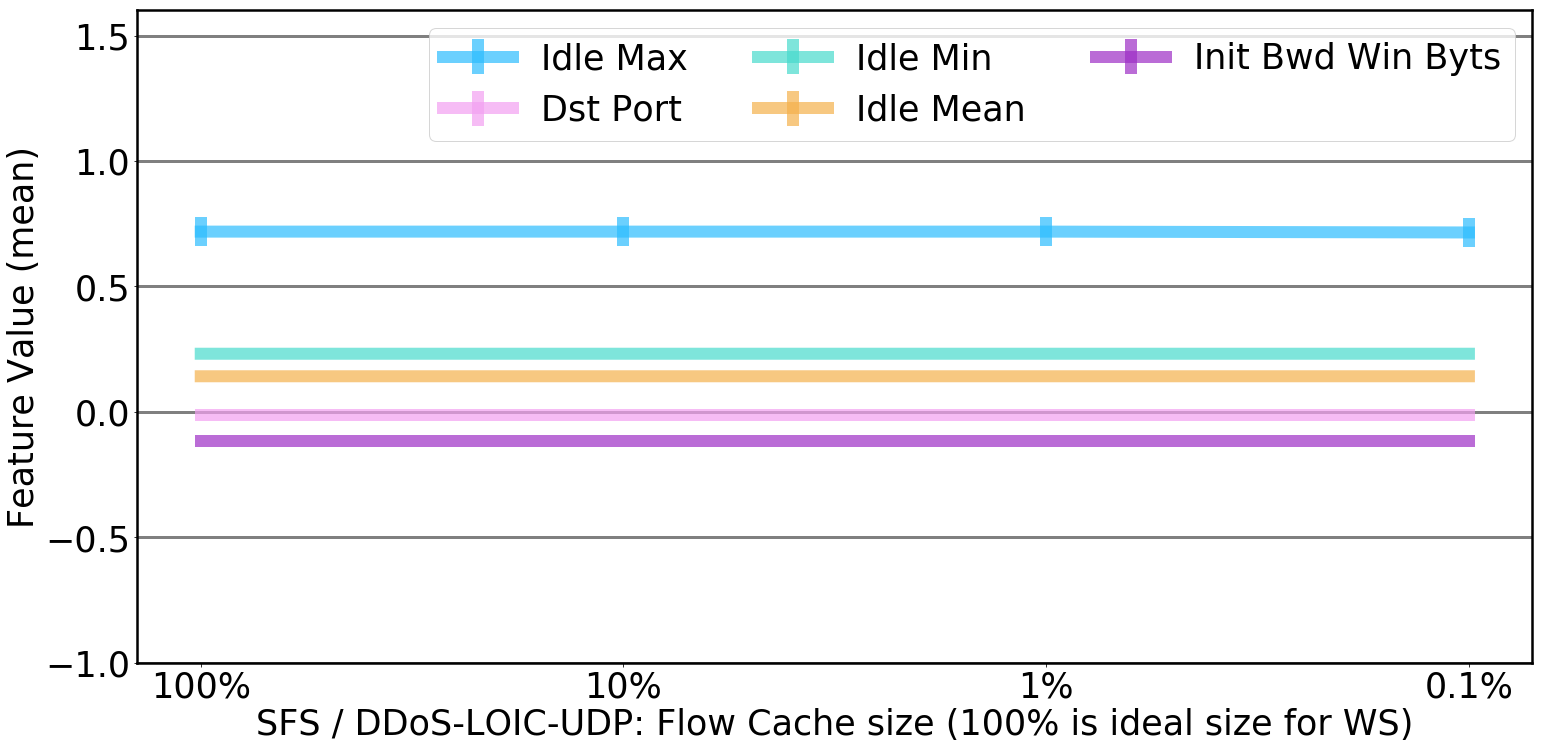

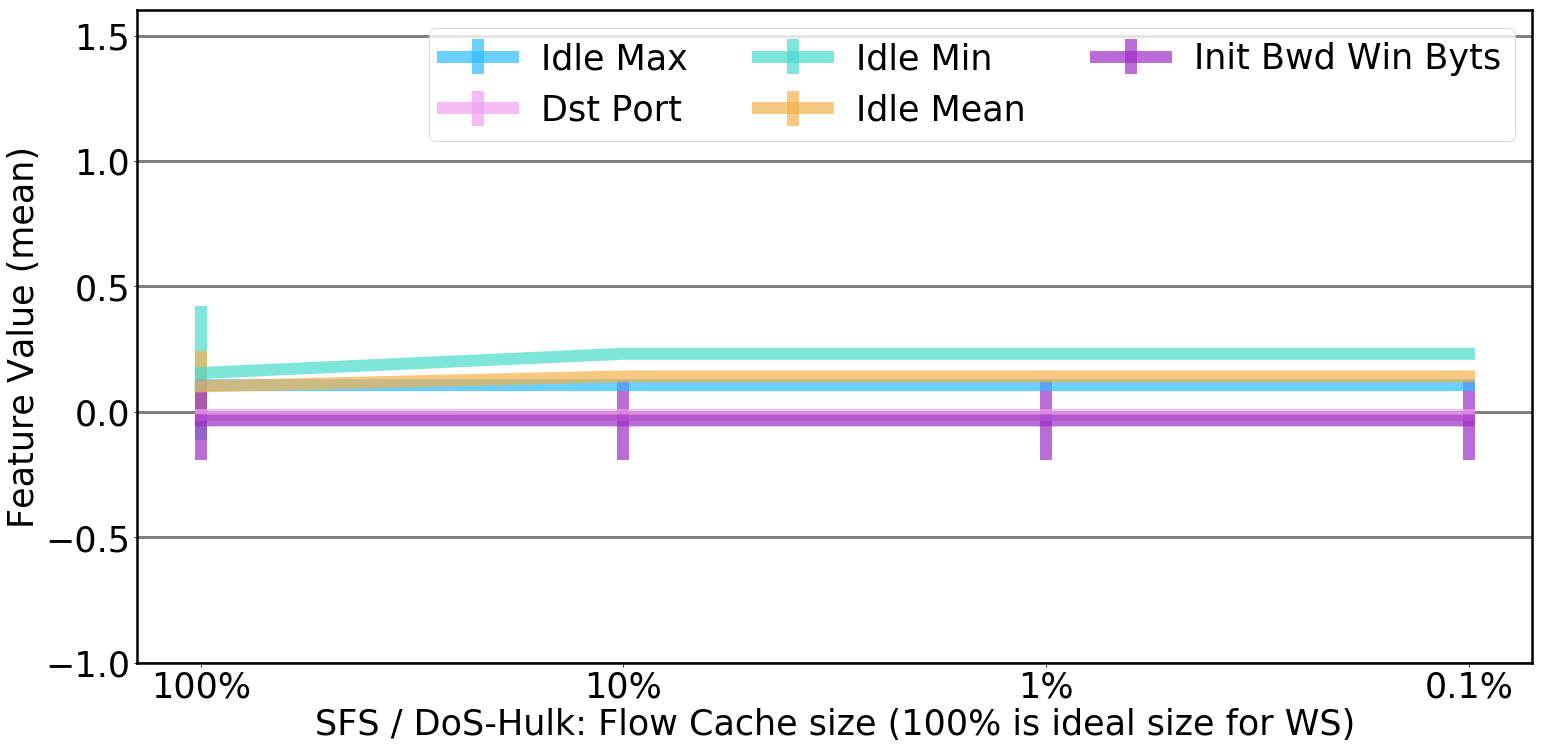

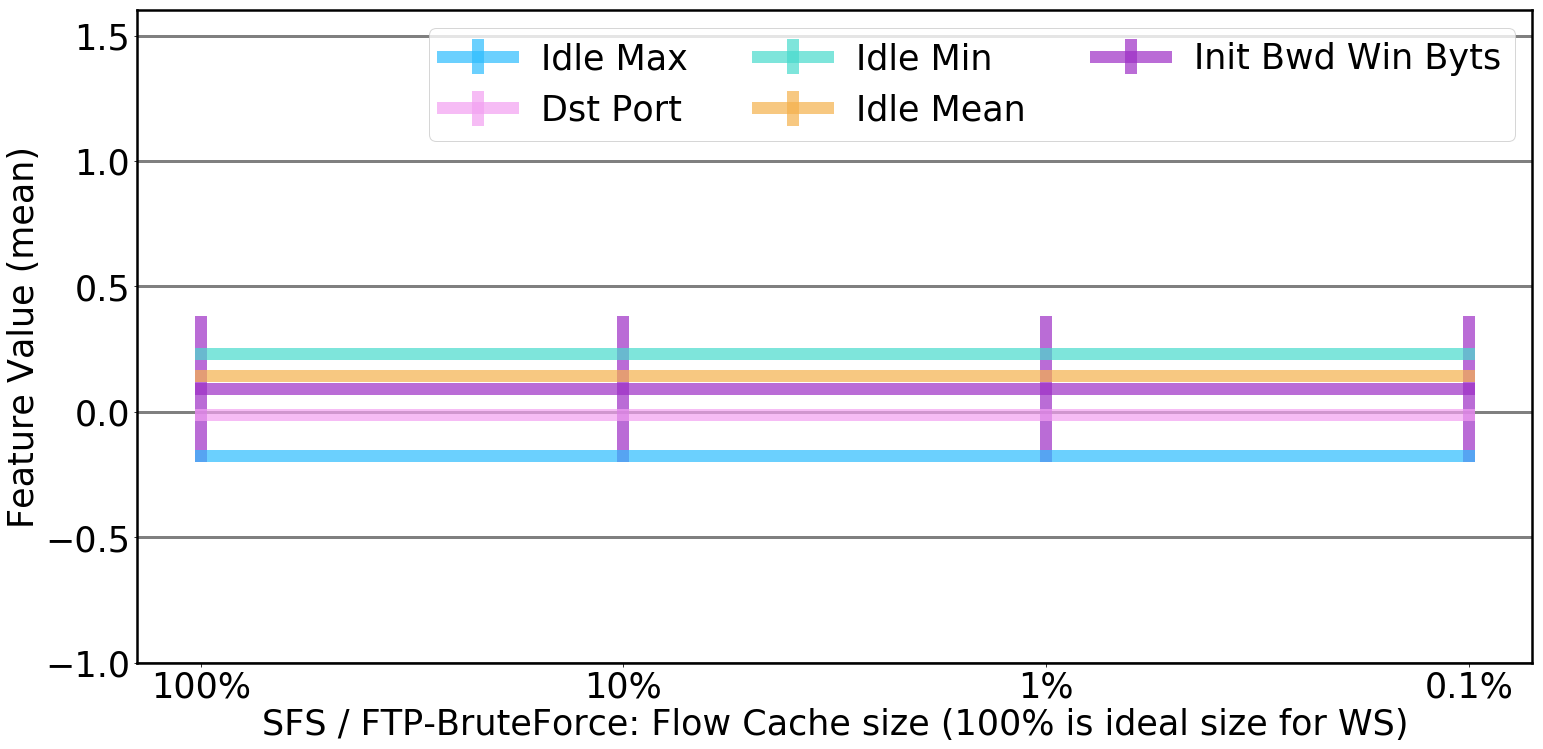

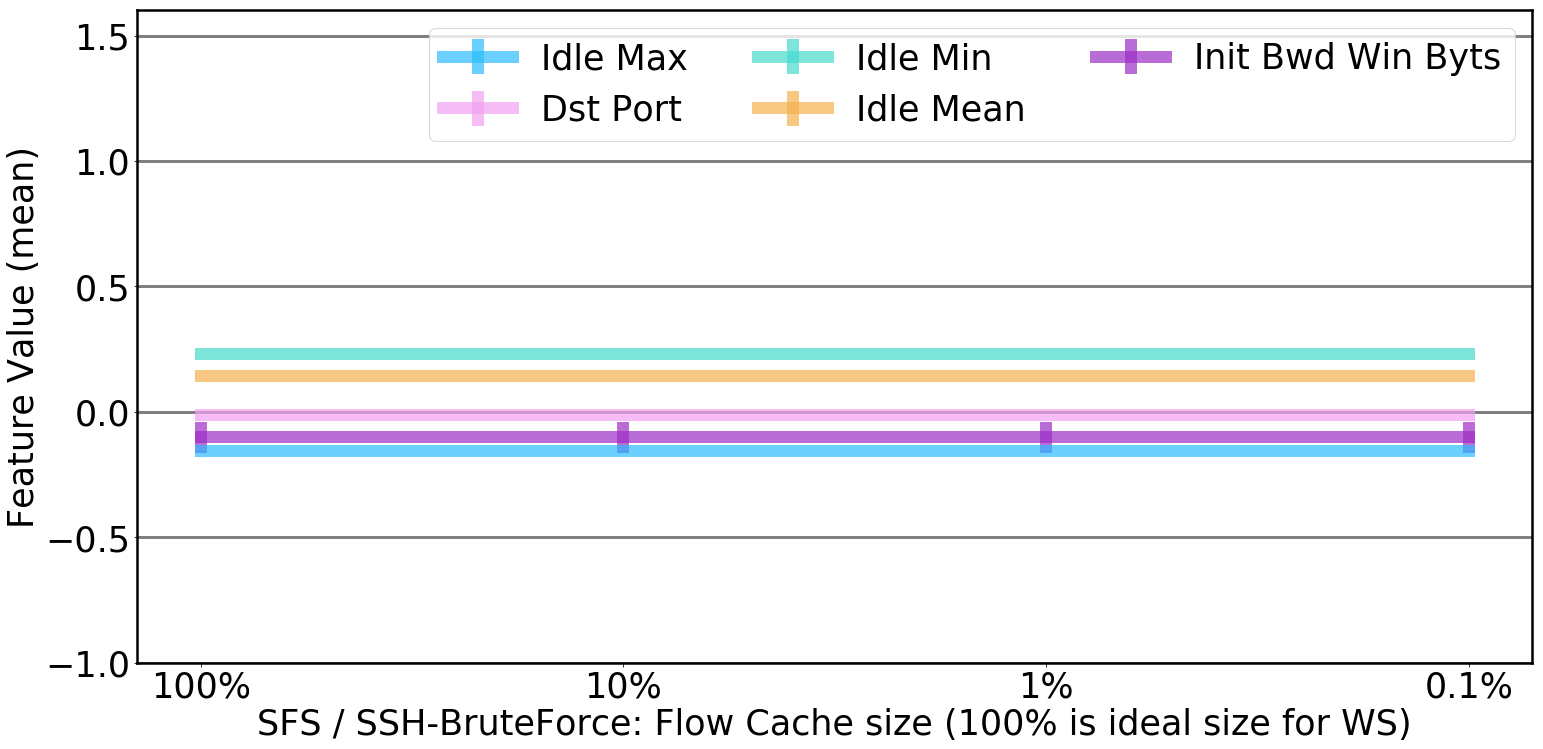

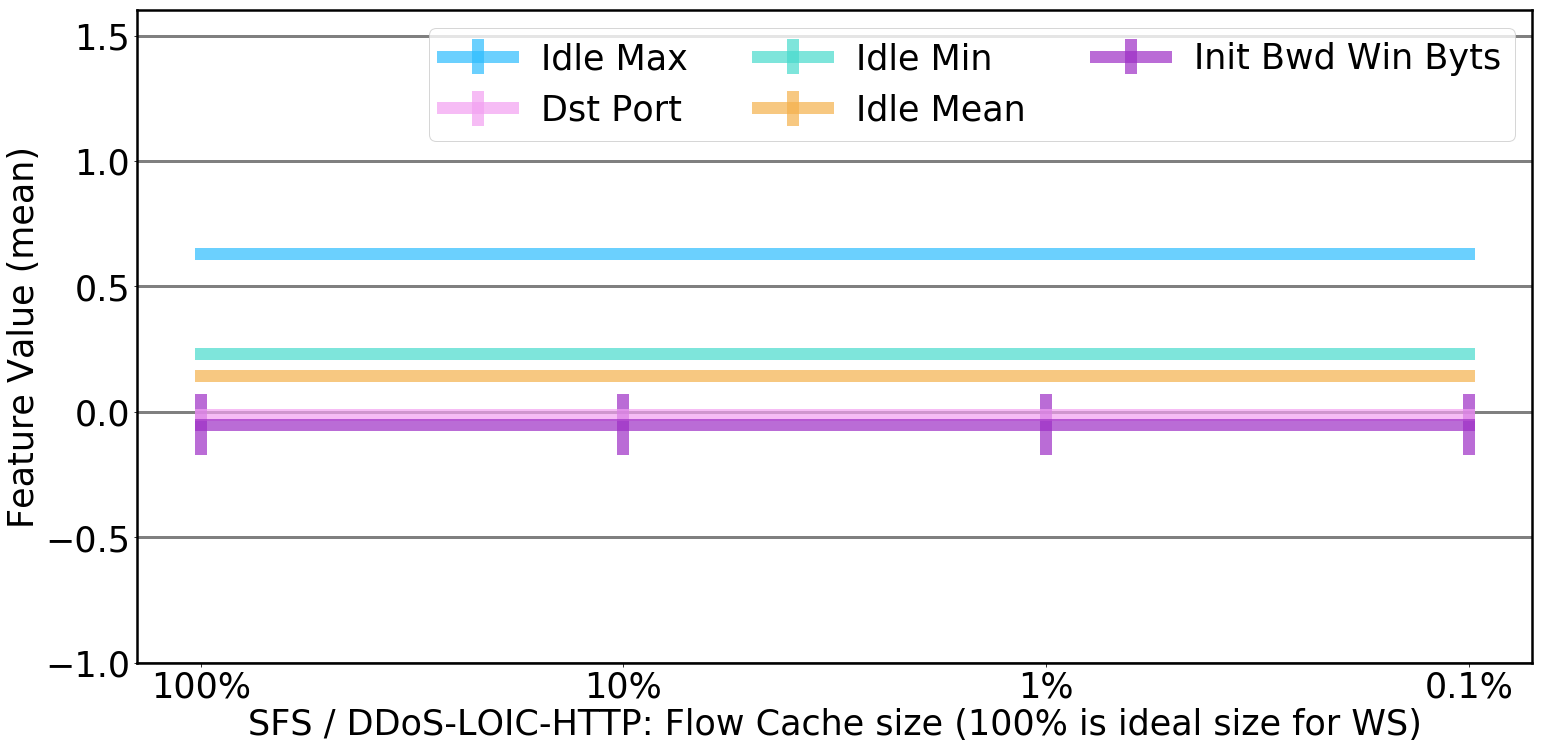

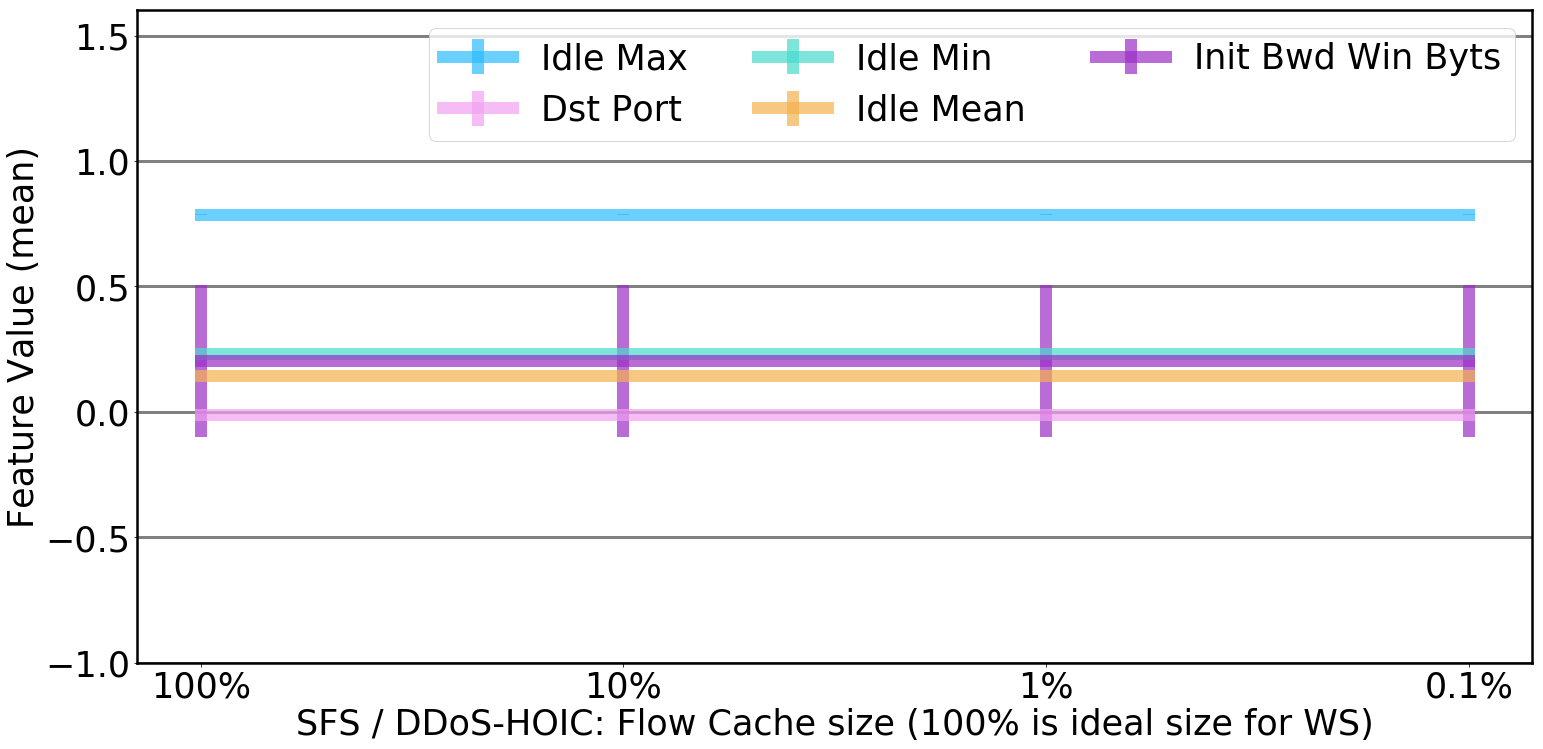

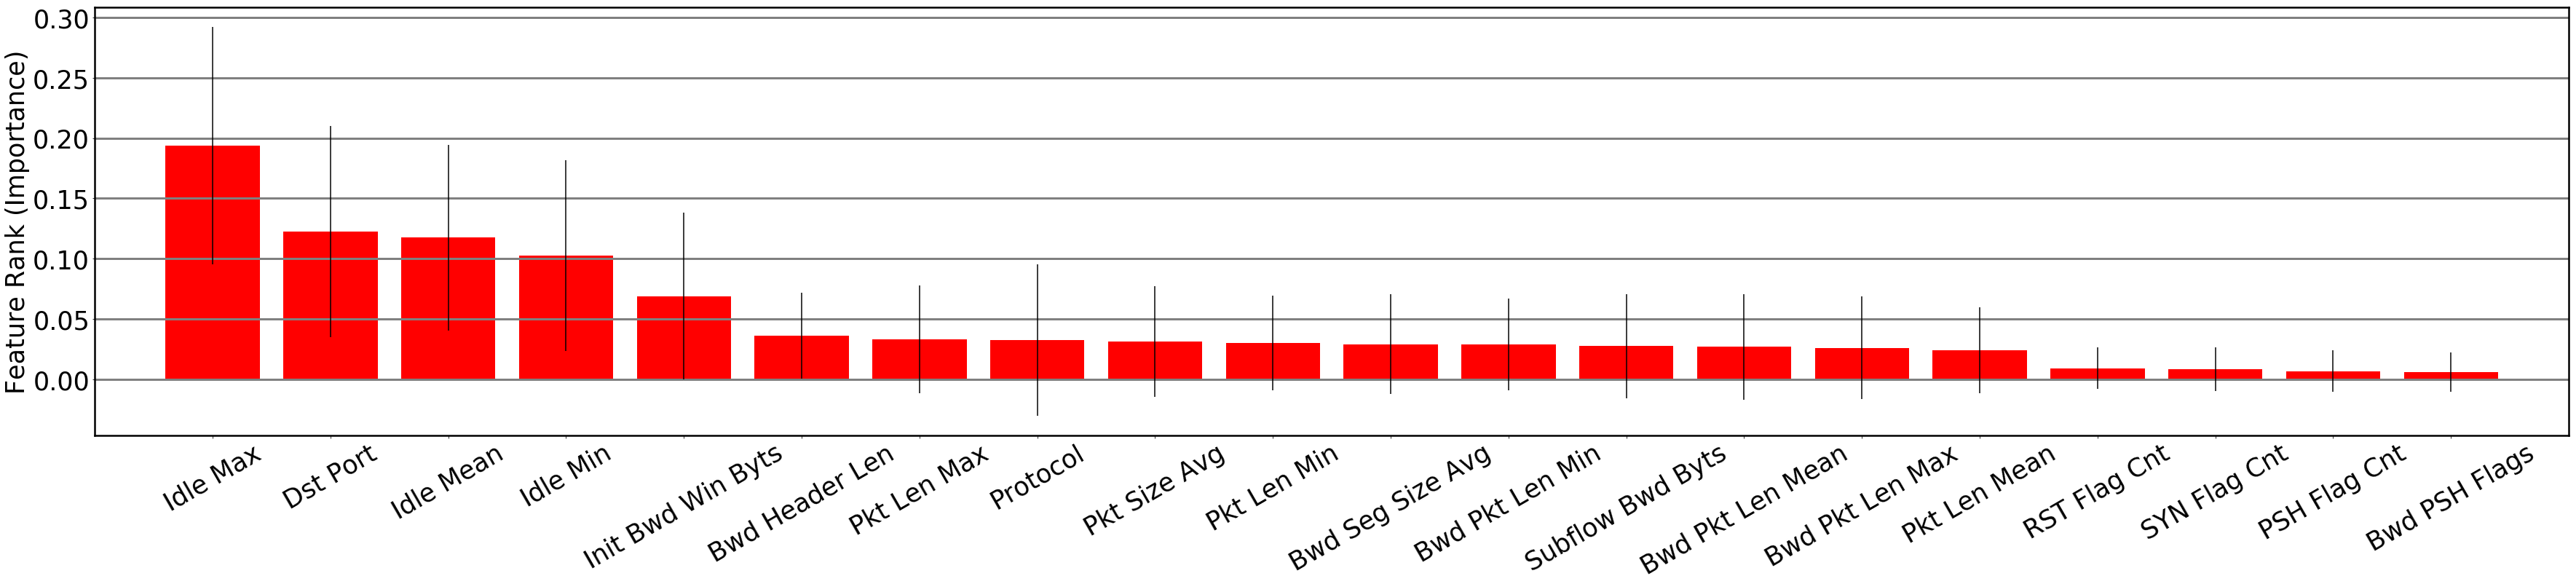

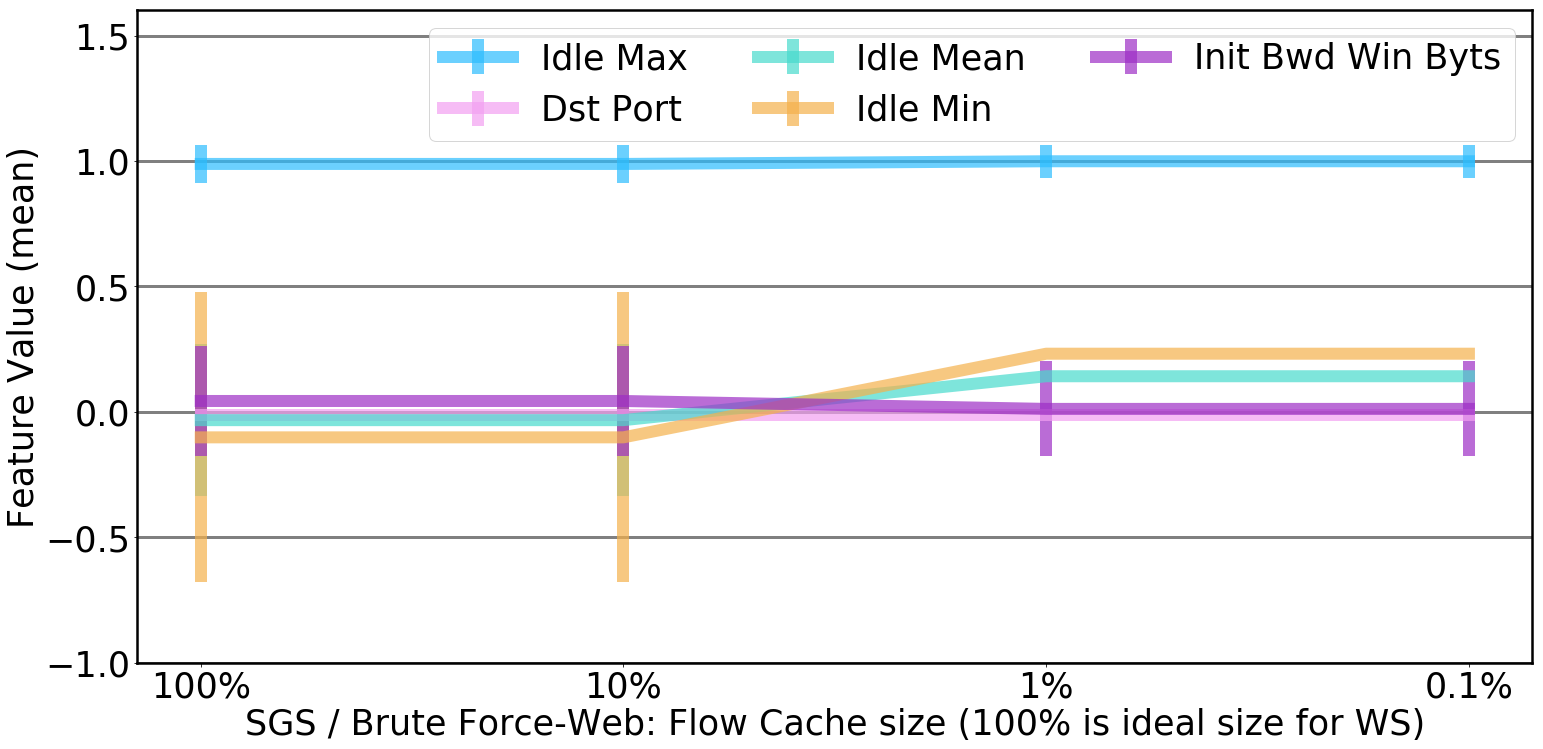

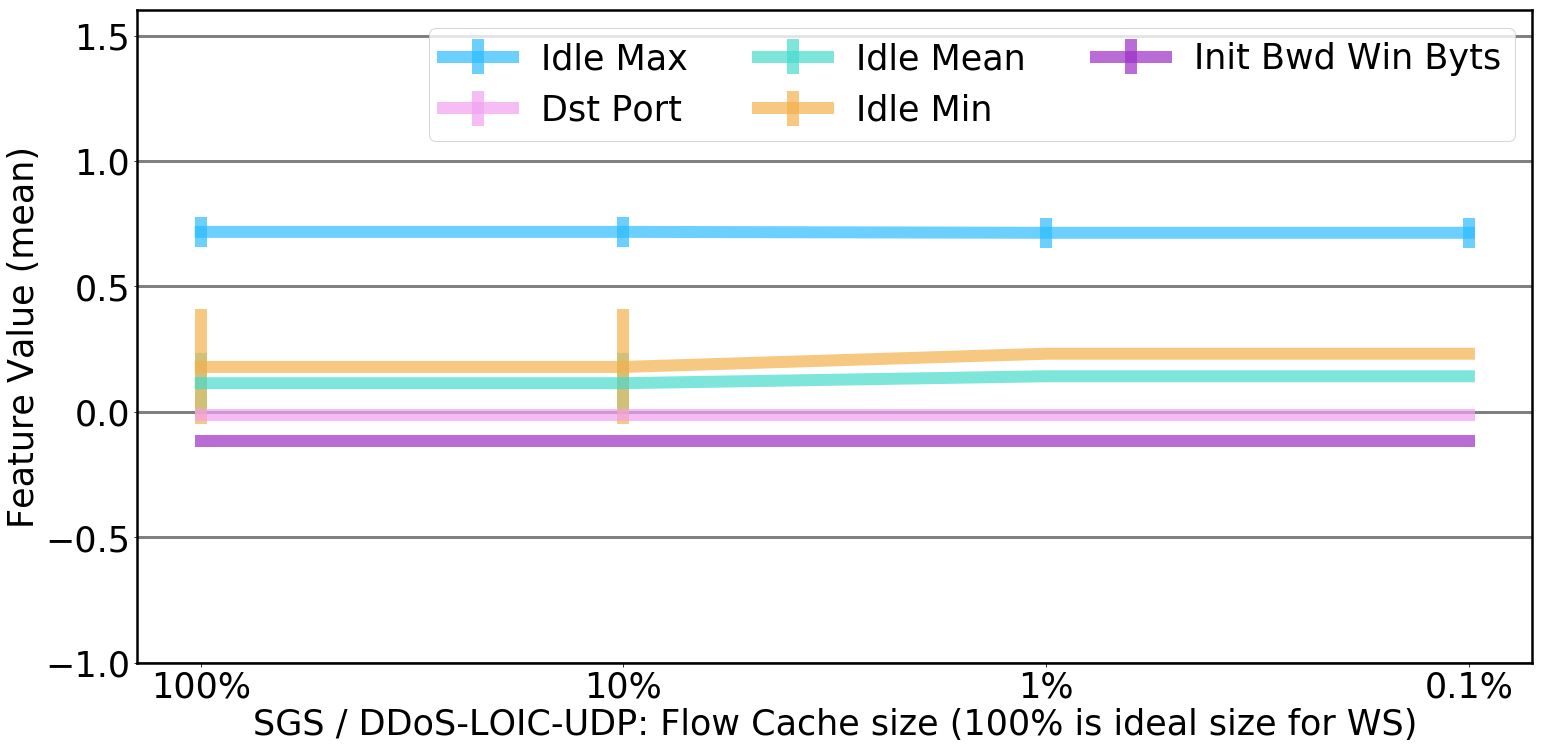

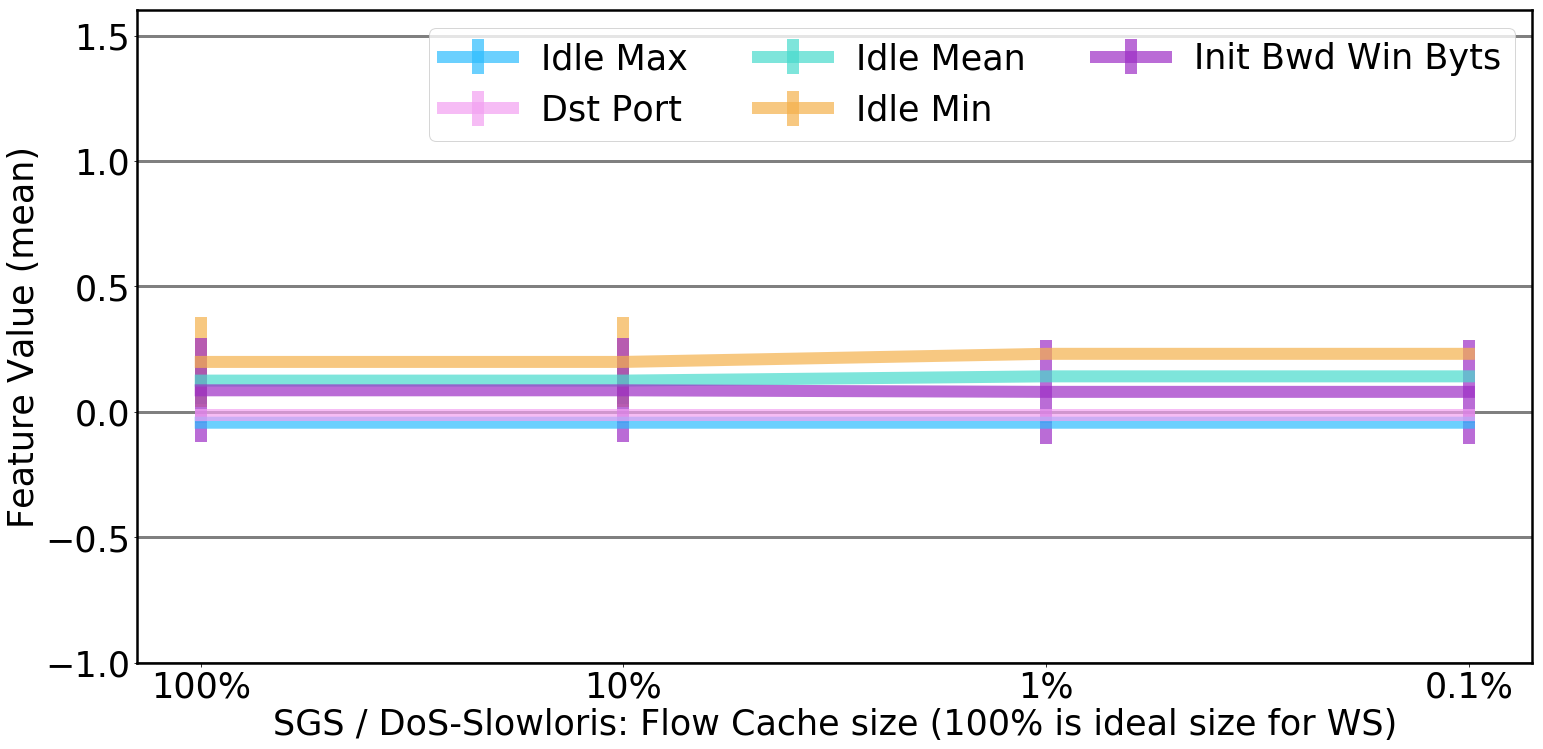

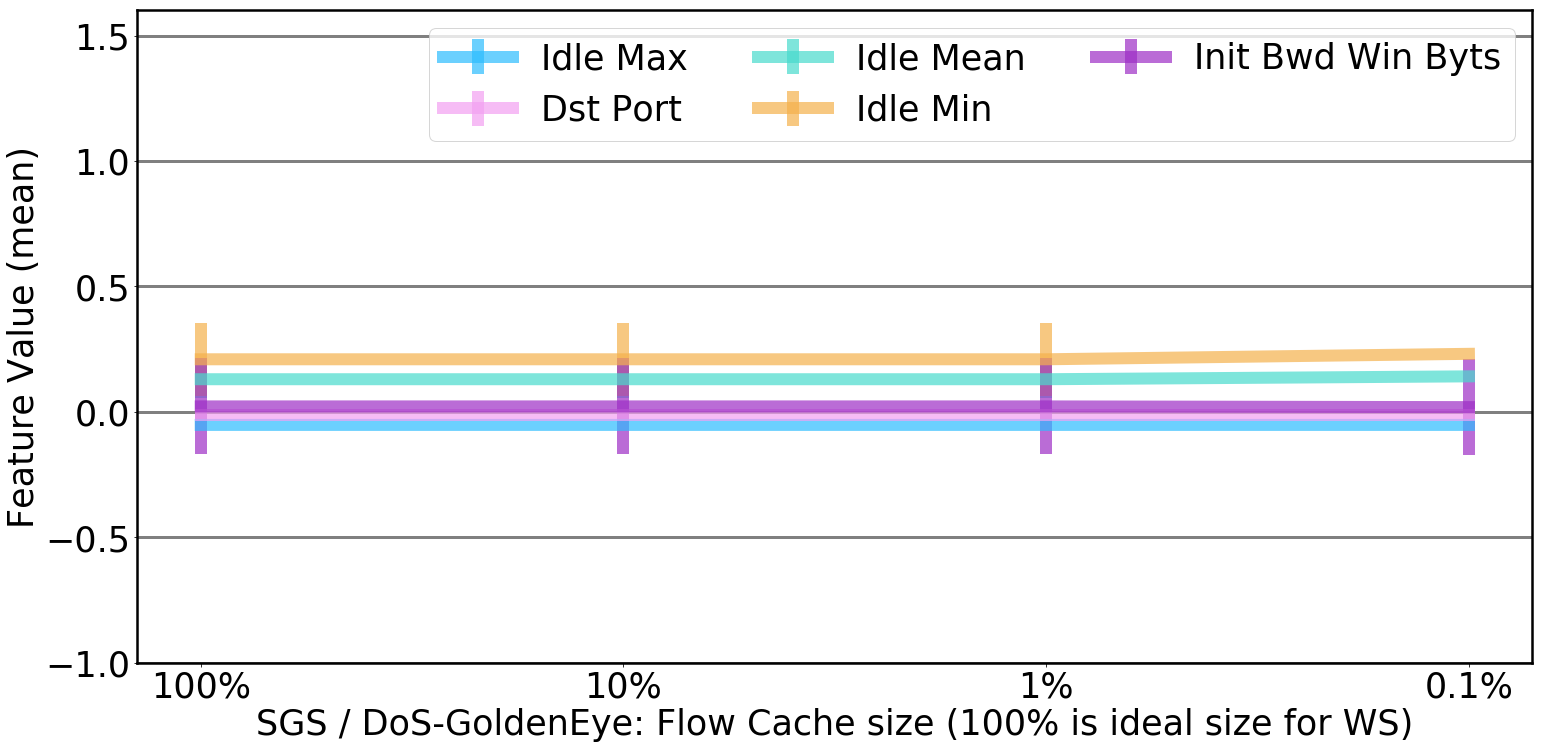

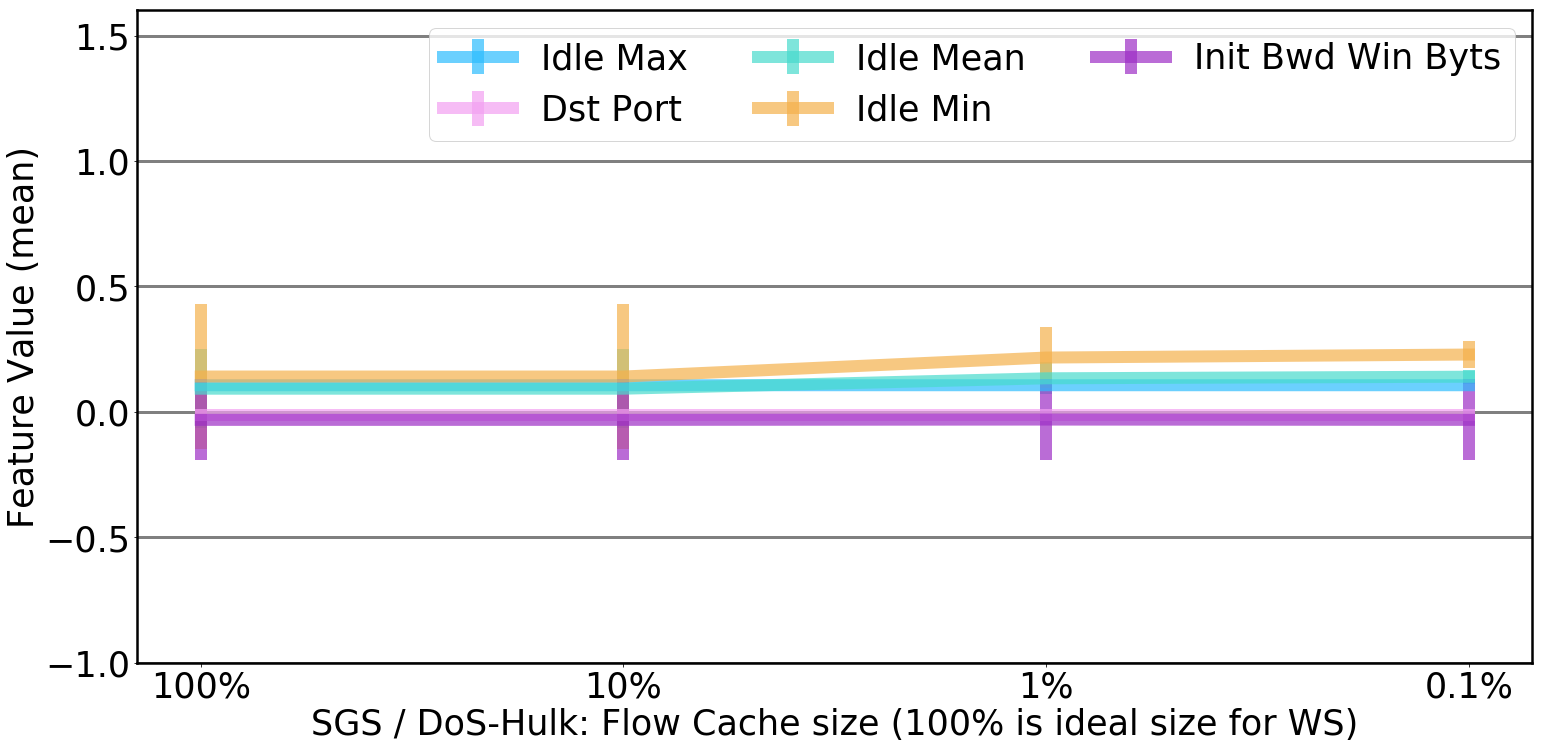

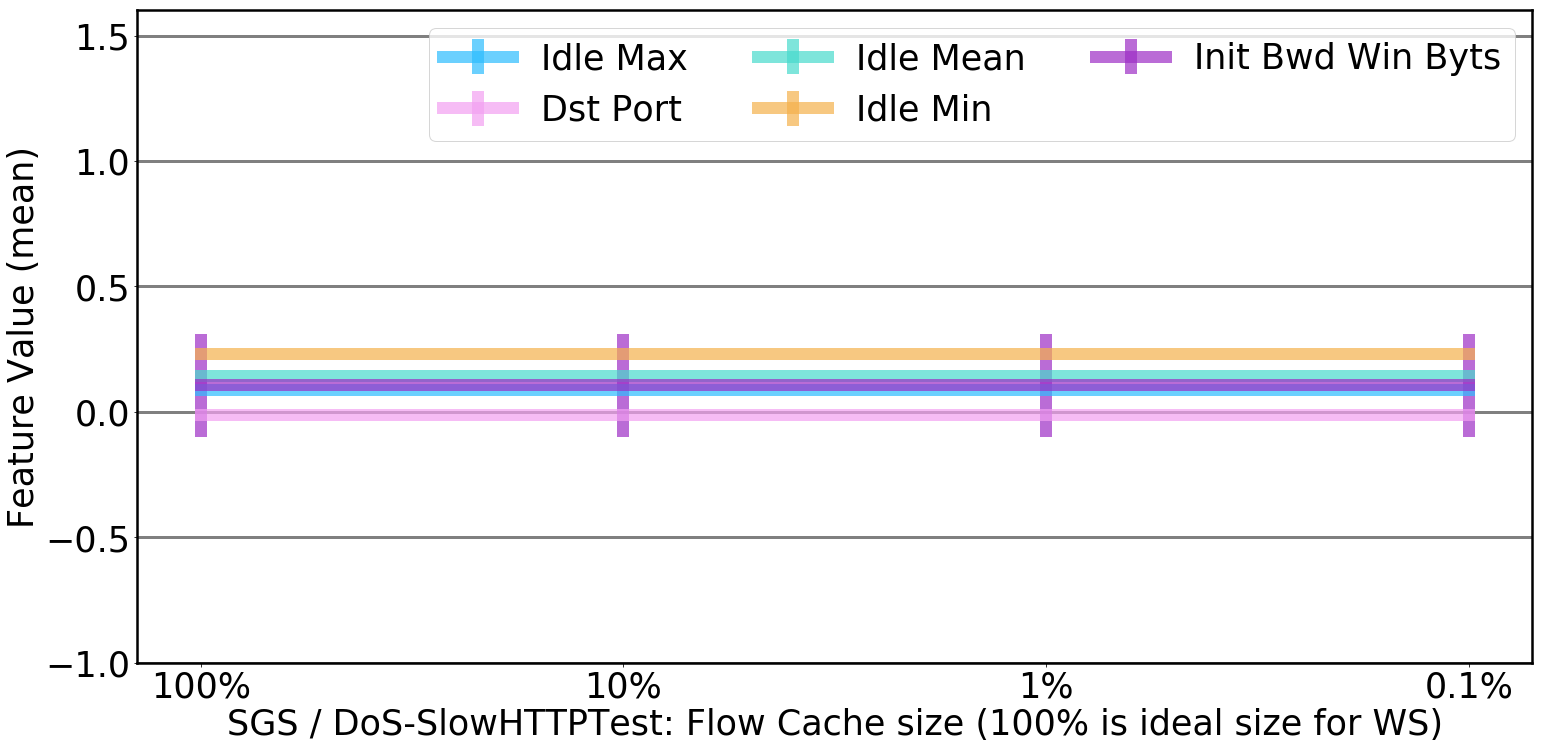

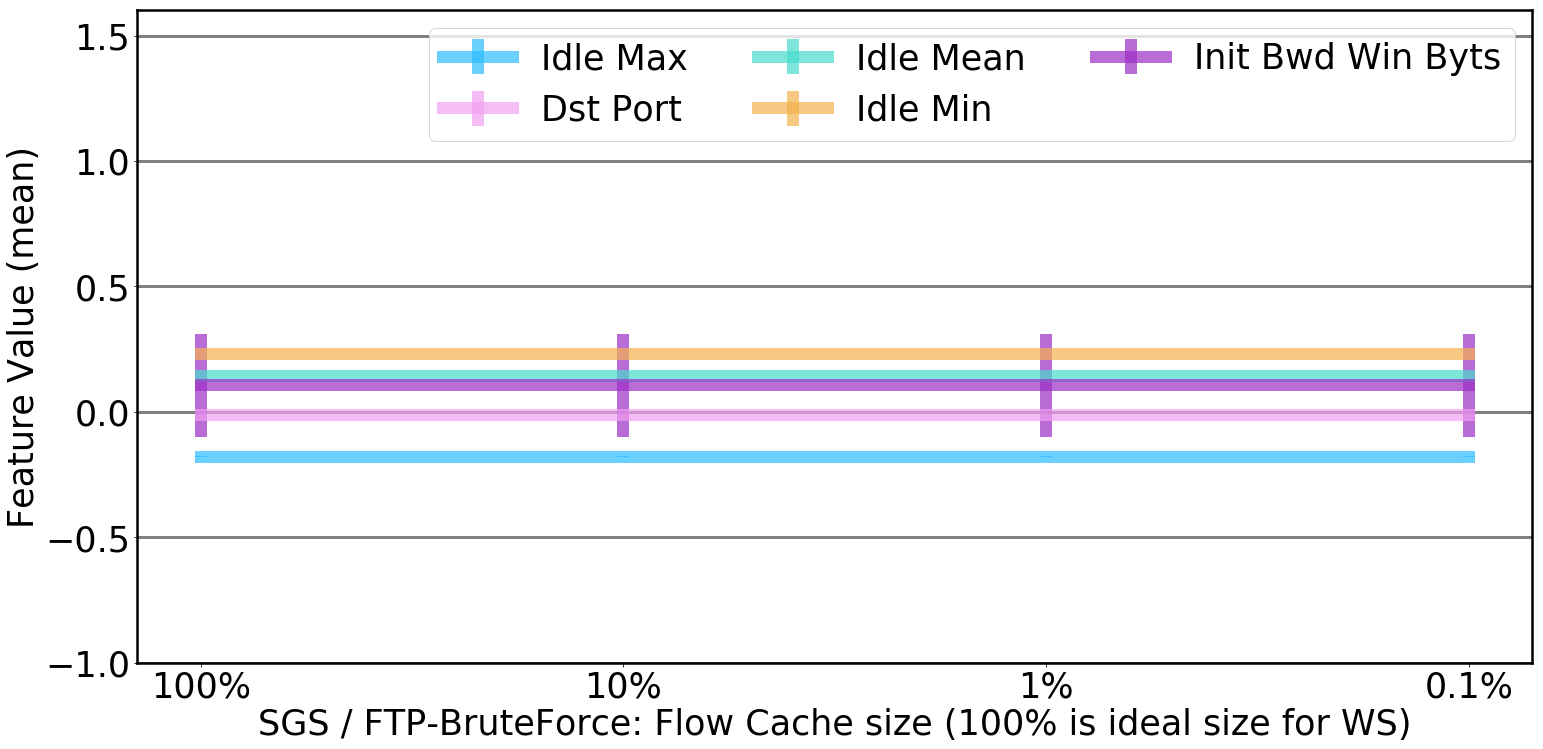

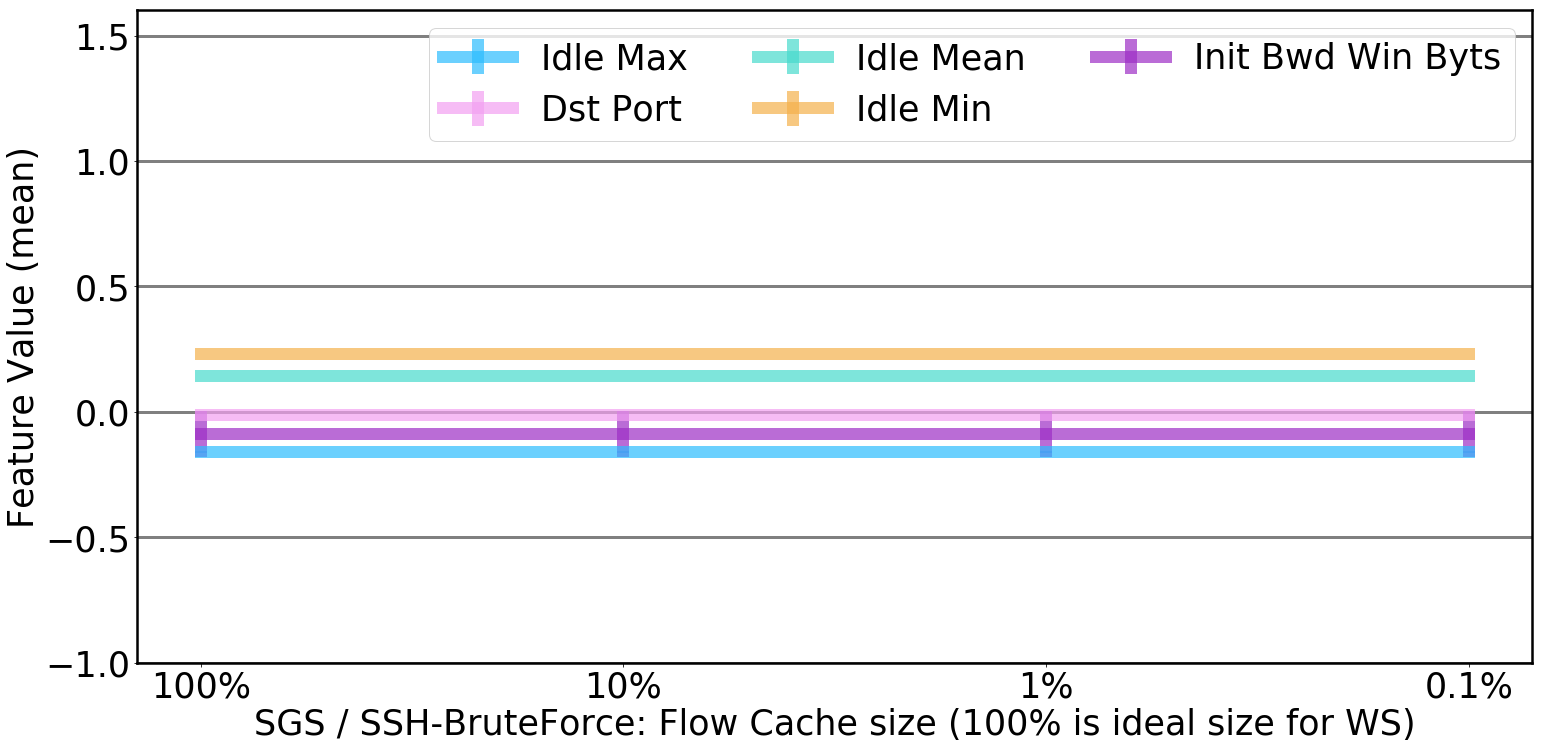

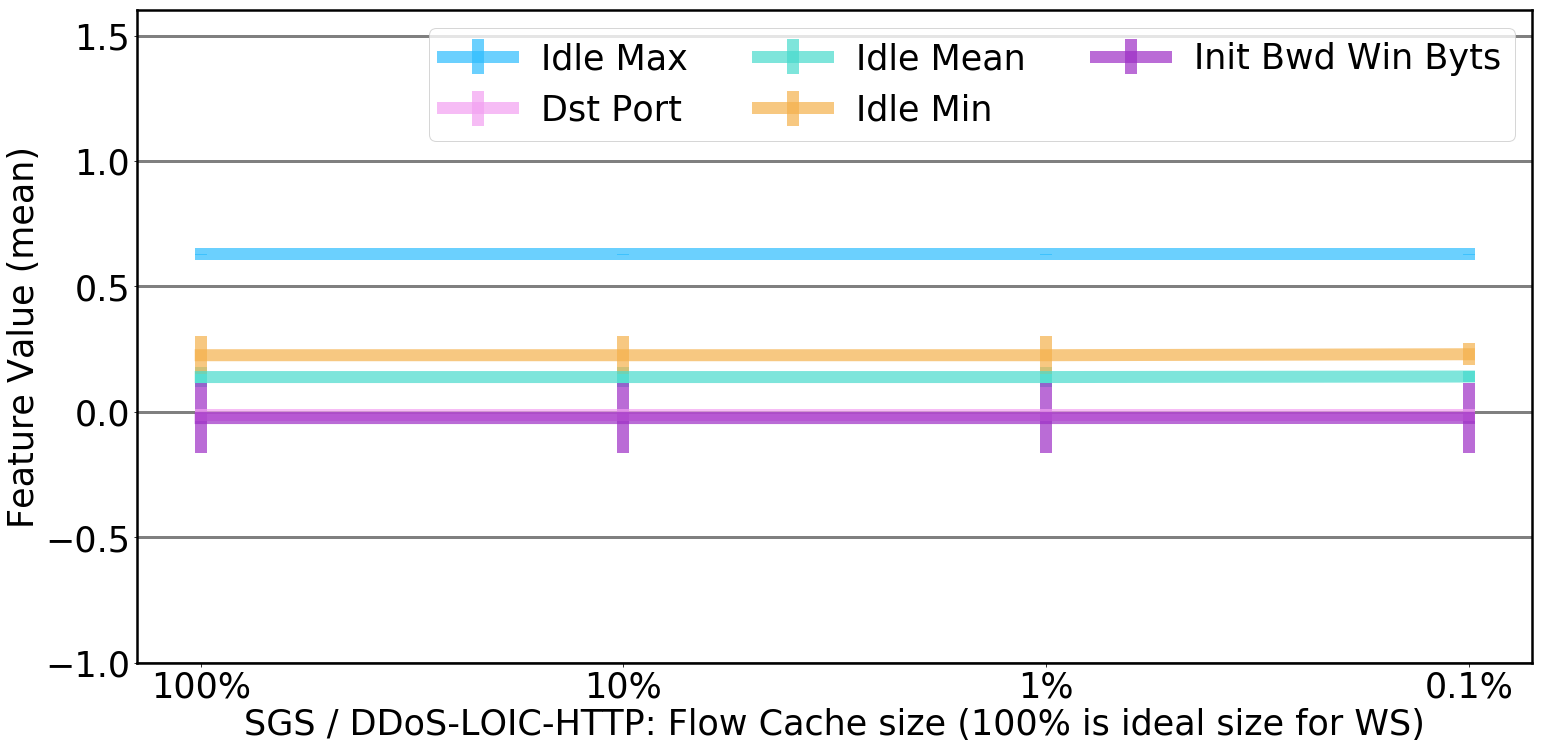

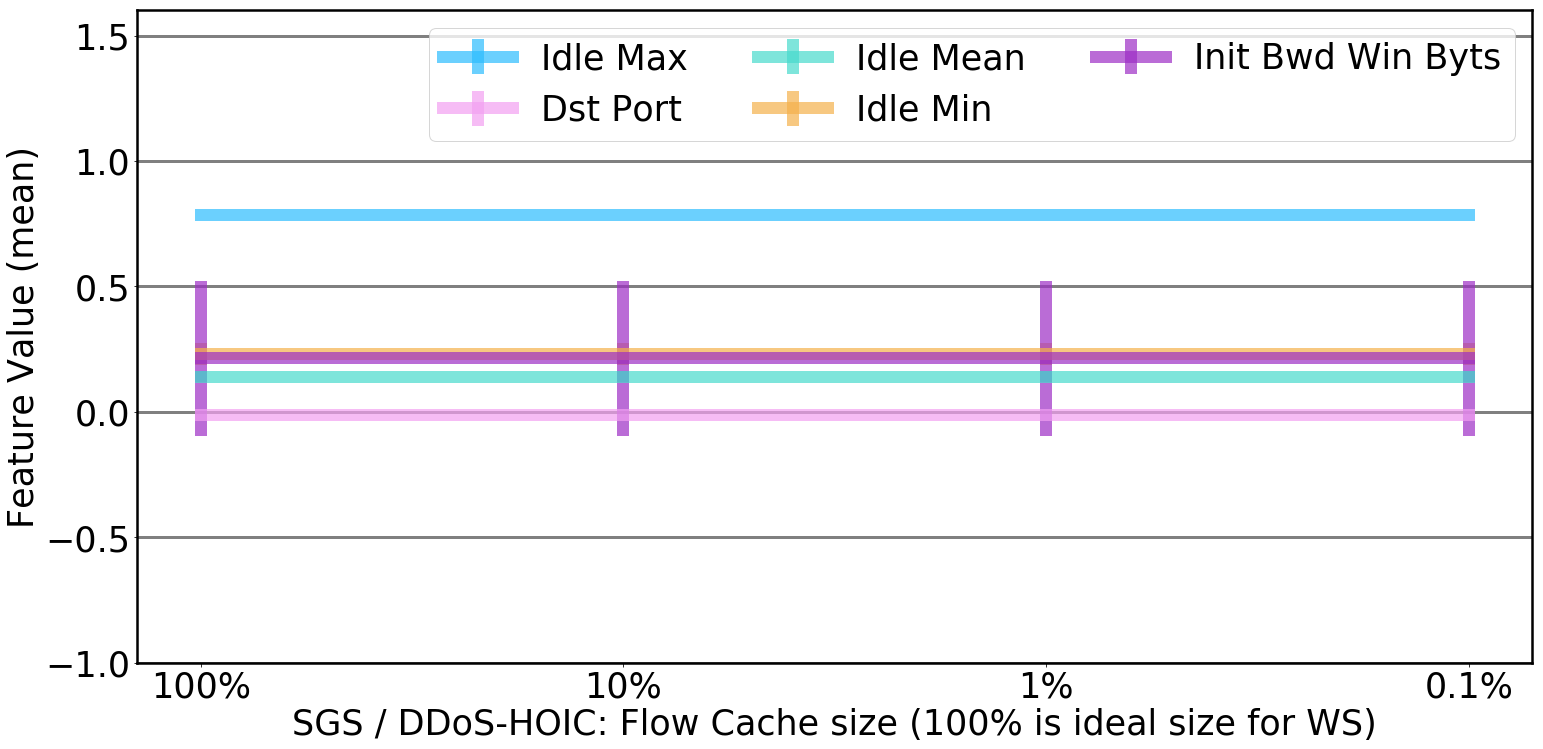

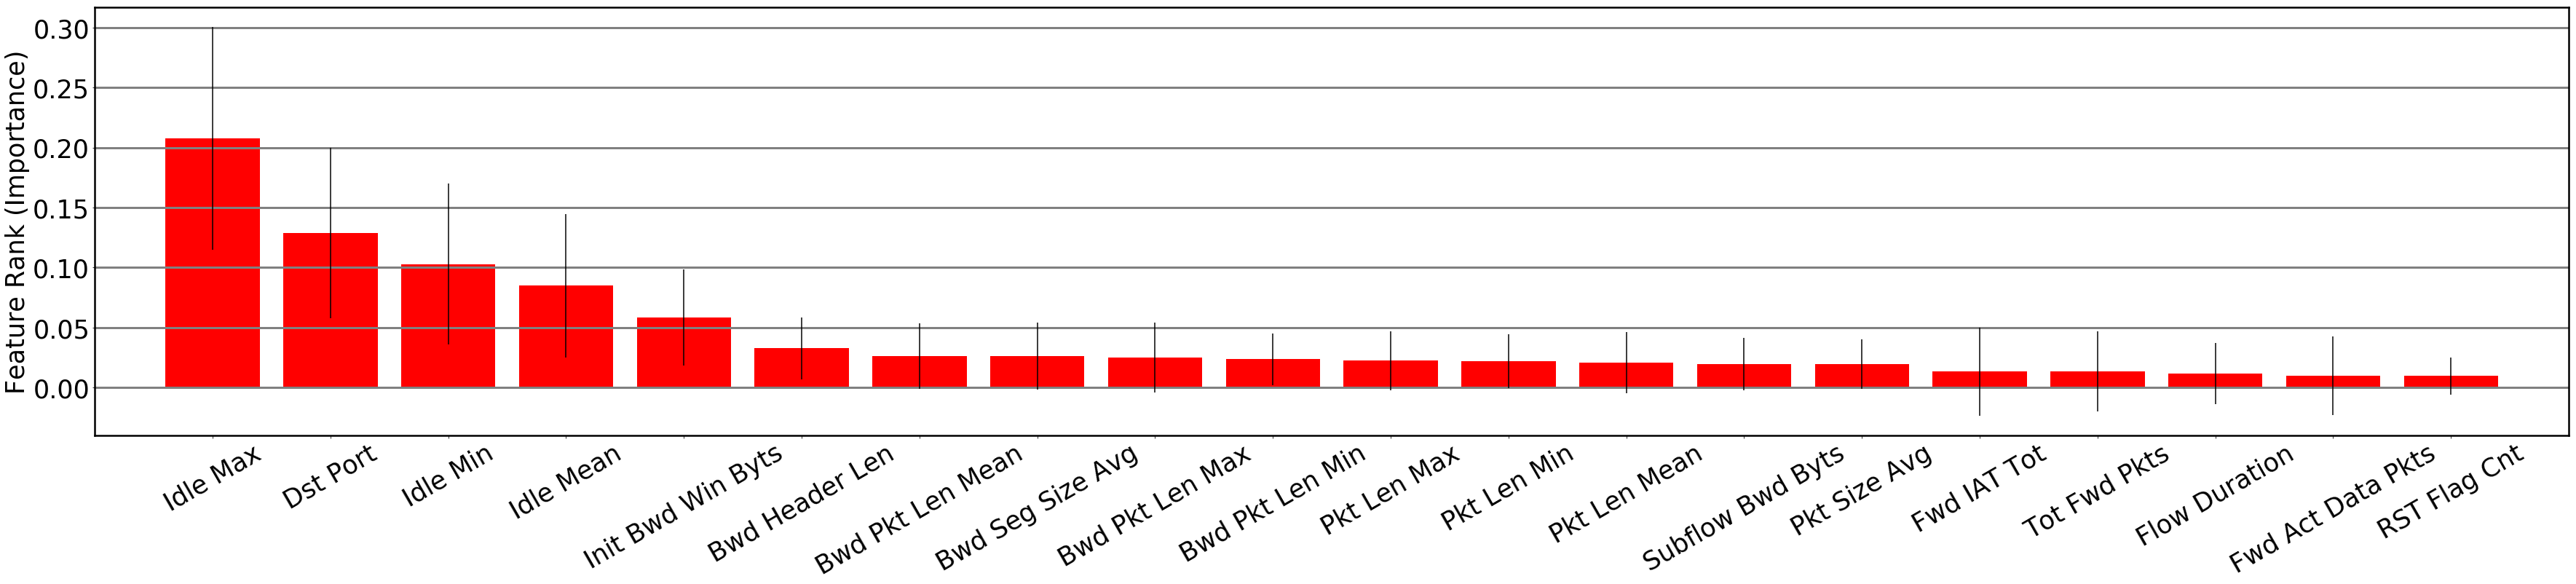

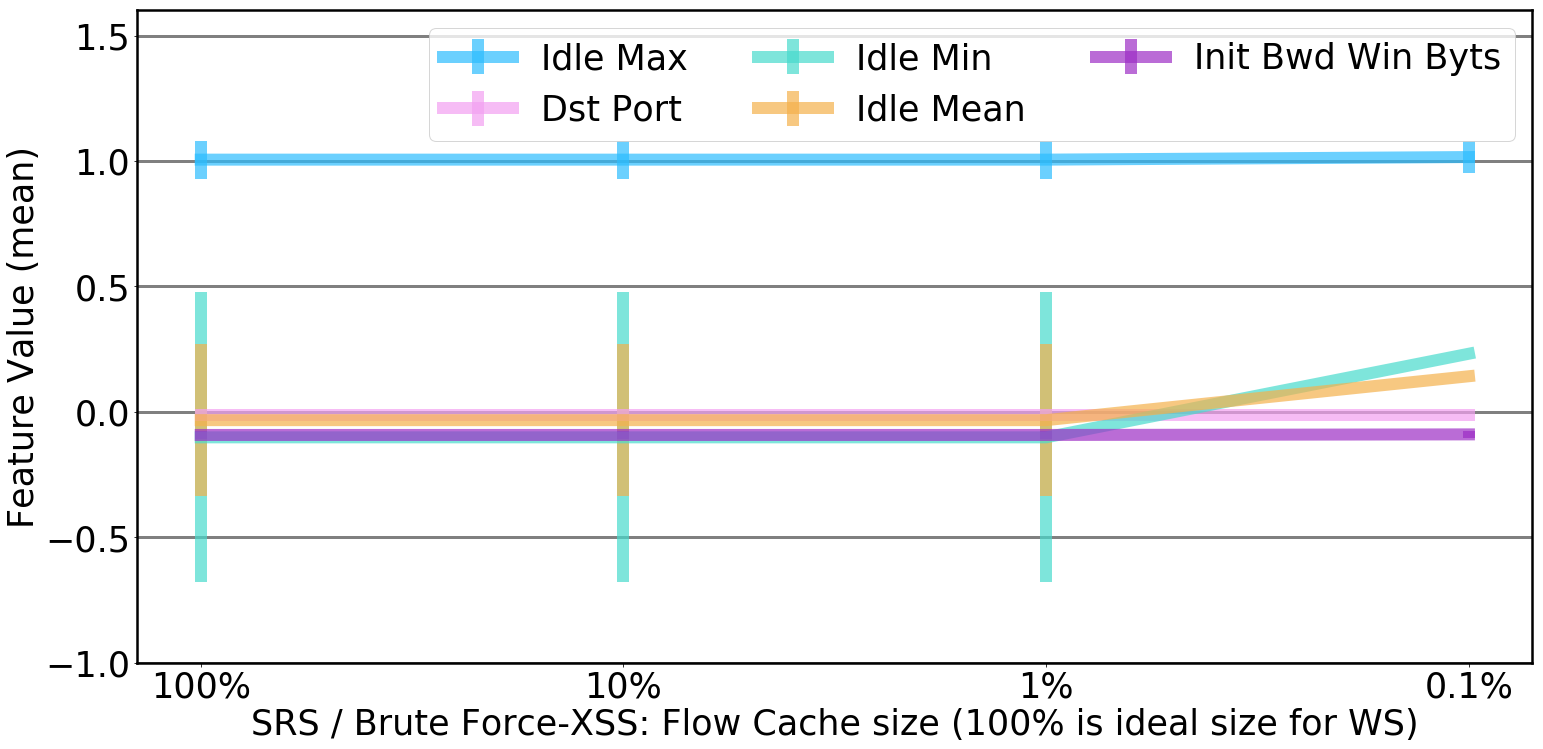

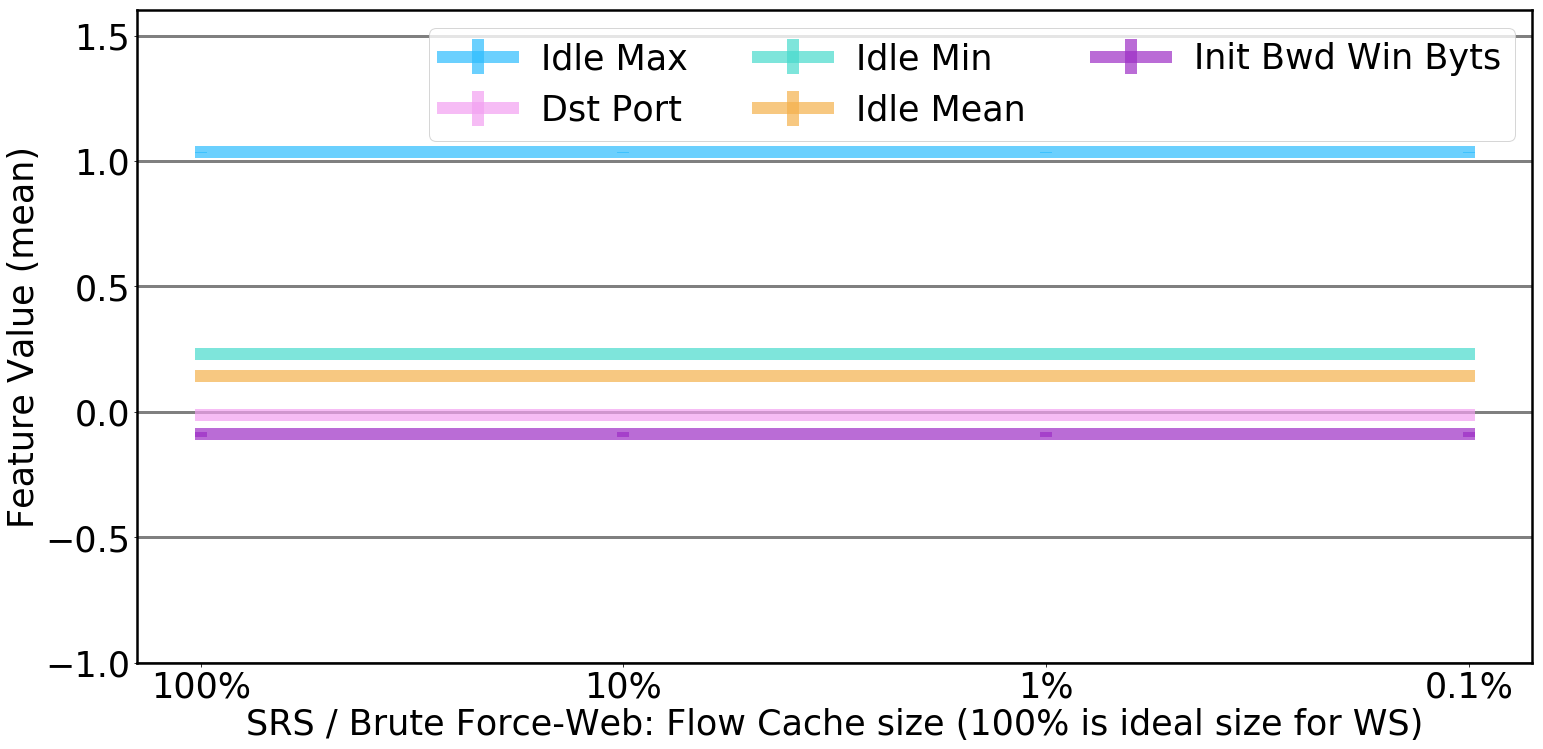

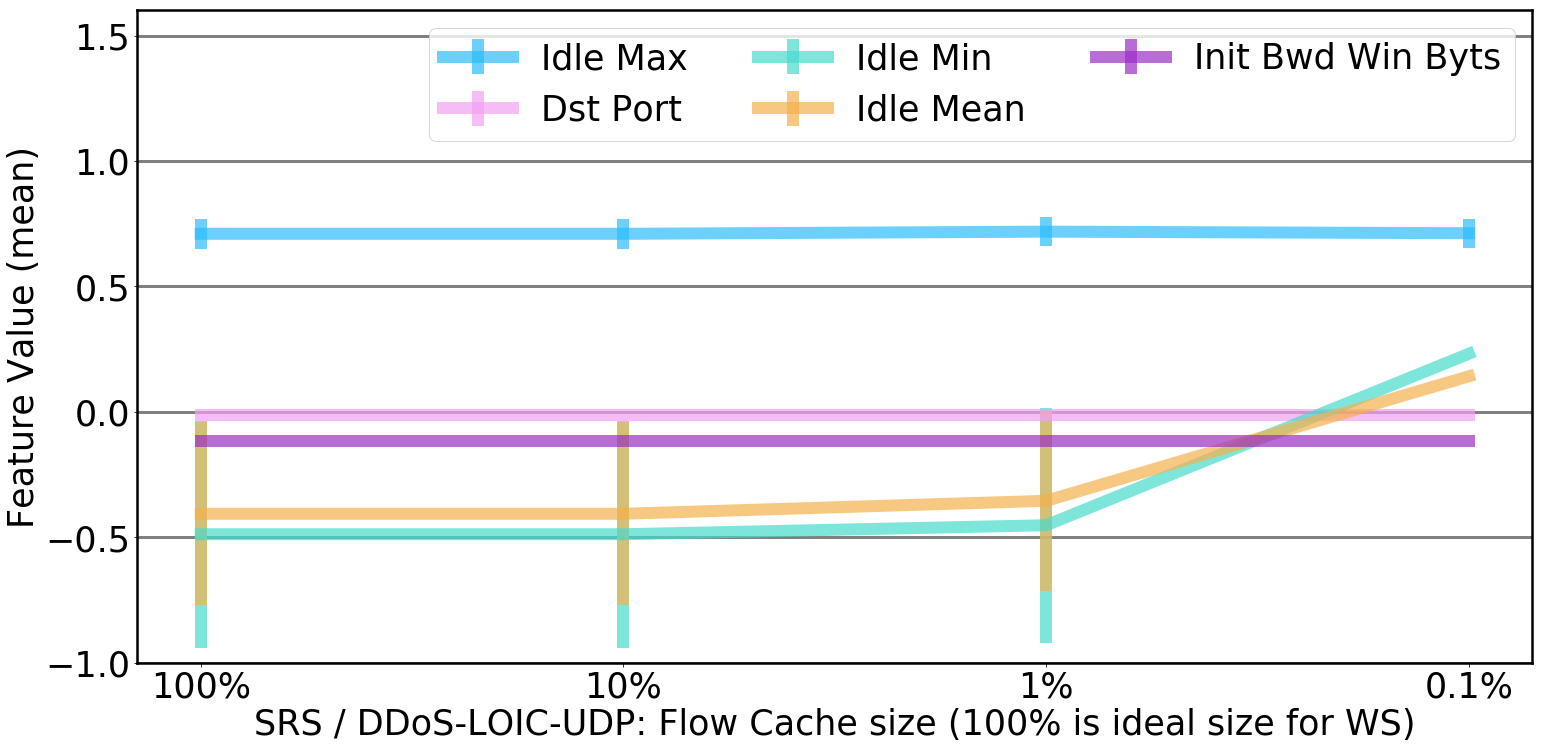

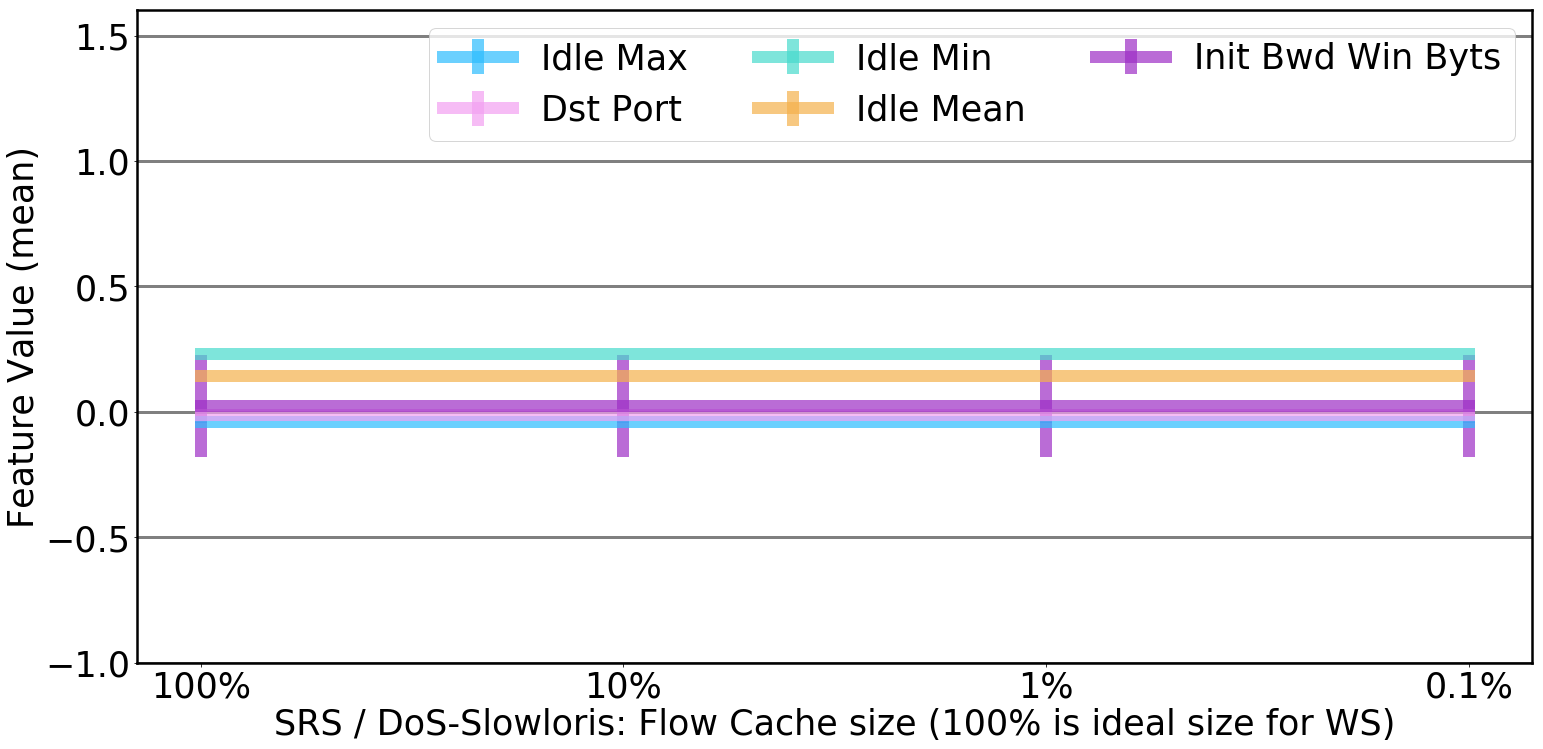

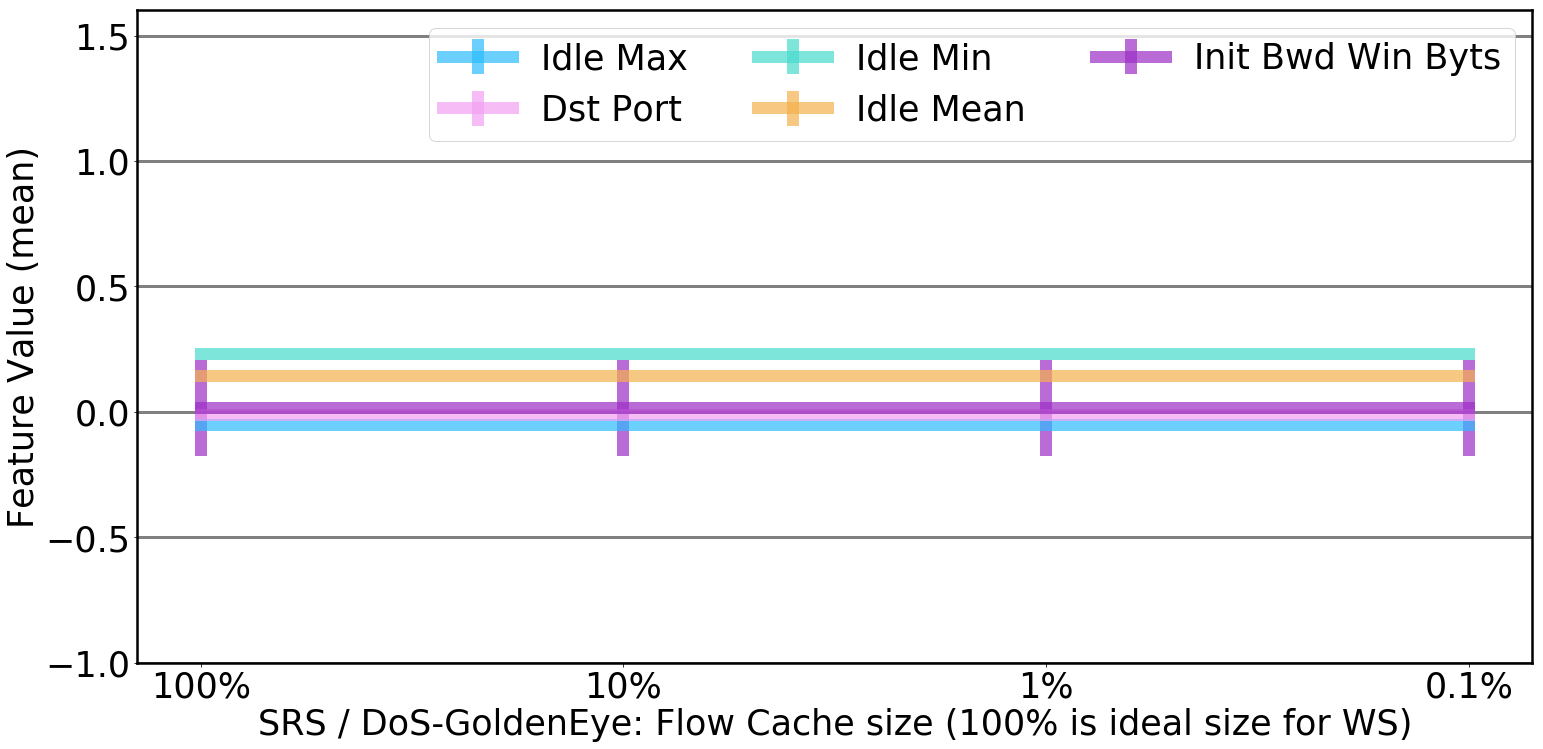

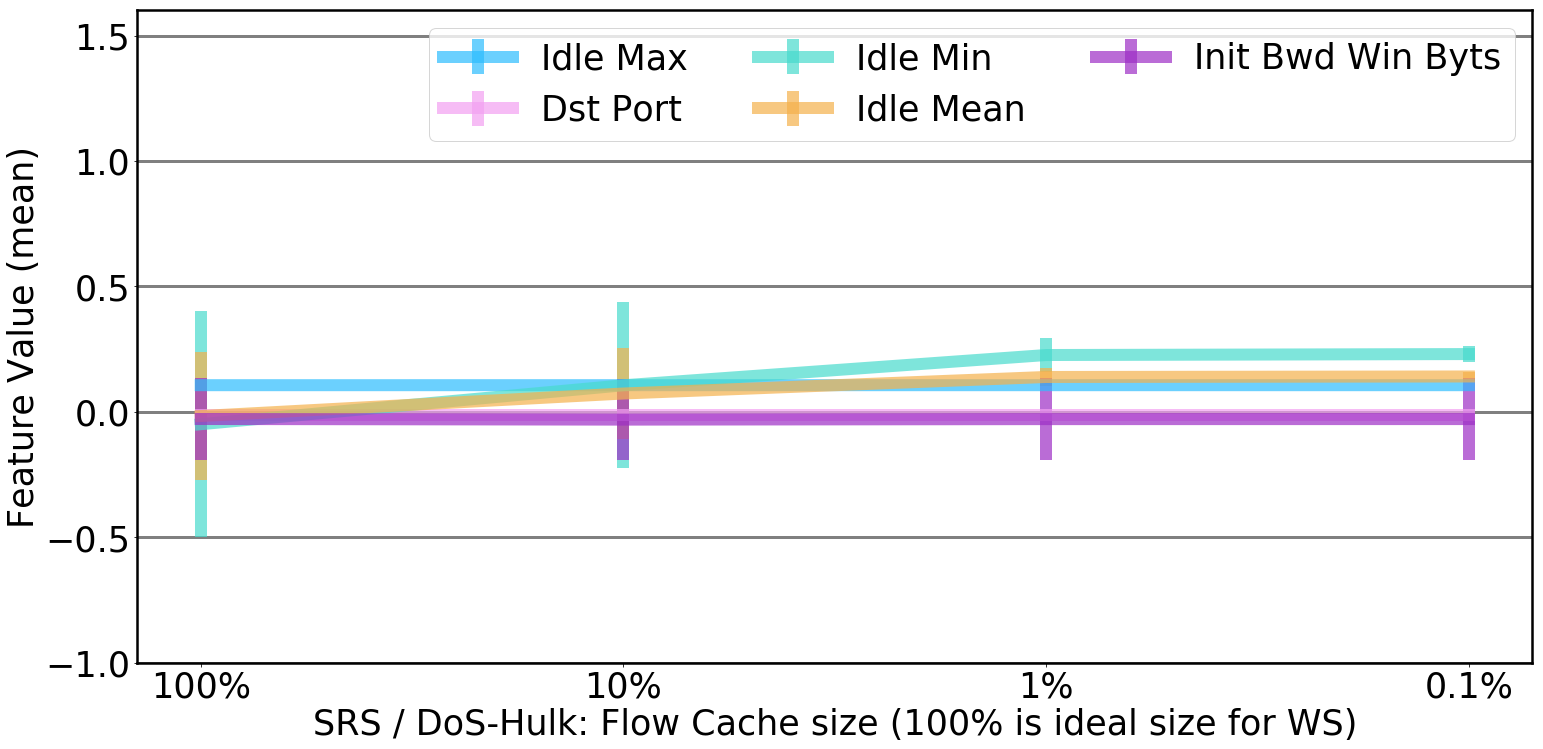

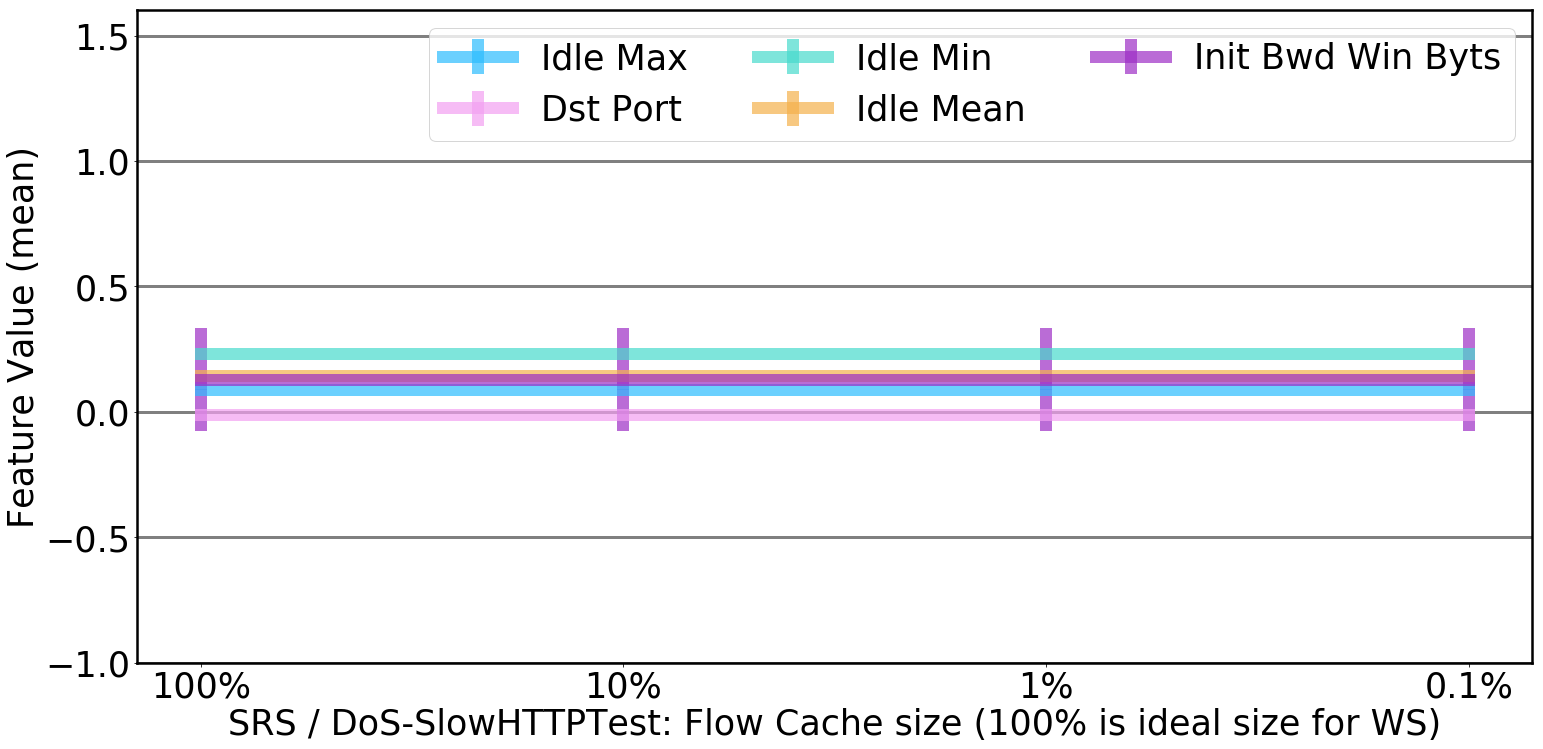

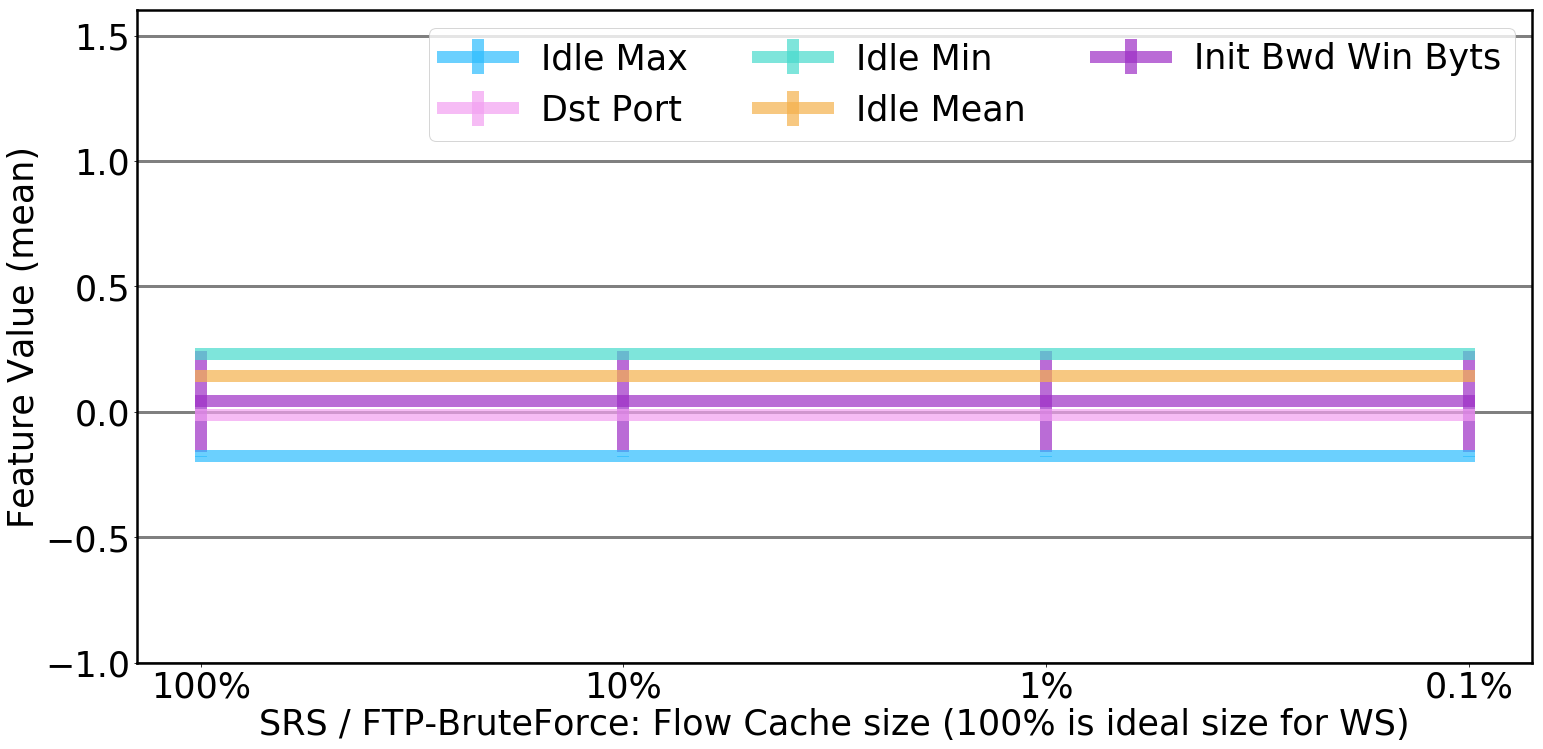

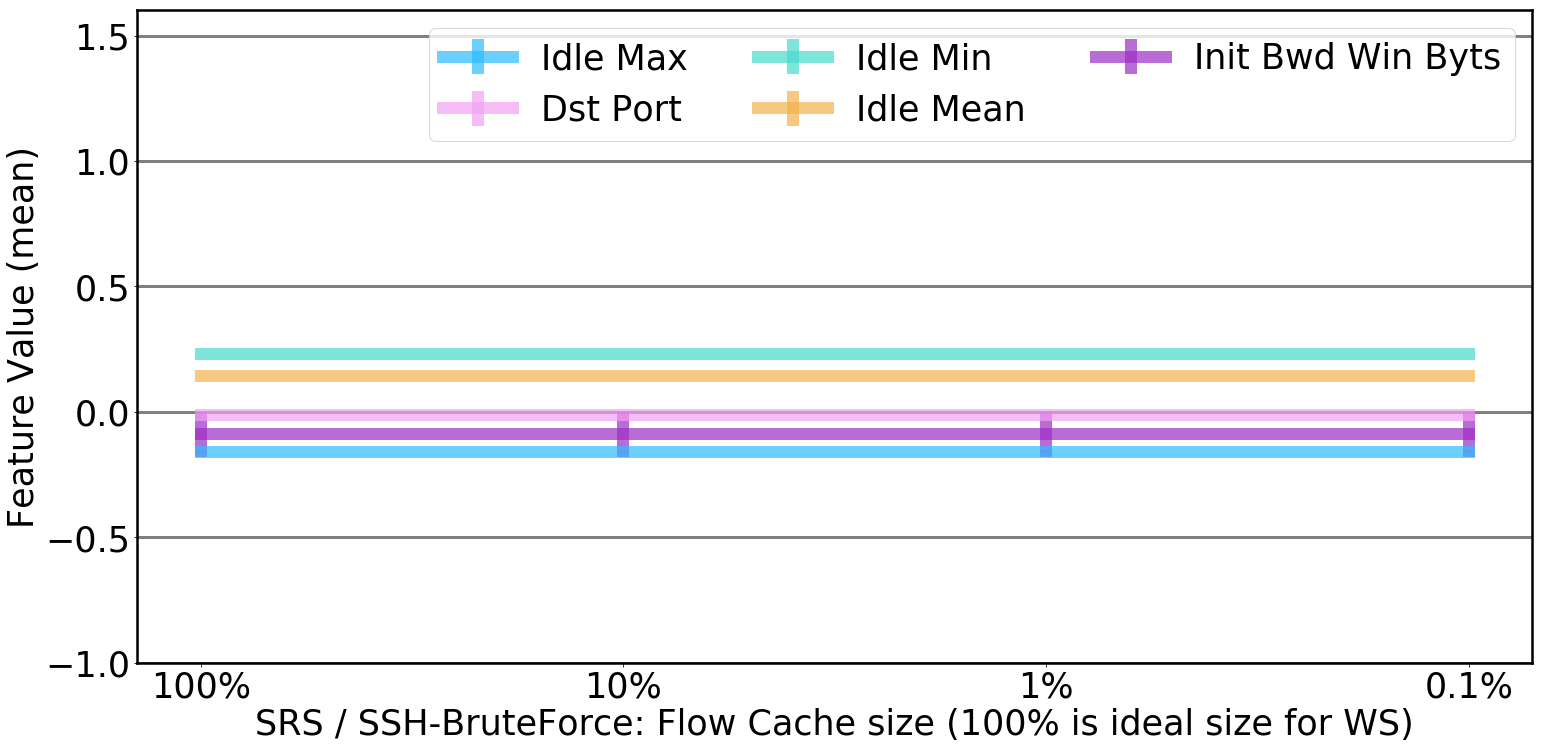

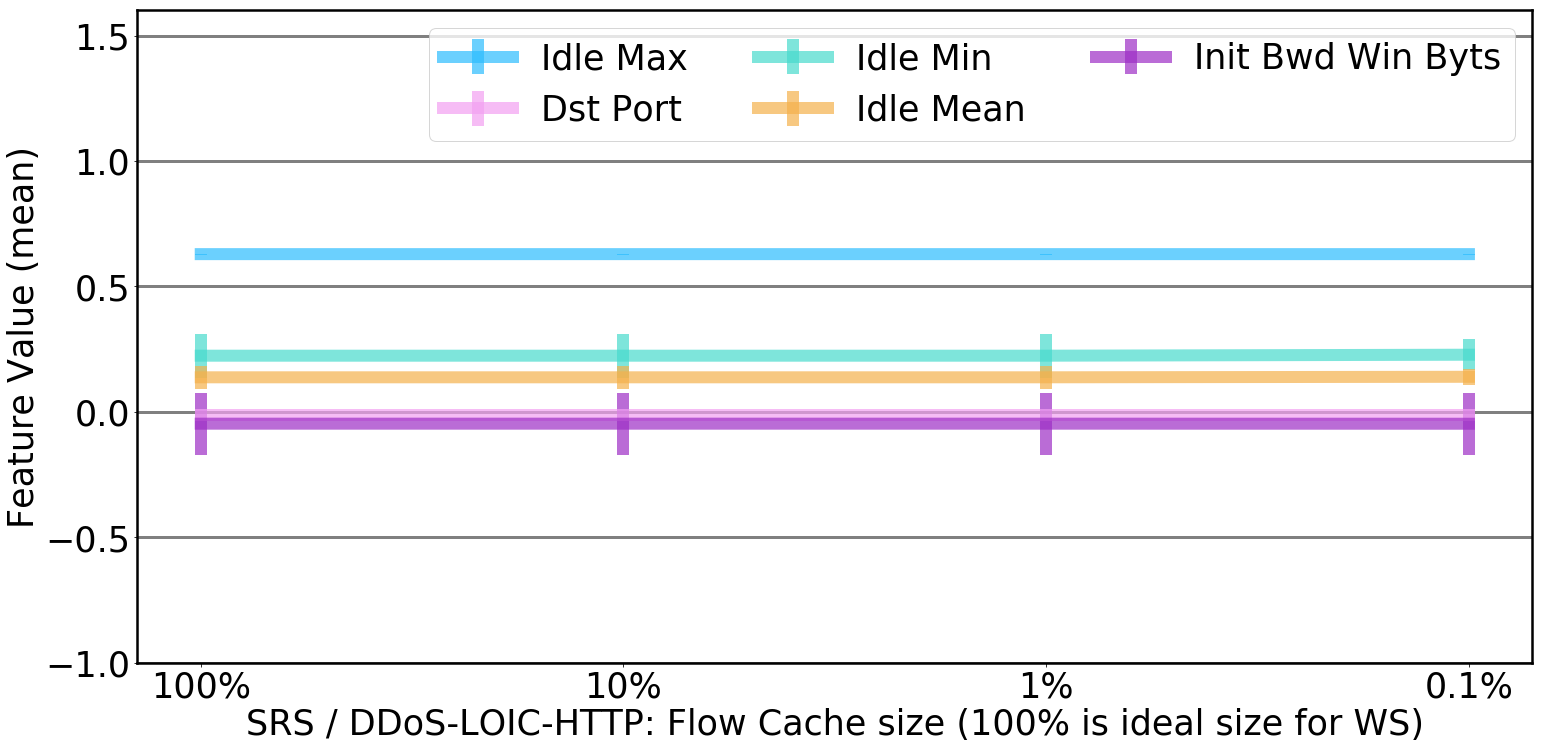

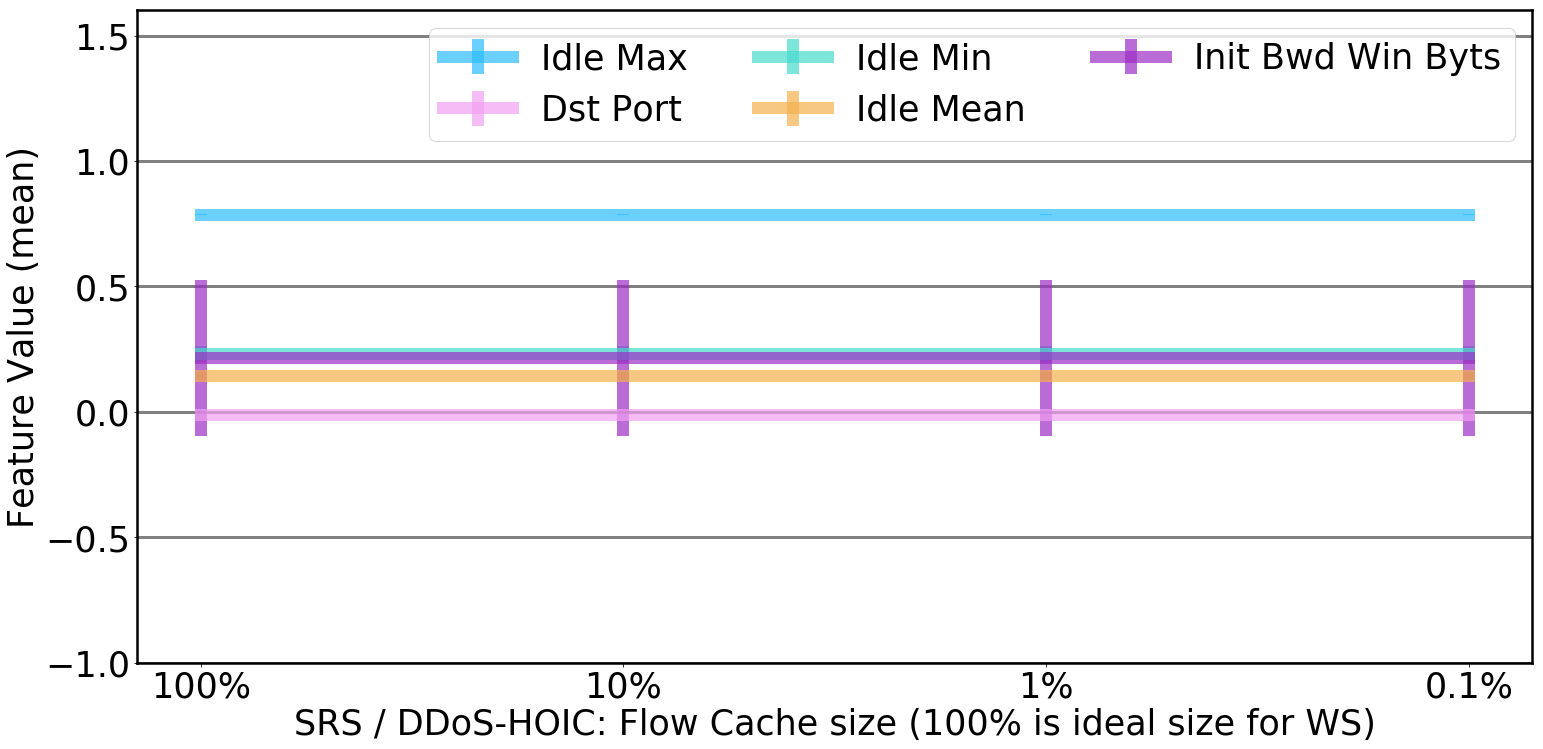

In [13]:
sr_dir = 'SR_0.1'
root = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/{}/'.format(sr_dir) 

for i,sampler_dir in enumerate(sorted(glob(join(root,'*_l')))):
    plot_feature_trend_for_sampler(sampler_dir)    

/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_1.0/FFS_(8,16,40)_l/c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25/log/10fold_0.pkl


  0%|          | 0/12 [00:00<?, ?it/s]

-------/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_1.0/FFS_(8,16,40)_l--------


100%|██████████| 12/12 [04:43<00:00, 23.65s/it]


/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_1.0/SFS_SI_95.33_l/c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25/log/10fold_0.pkl


  0%|          | 0/12 [00:00<?, ?it/s]

-------/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_1.0/SFS_SI_95.33_l--------


100%|██████████| 12/12 [04:06<00:00, 20.58s/it]


/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_1.0/SGS_e_1_l/c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25/log/10fold_0.pkl


  0%|          | 0/12 [00:00<?, ?it/s]

-------/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_1.0/SGS_e_1_l--------


100%|██████████| 12/12 [06:15<00:00, 31.28s/it]


/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_1.0/SRS_SI_100_l/c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25/log/10fold_0.pkl


  0%|          | 0/13 [00:00<?, ?it/s]

-------/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_1.0/SRS_SI_100_l--------


100%|██████████| 13/13 [04:53<00:00, 22.54s/it]


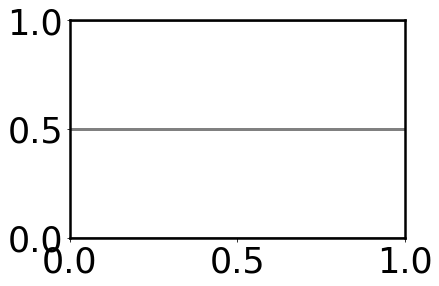

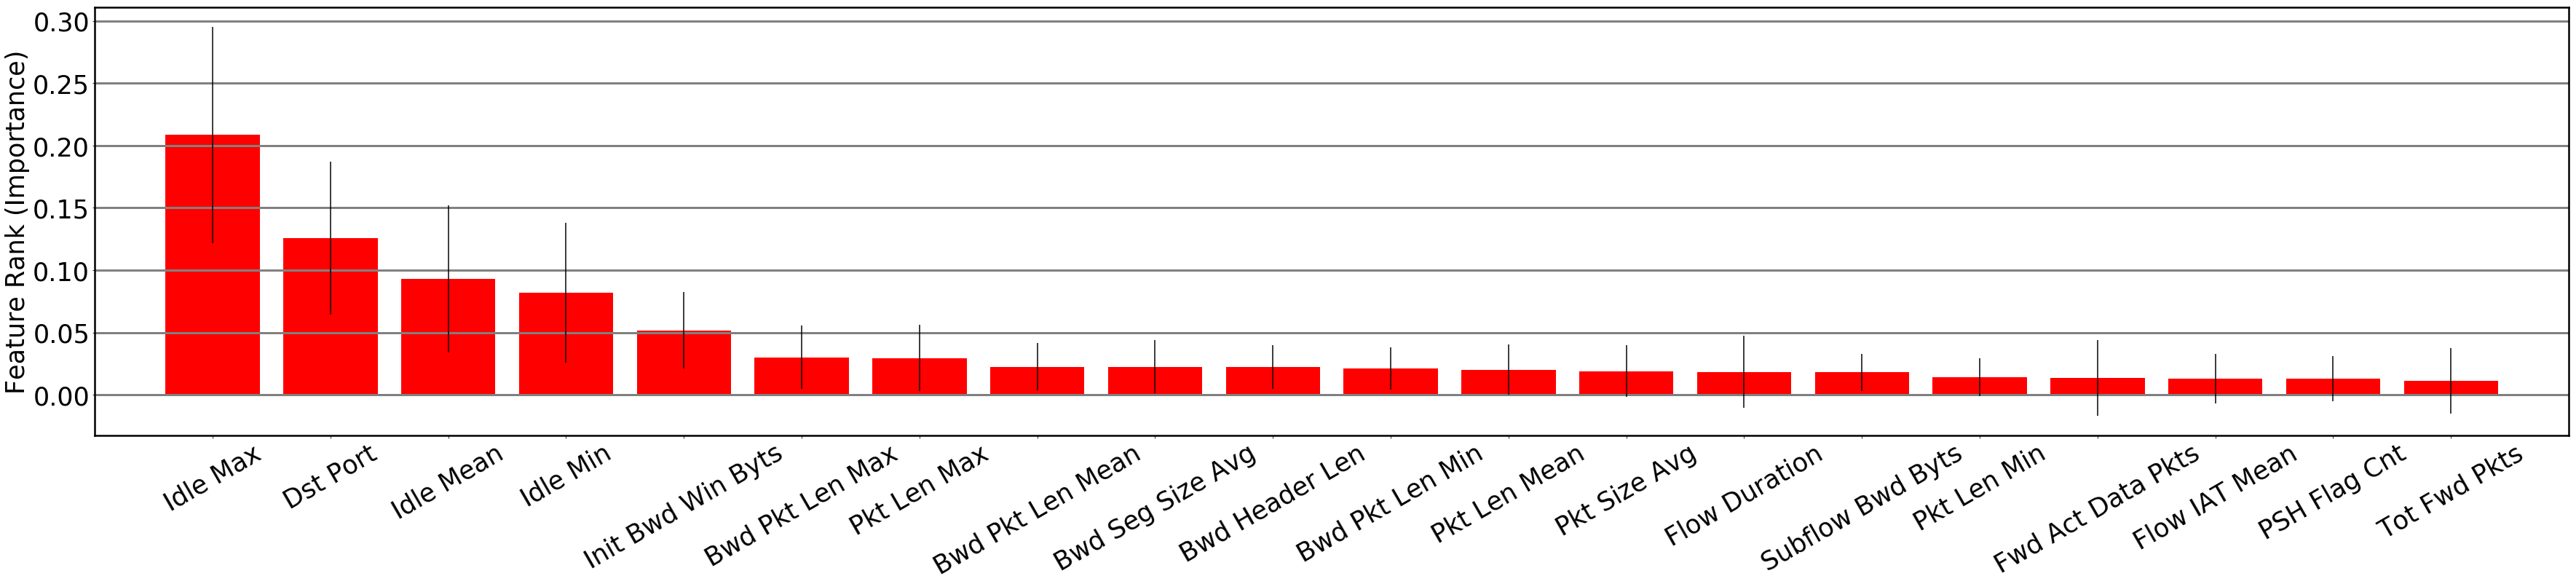

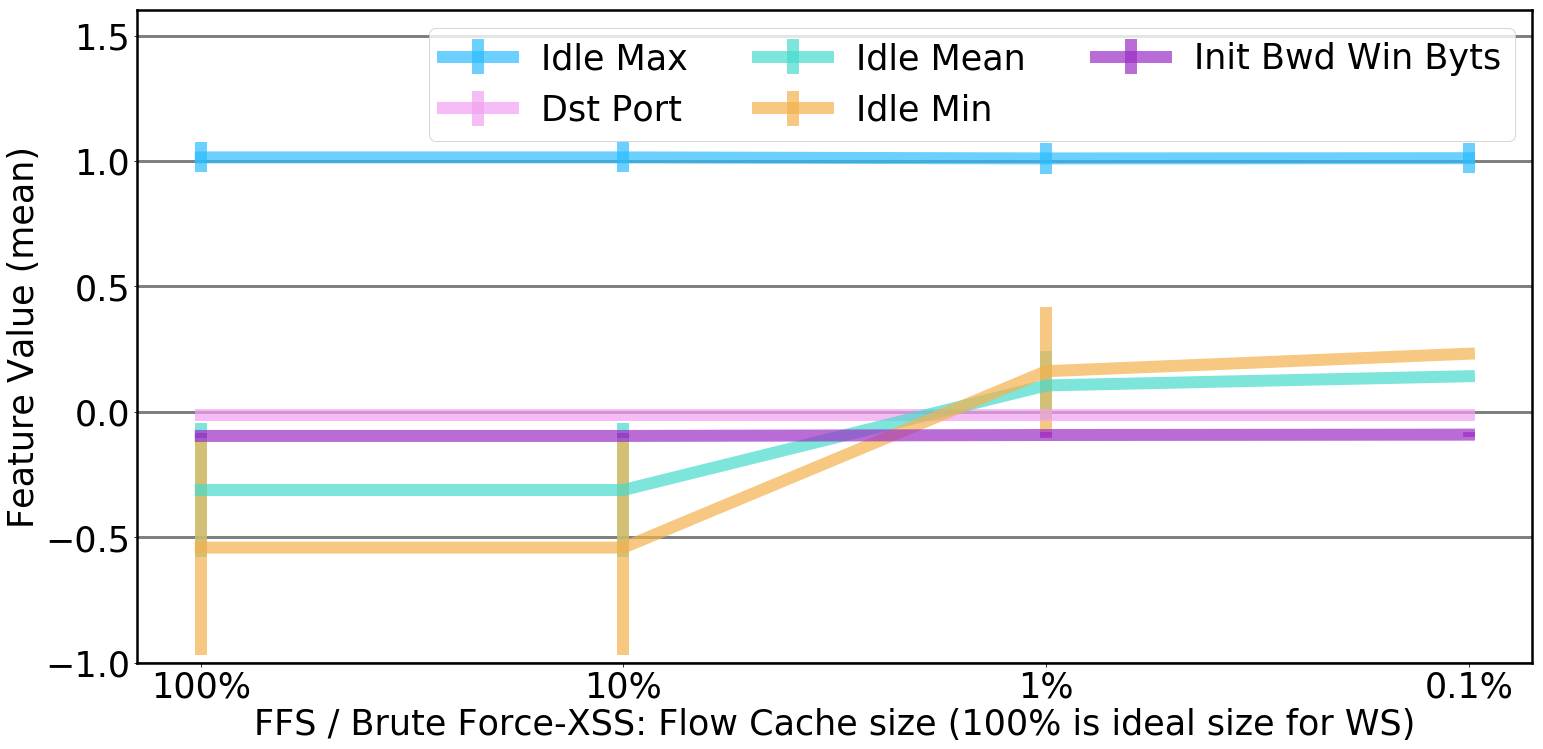

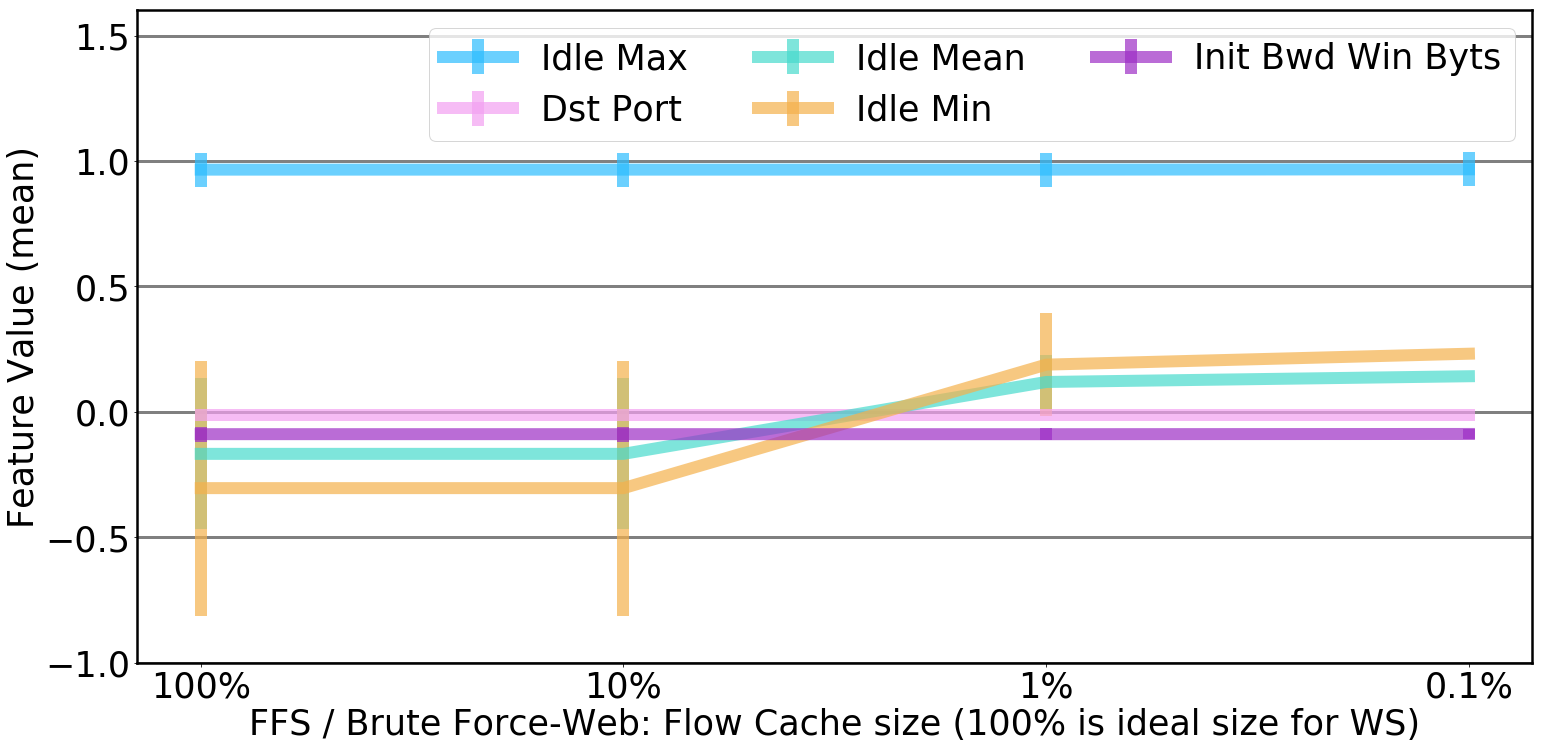

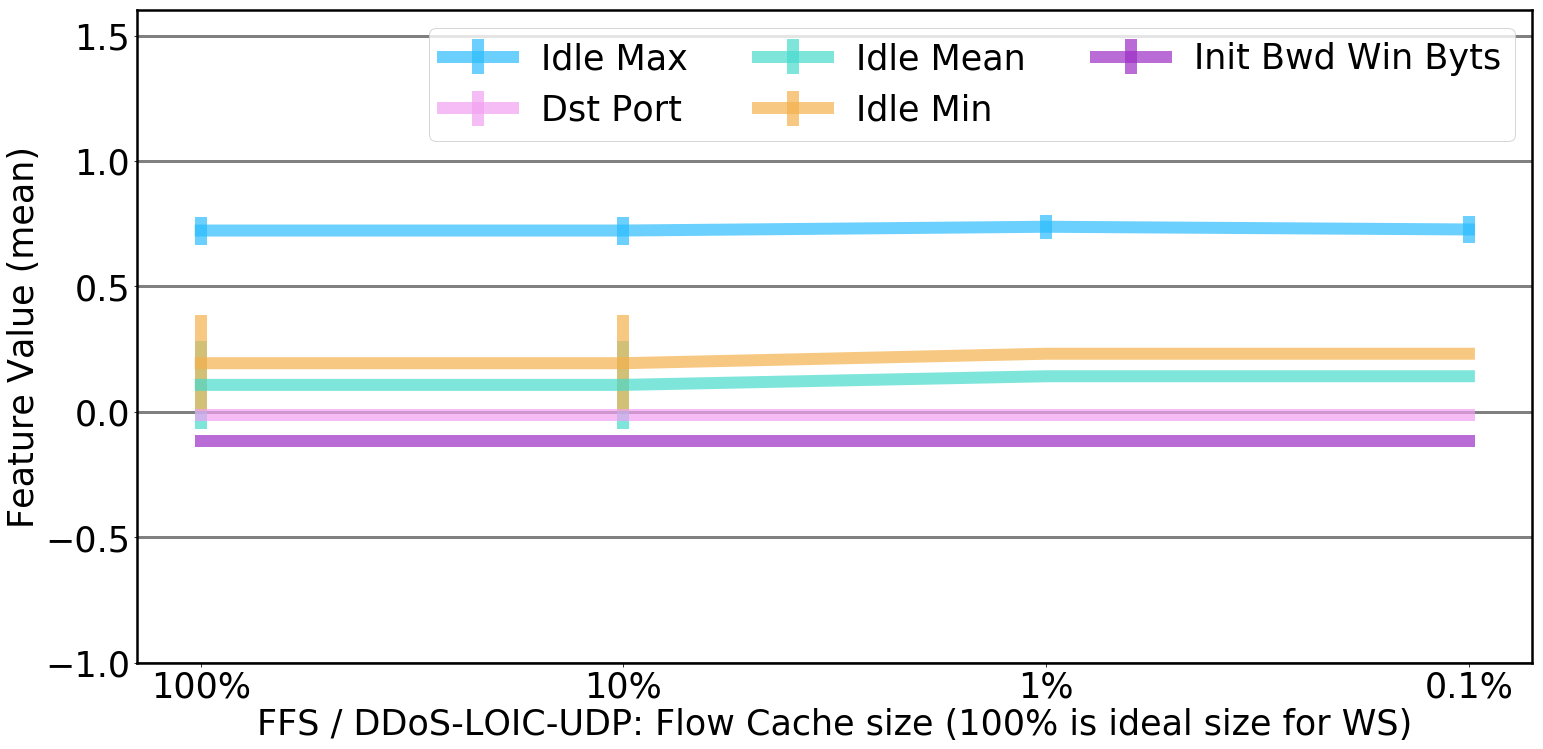

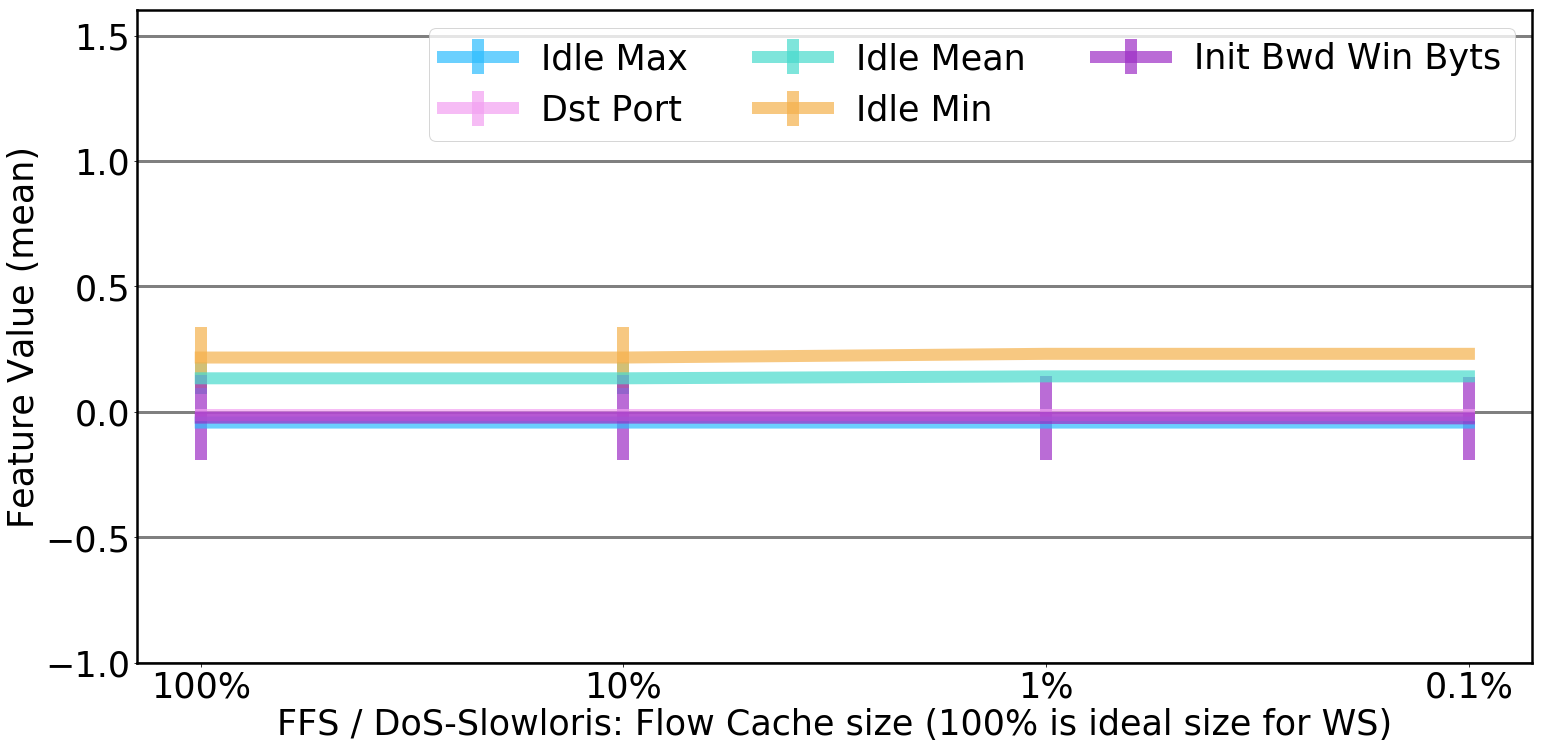

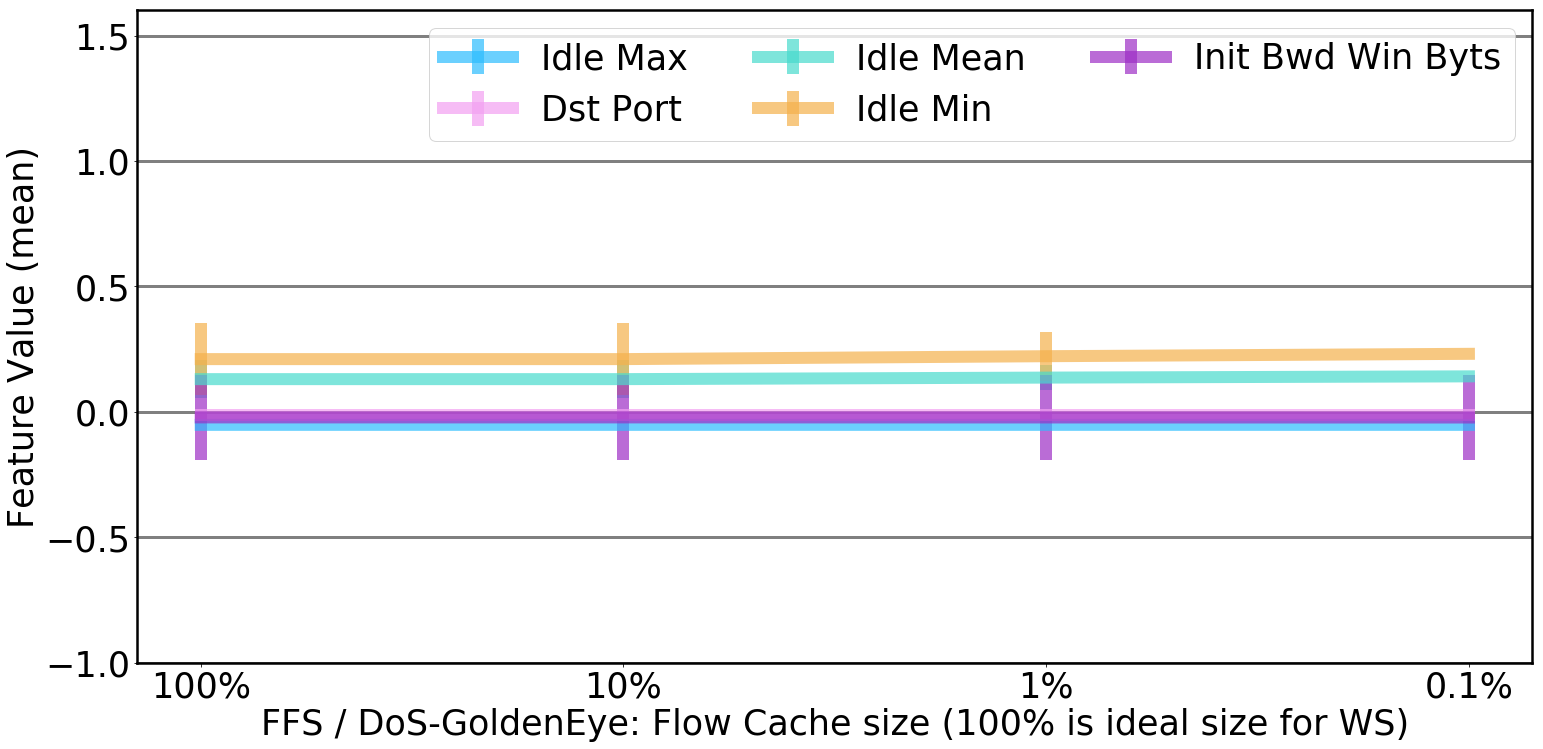

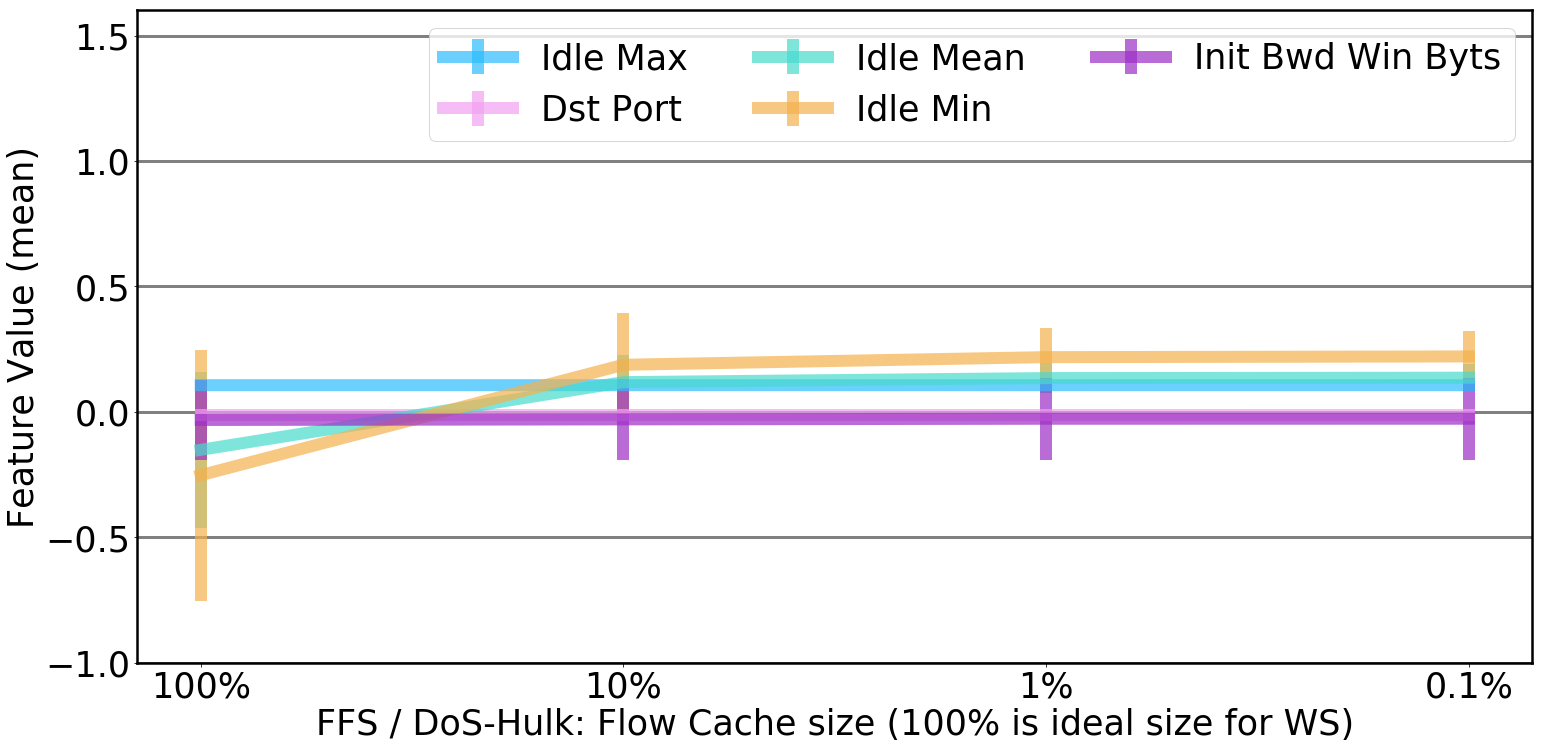

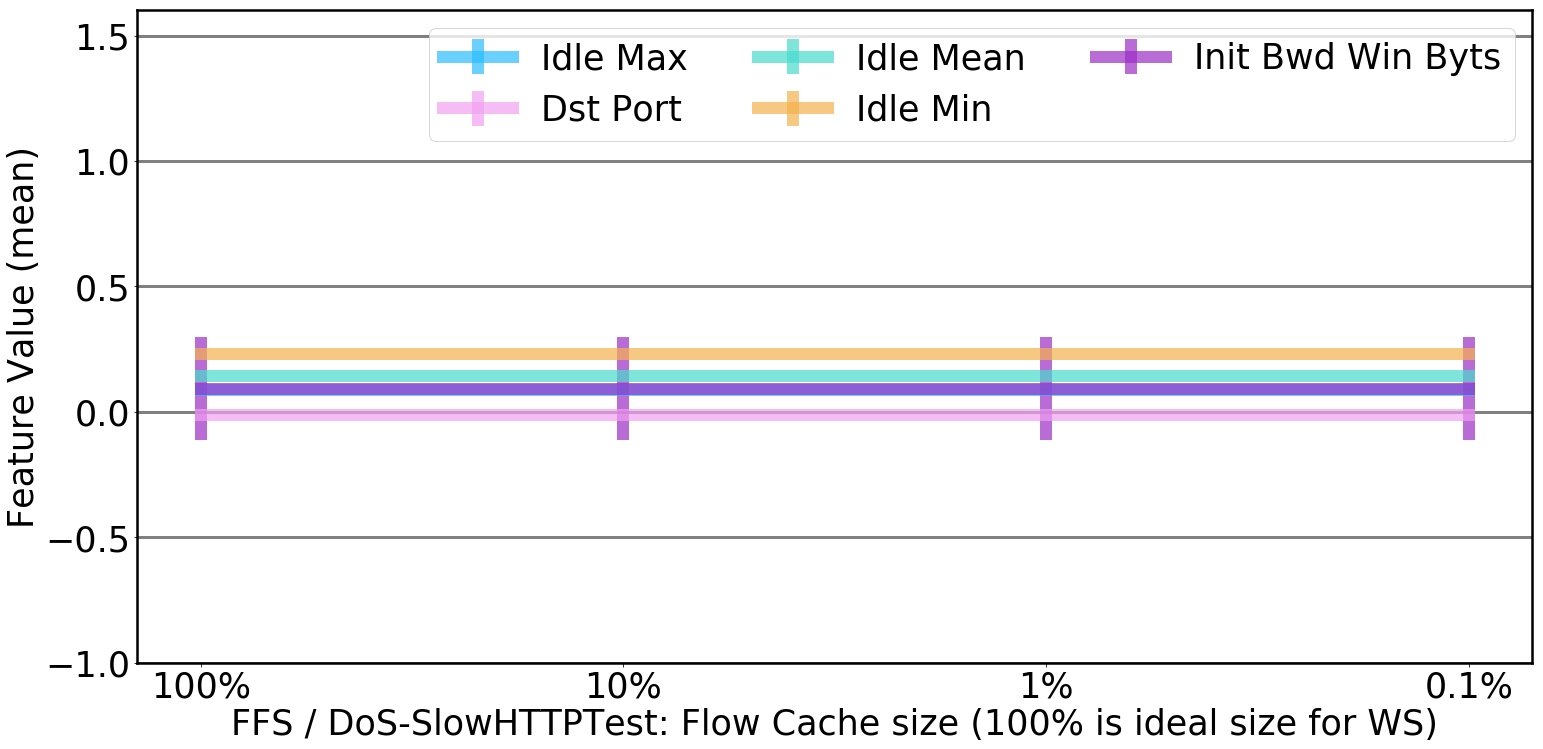

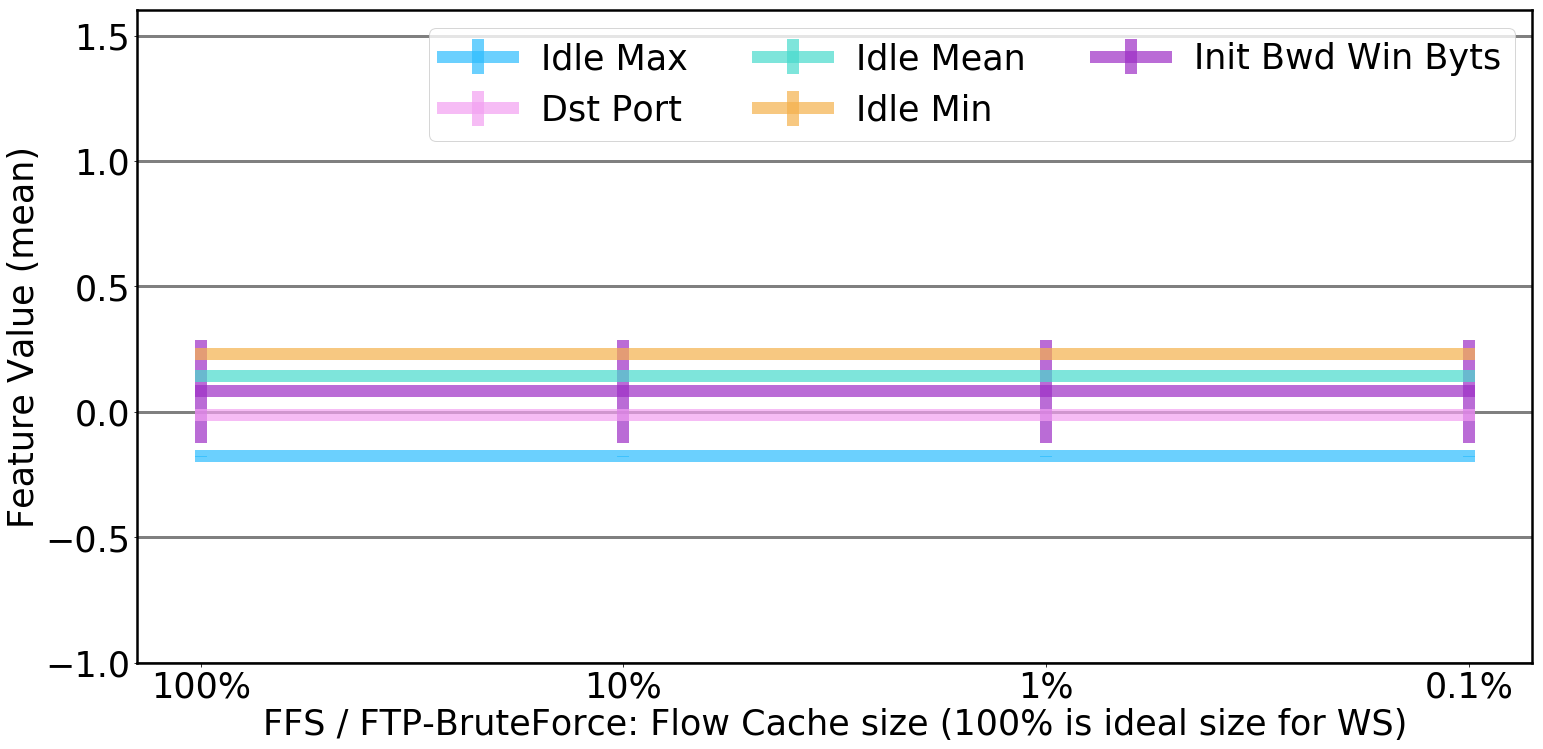

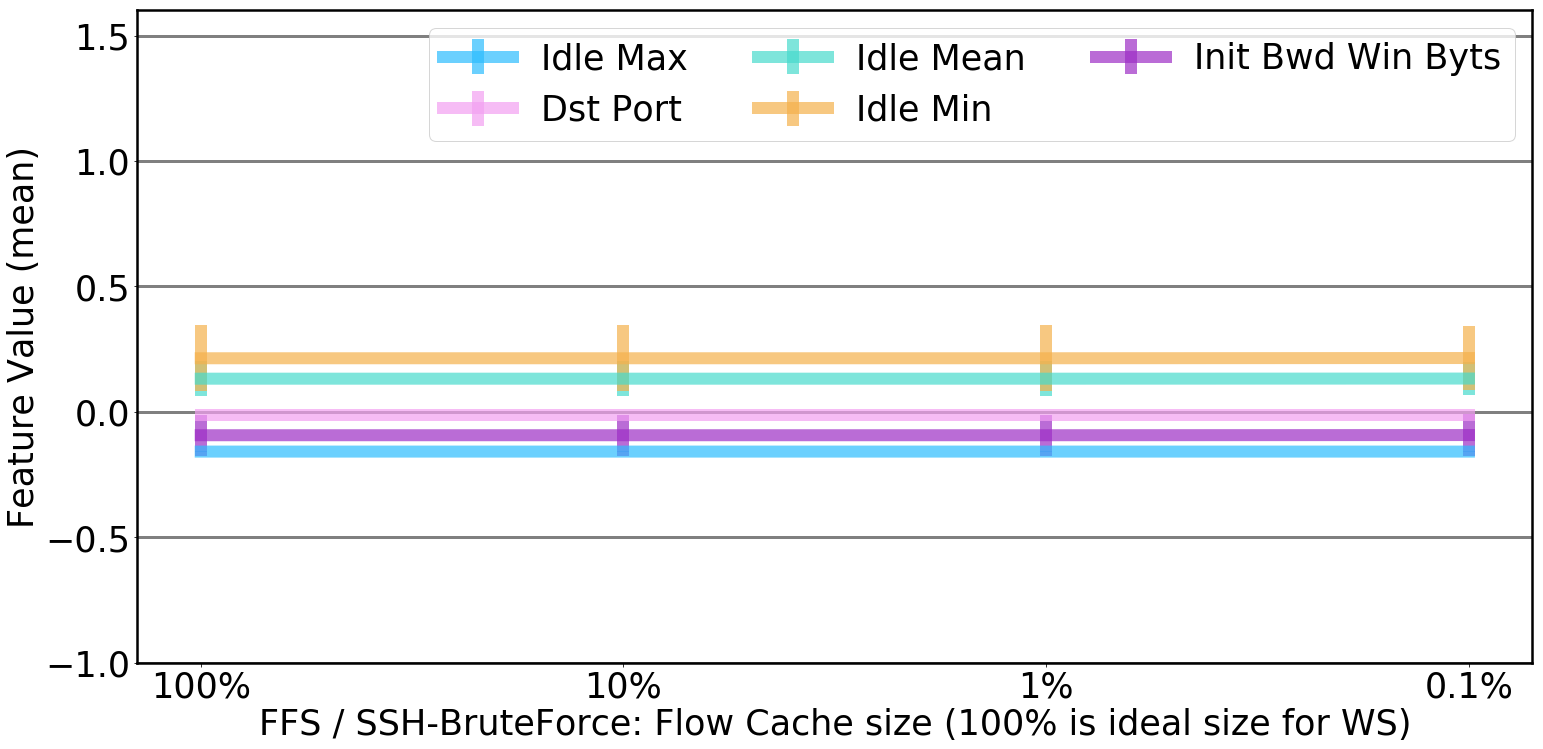

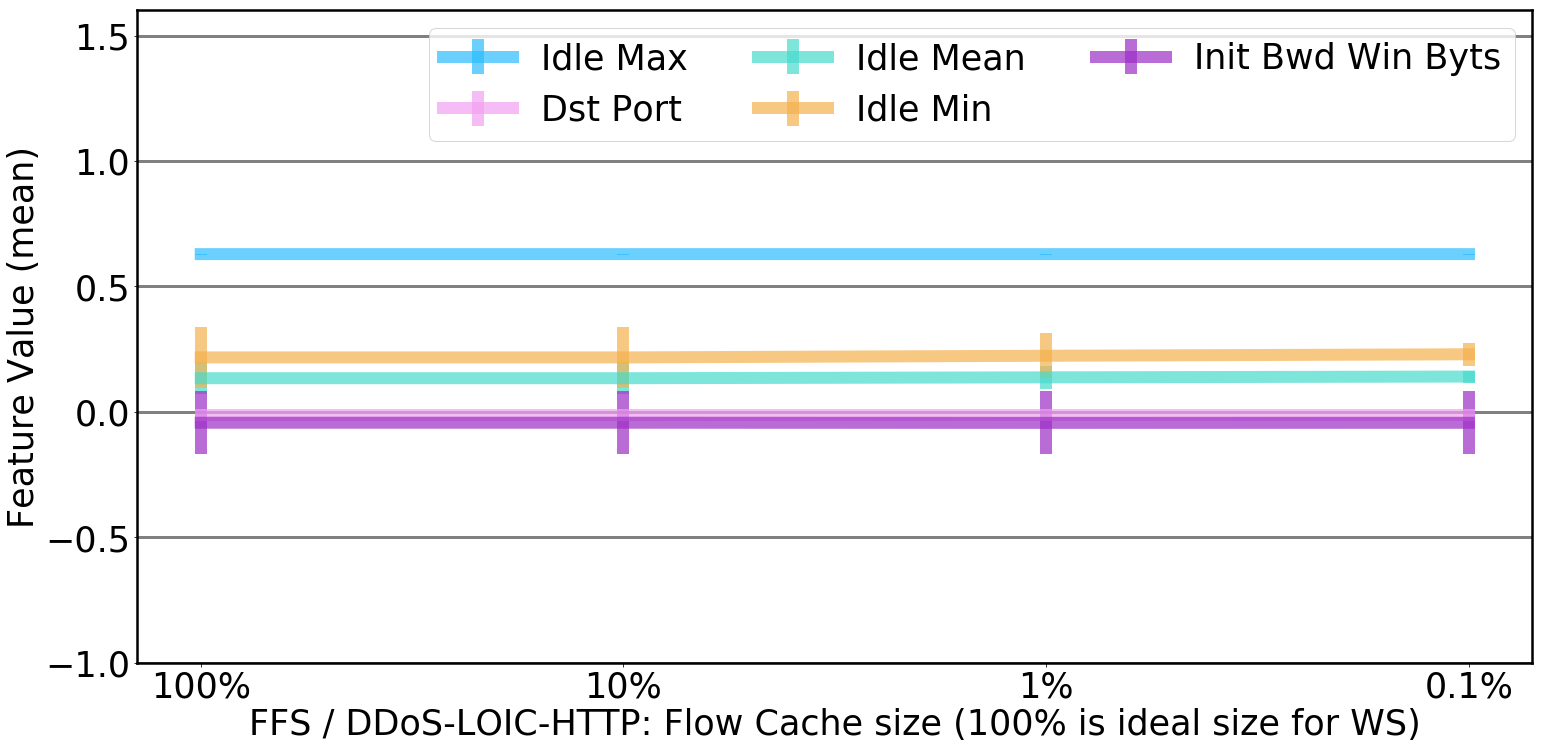

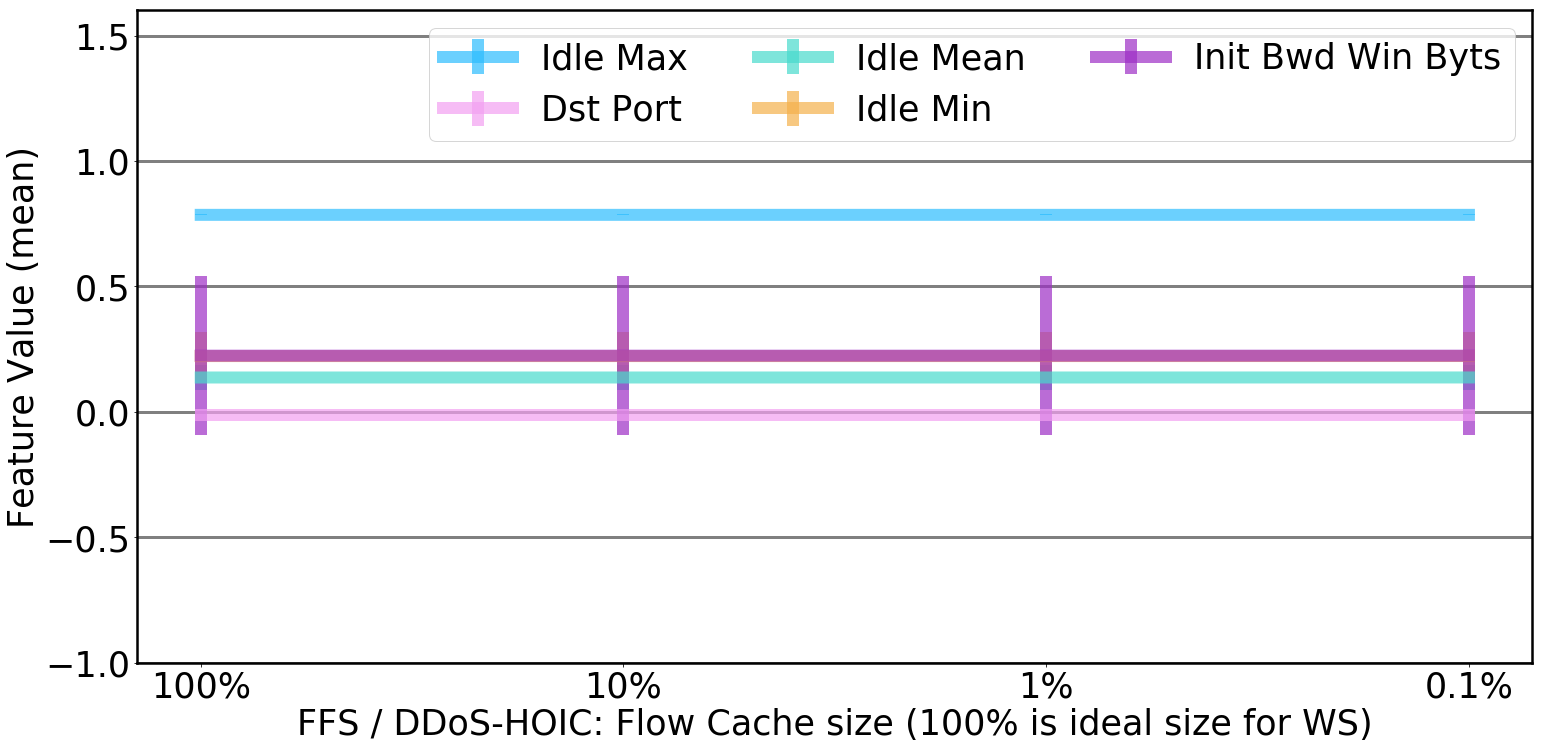

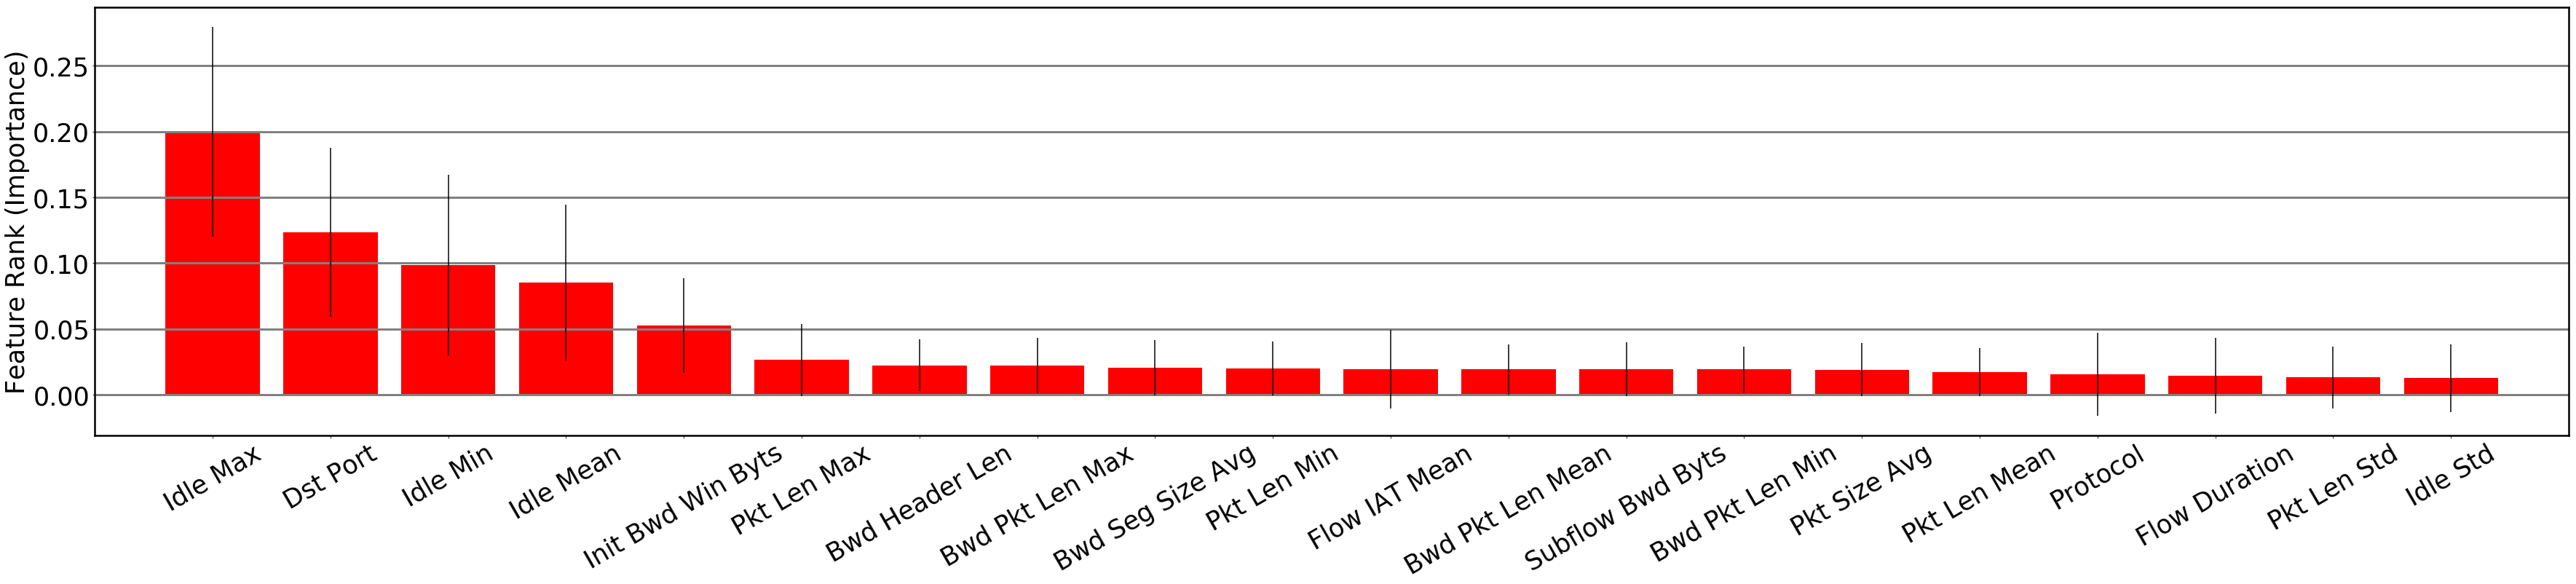

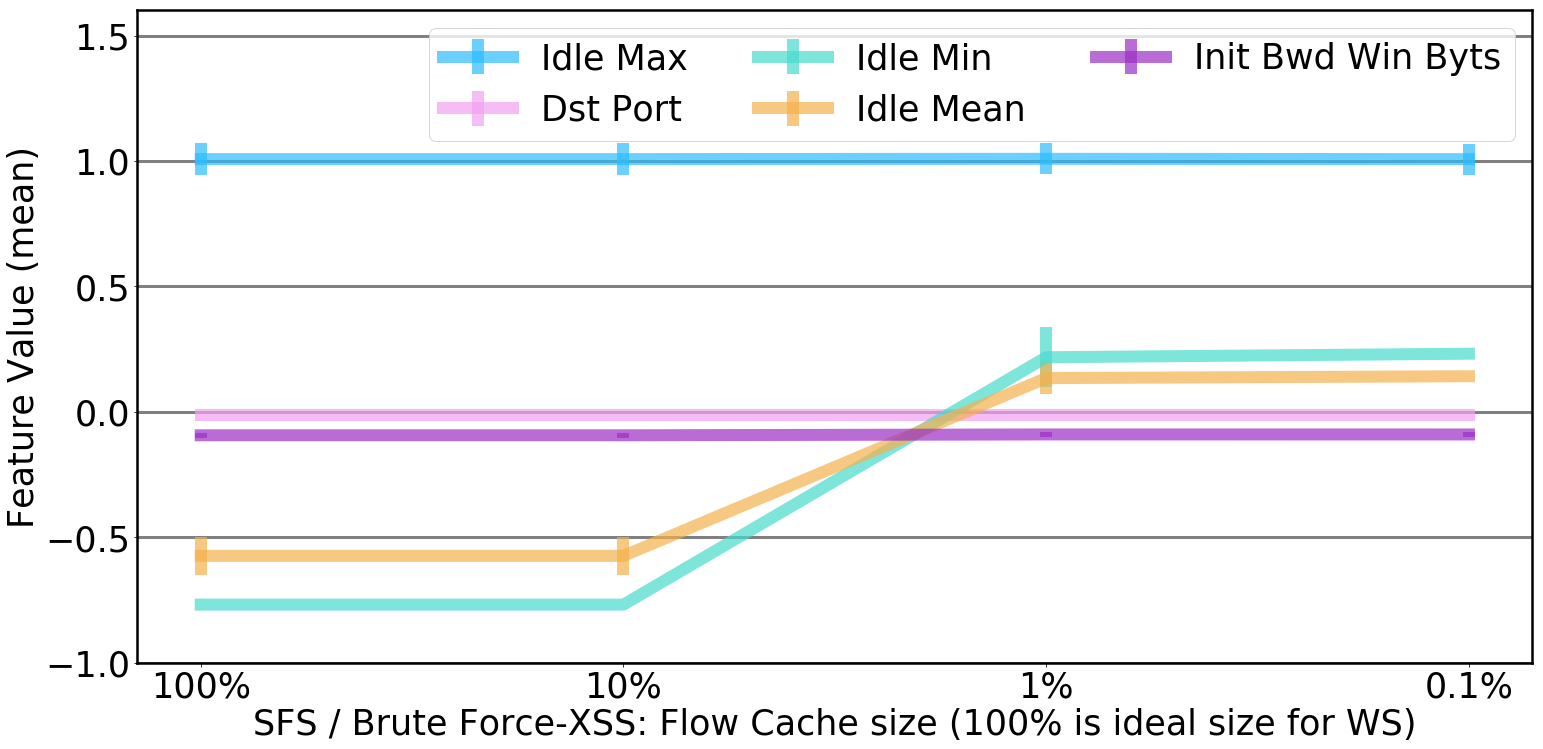

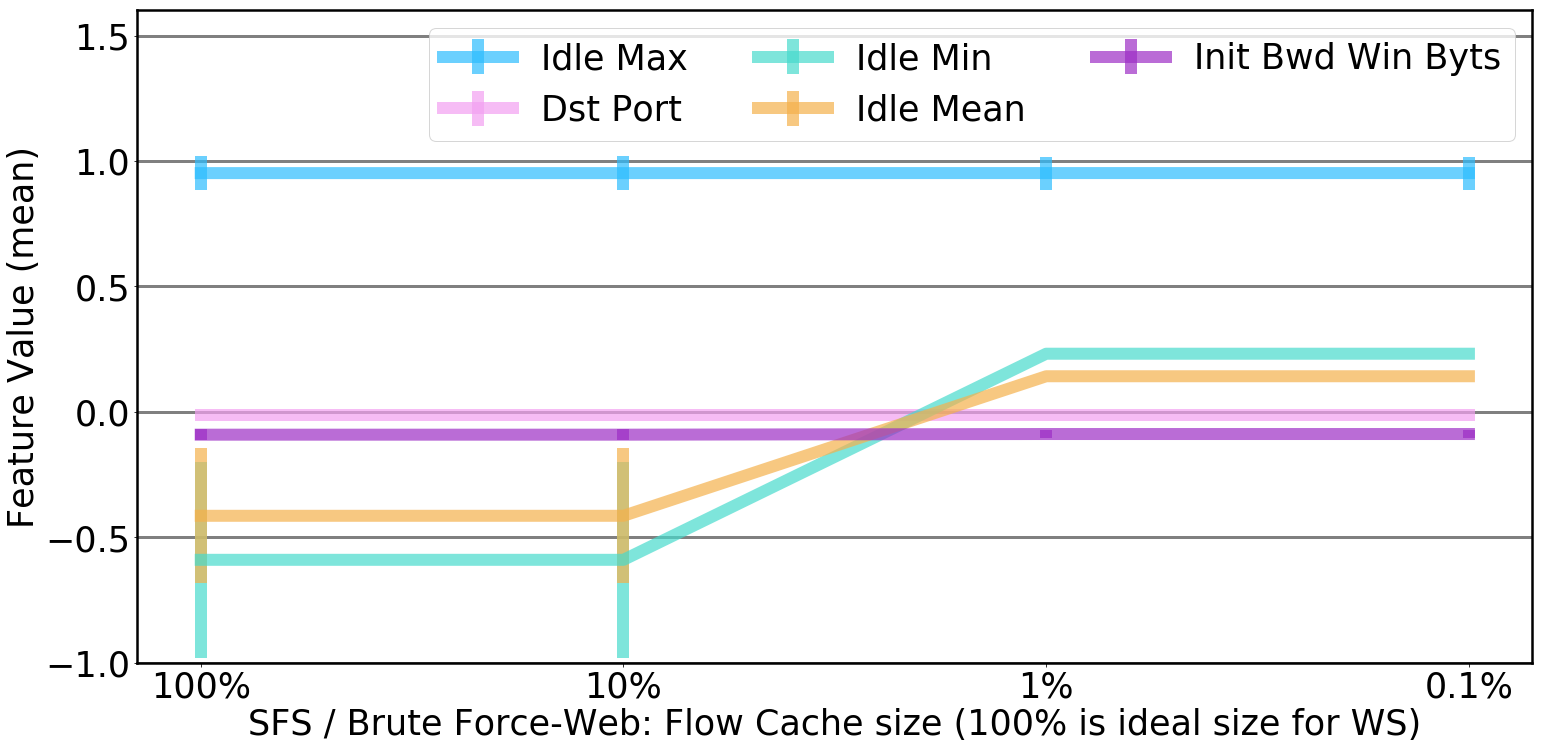

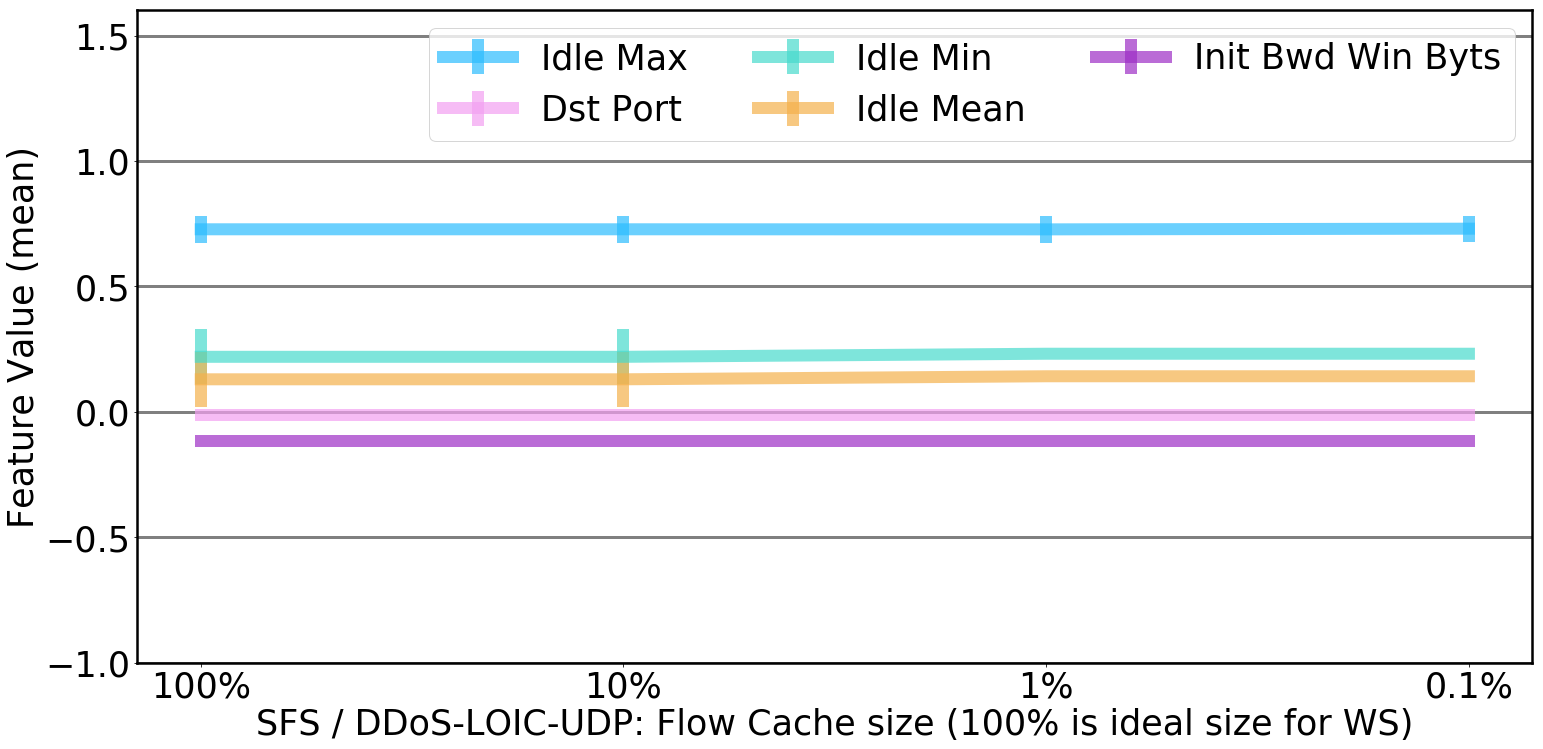

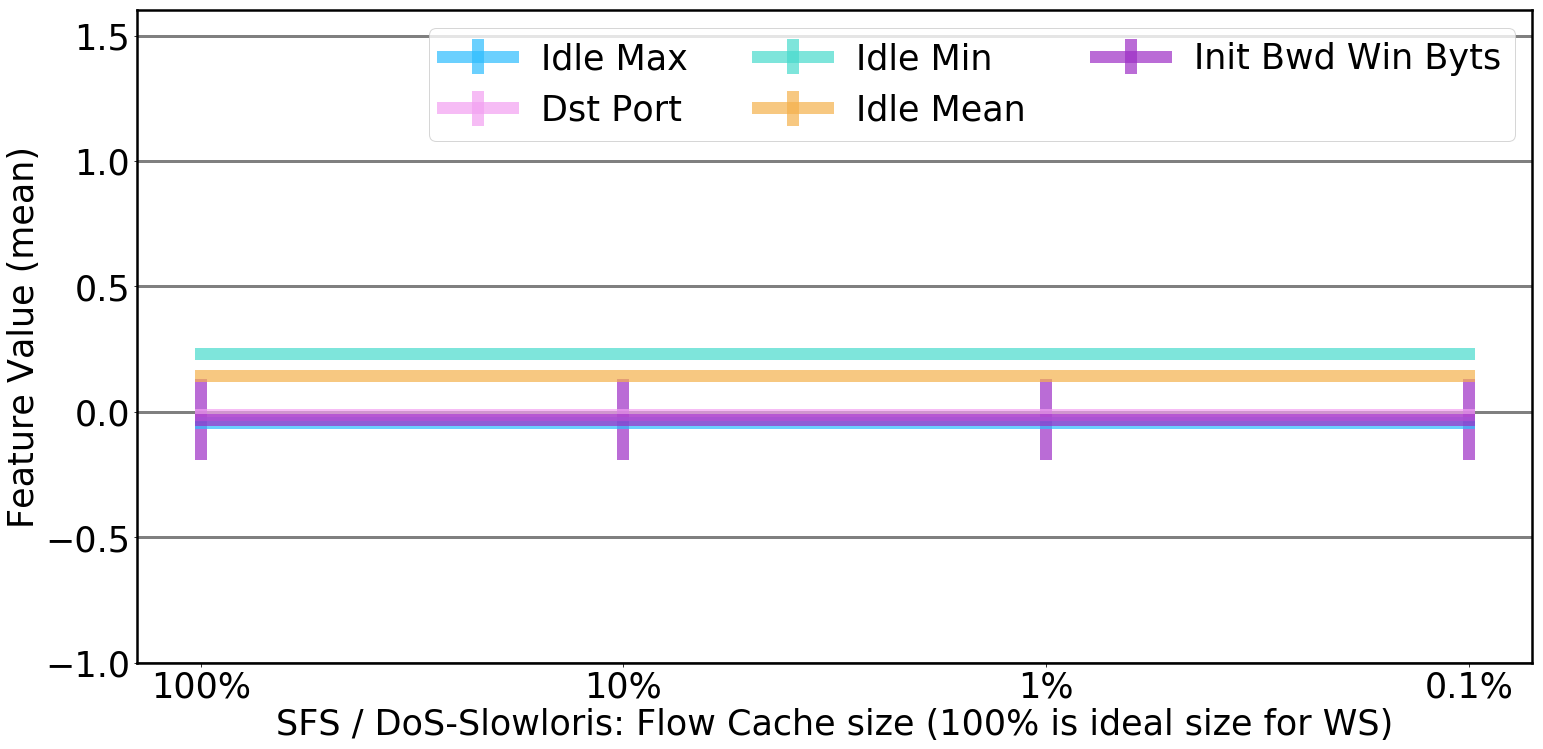

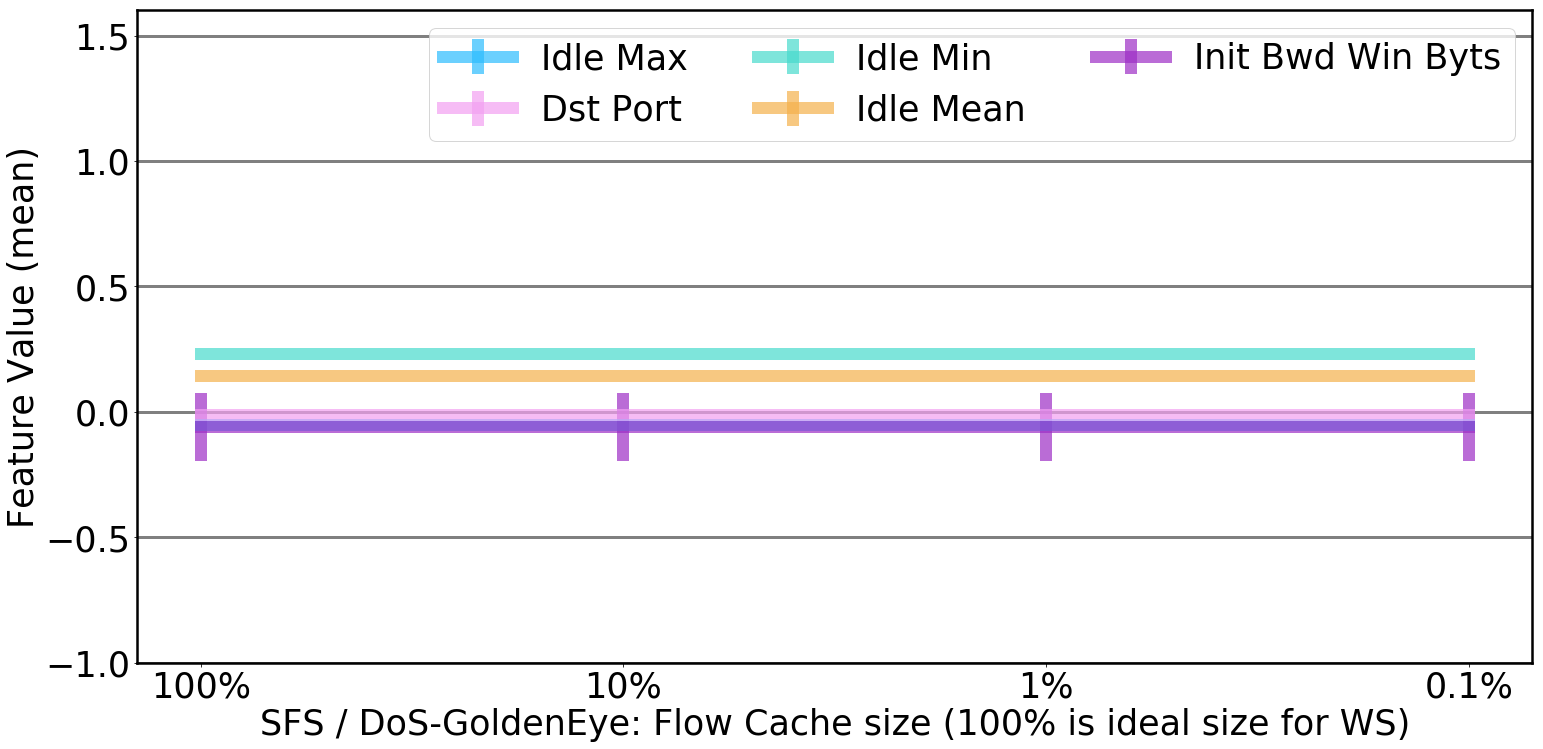

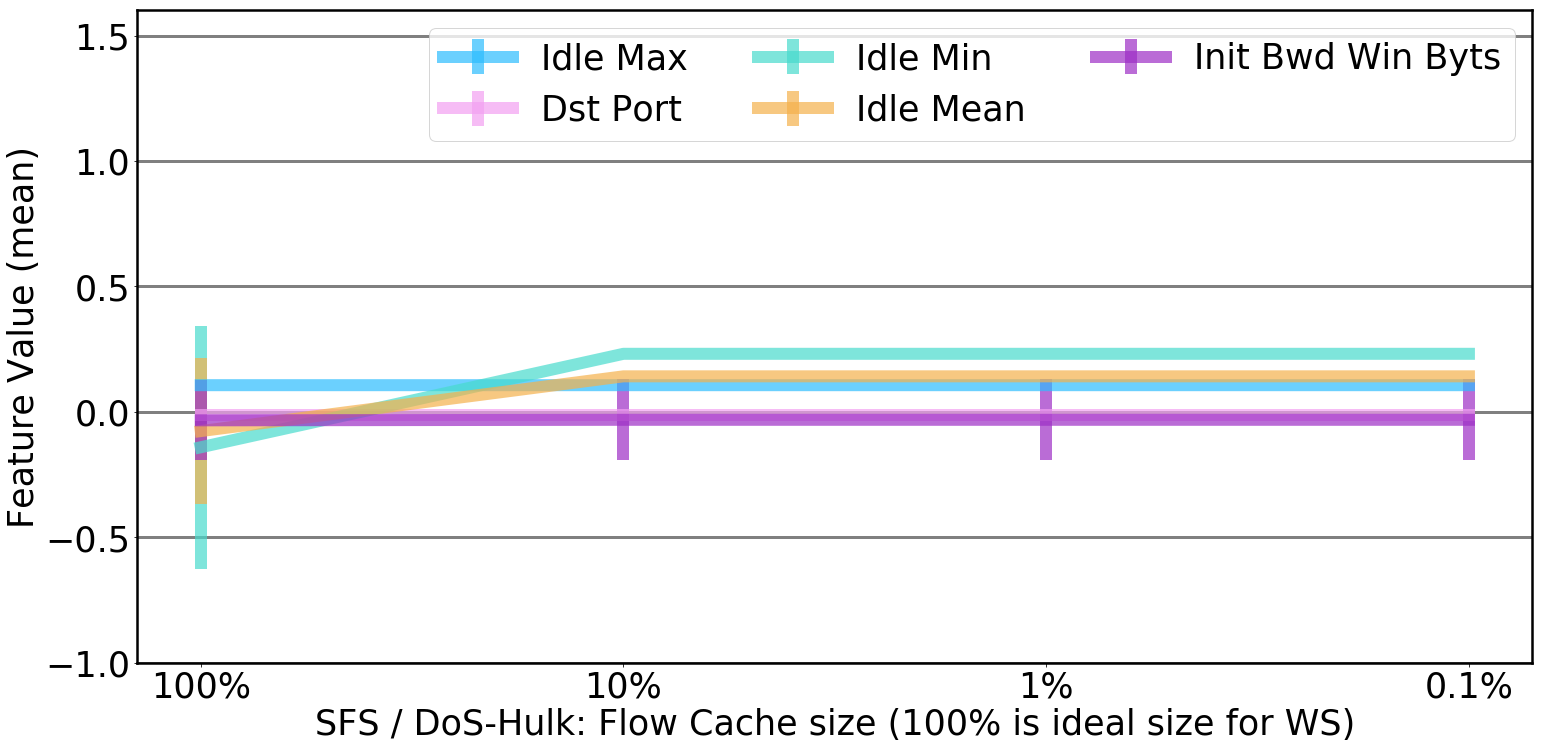

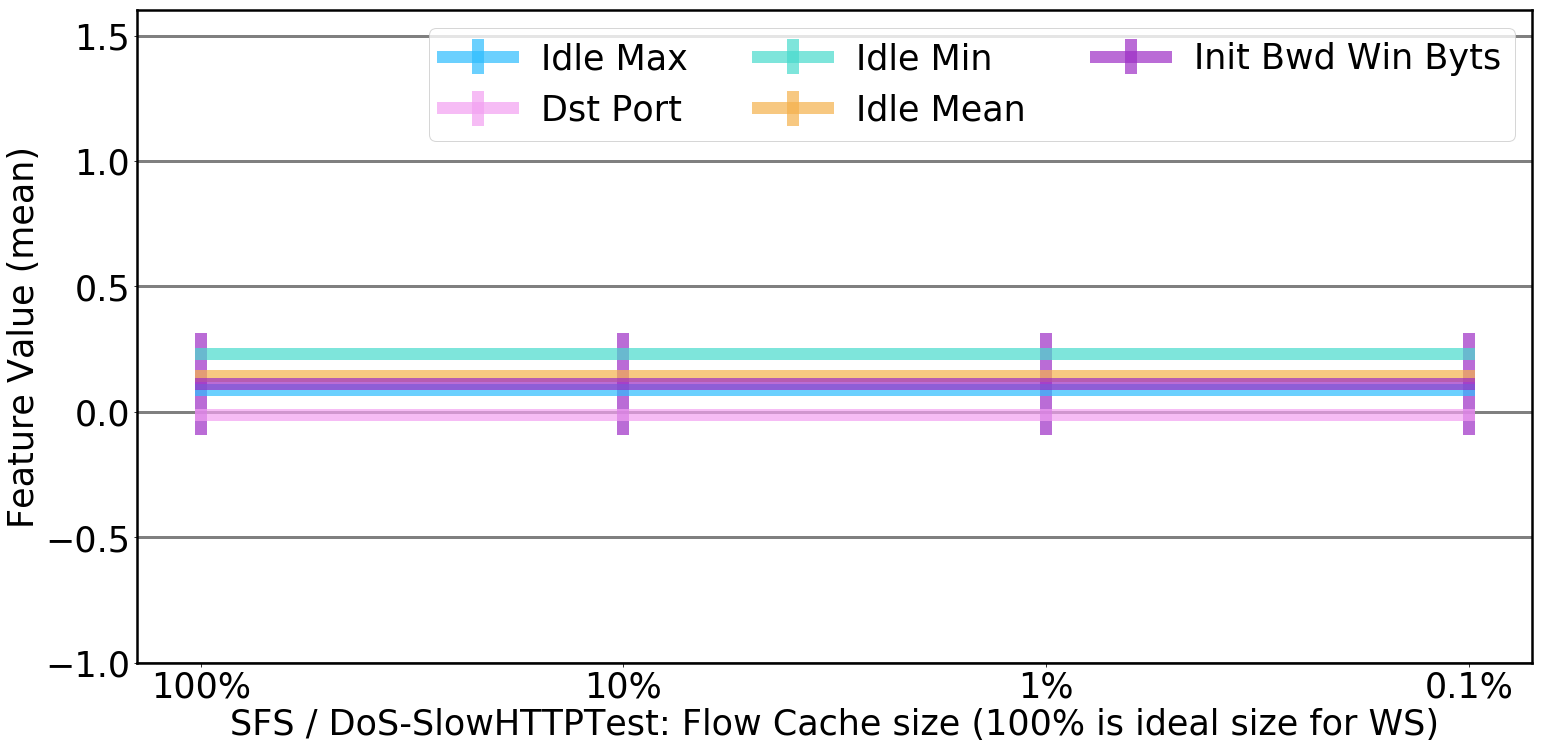

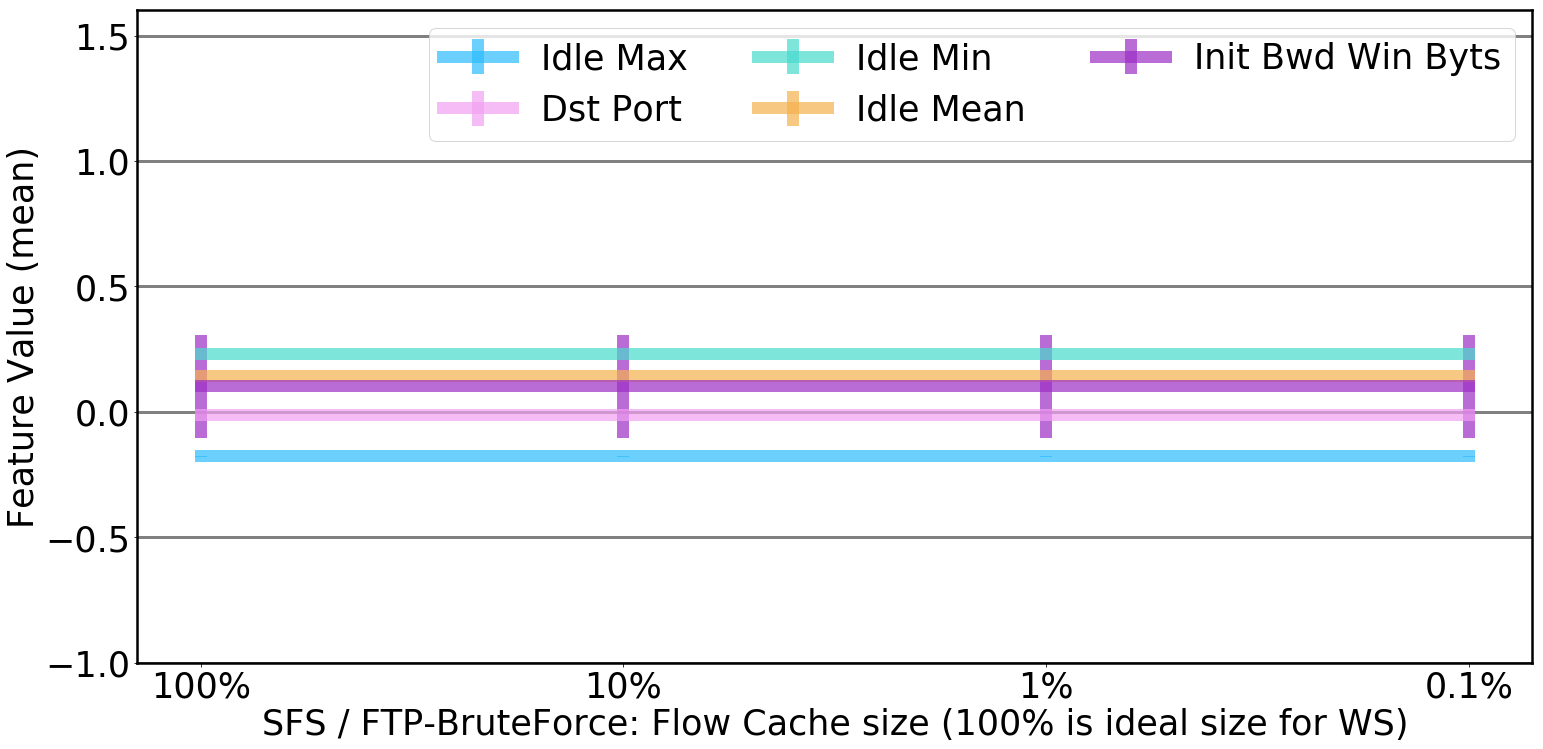

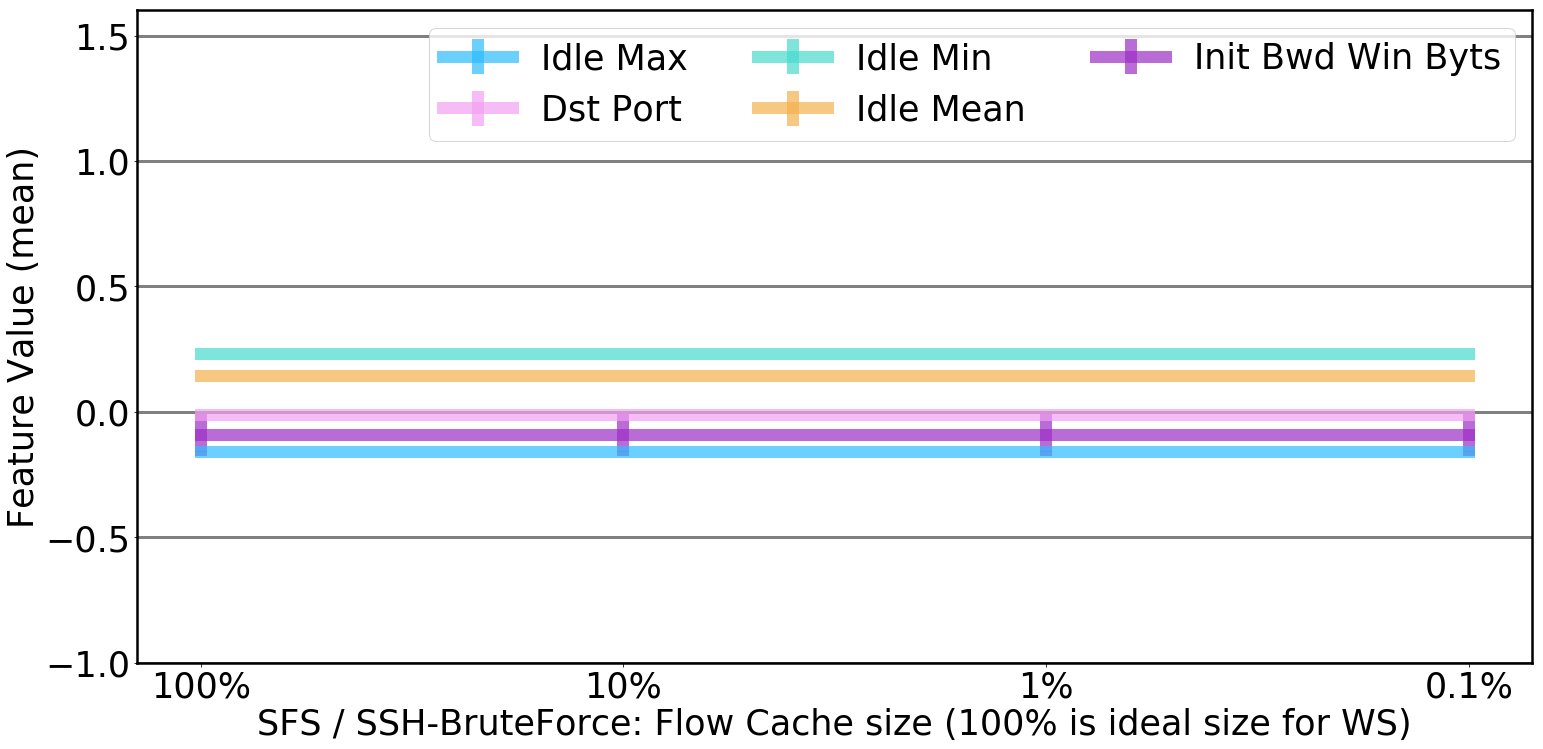

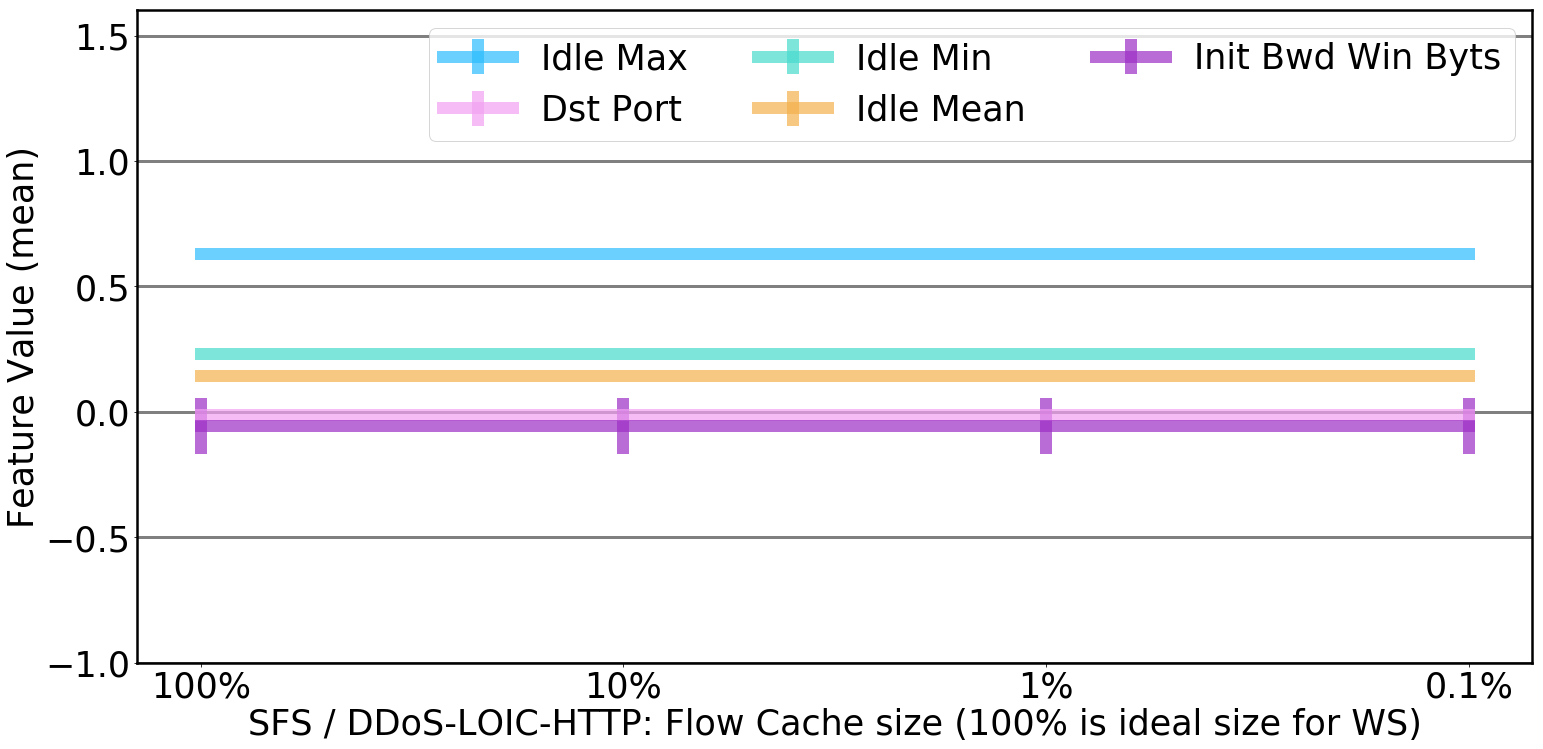

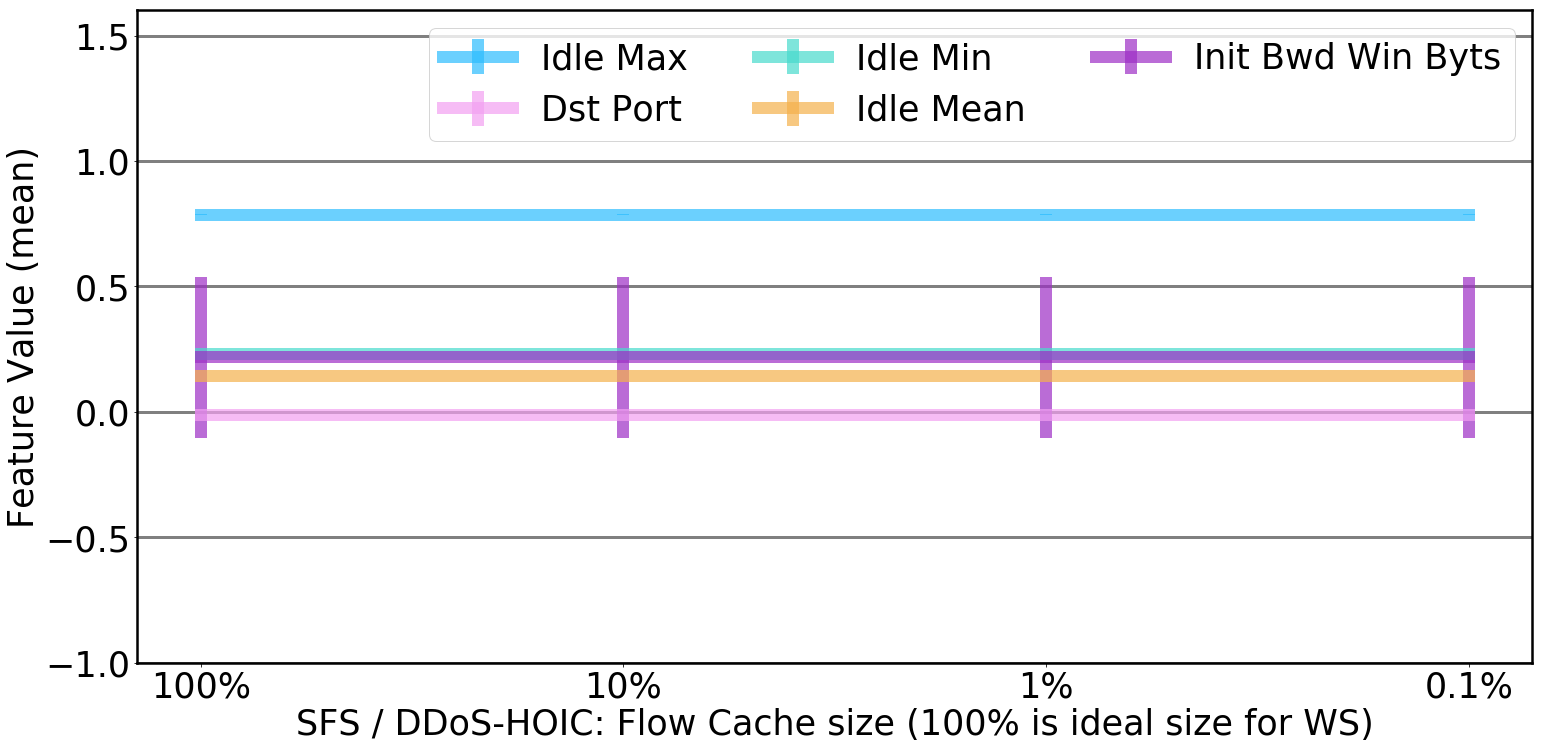

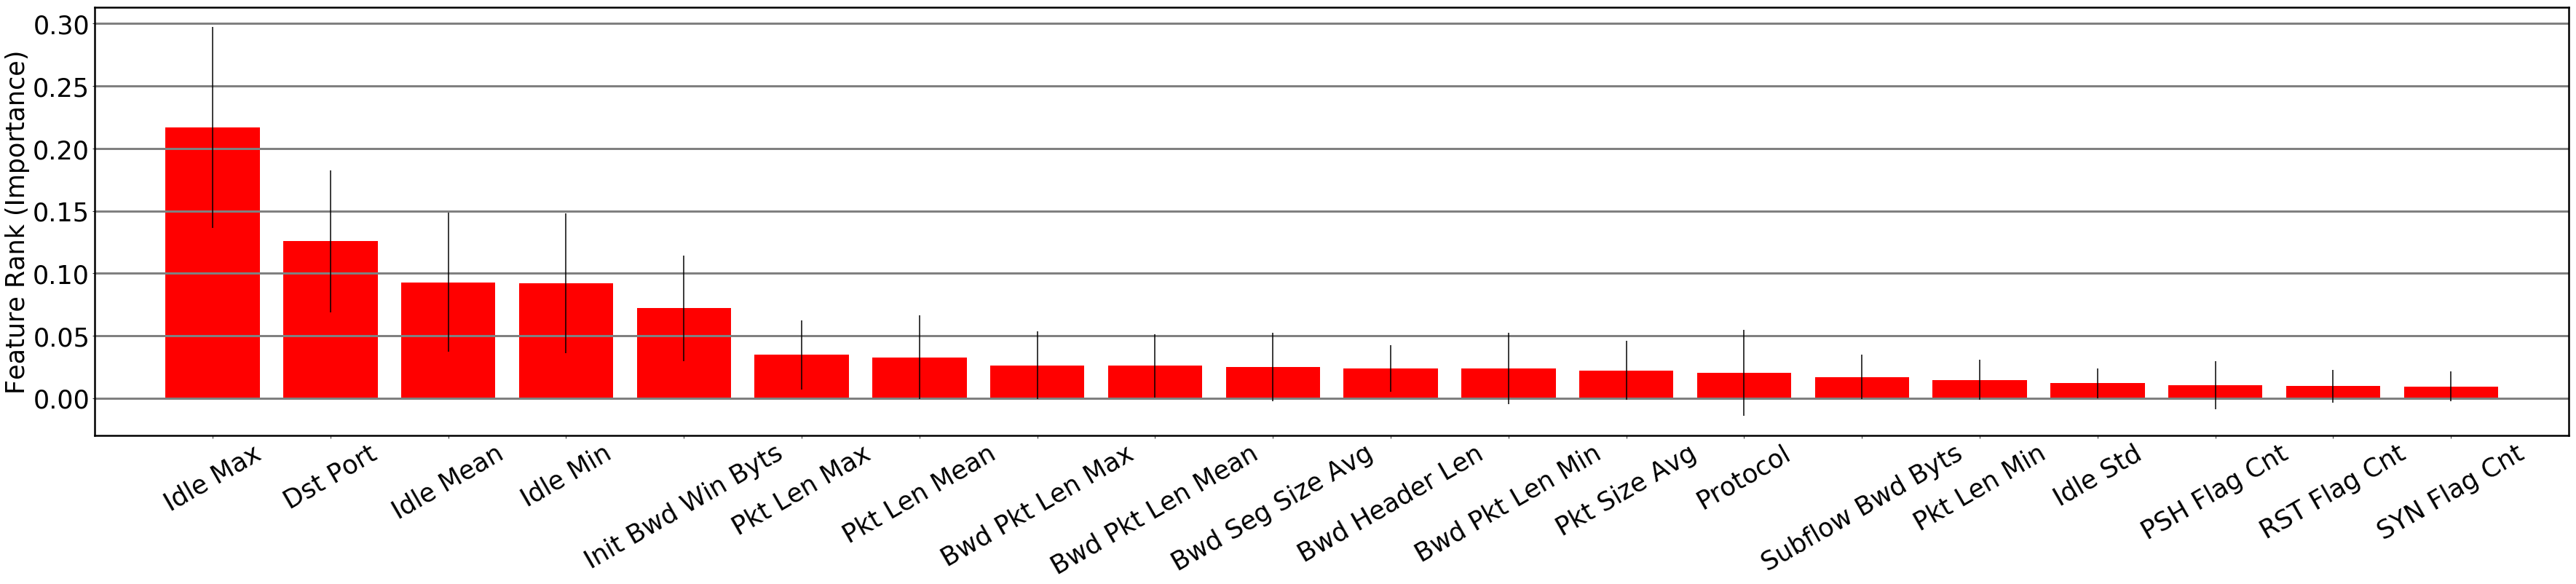

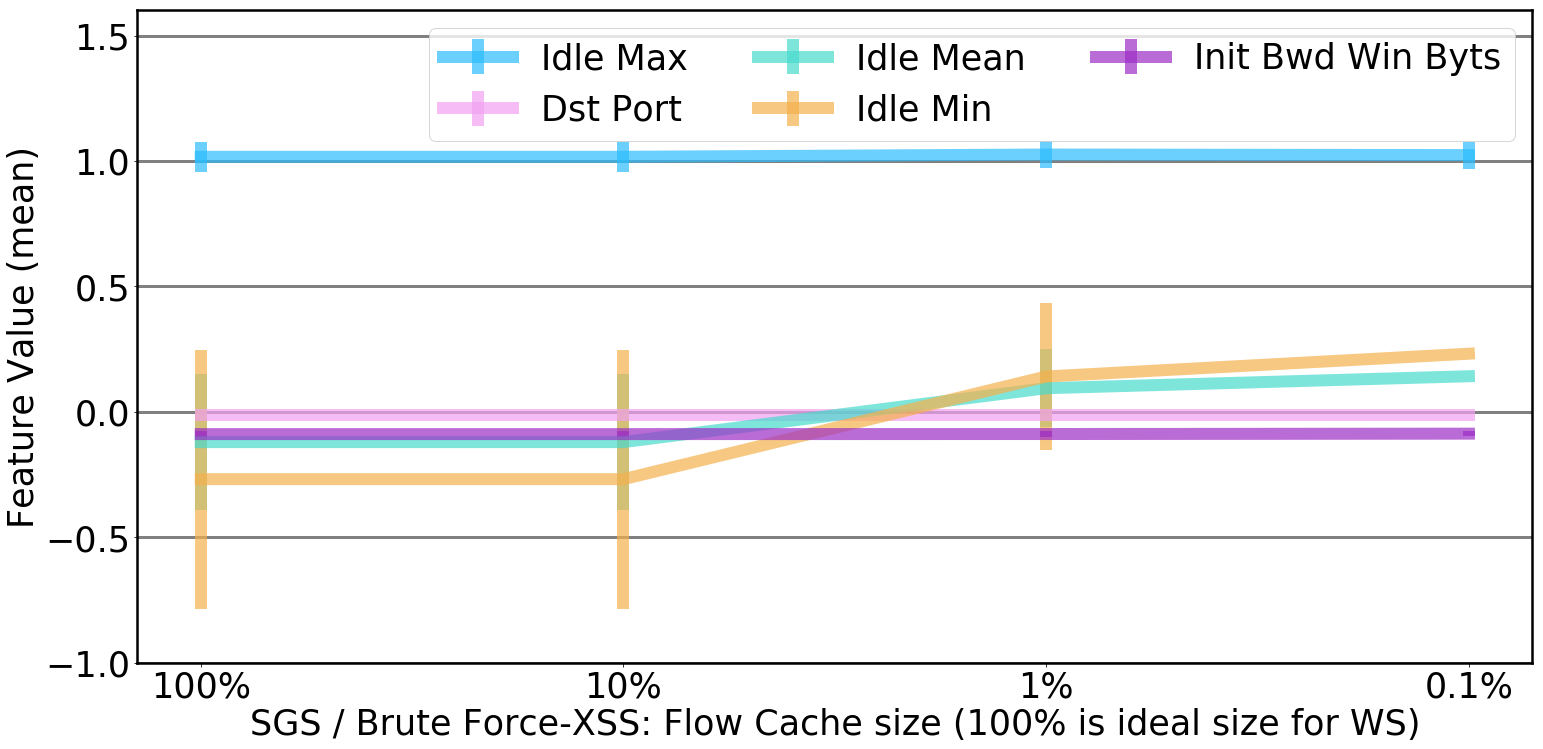

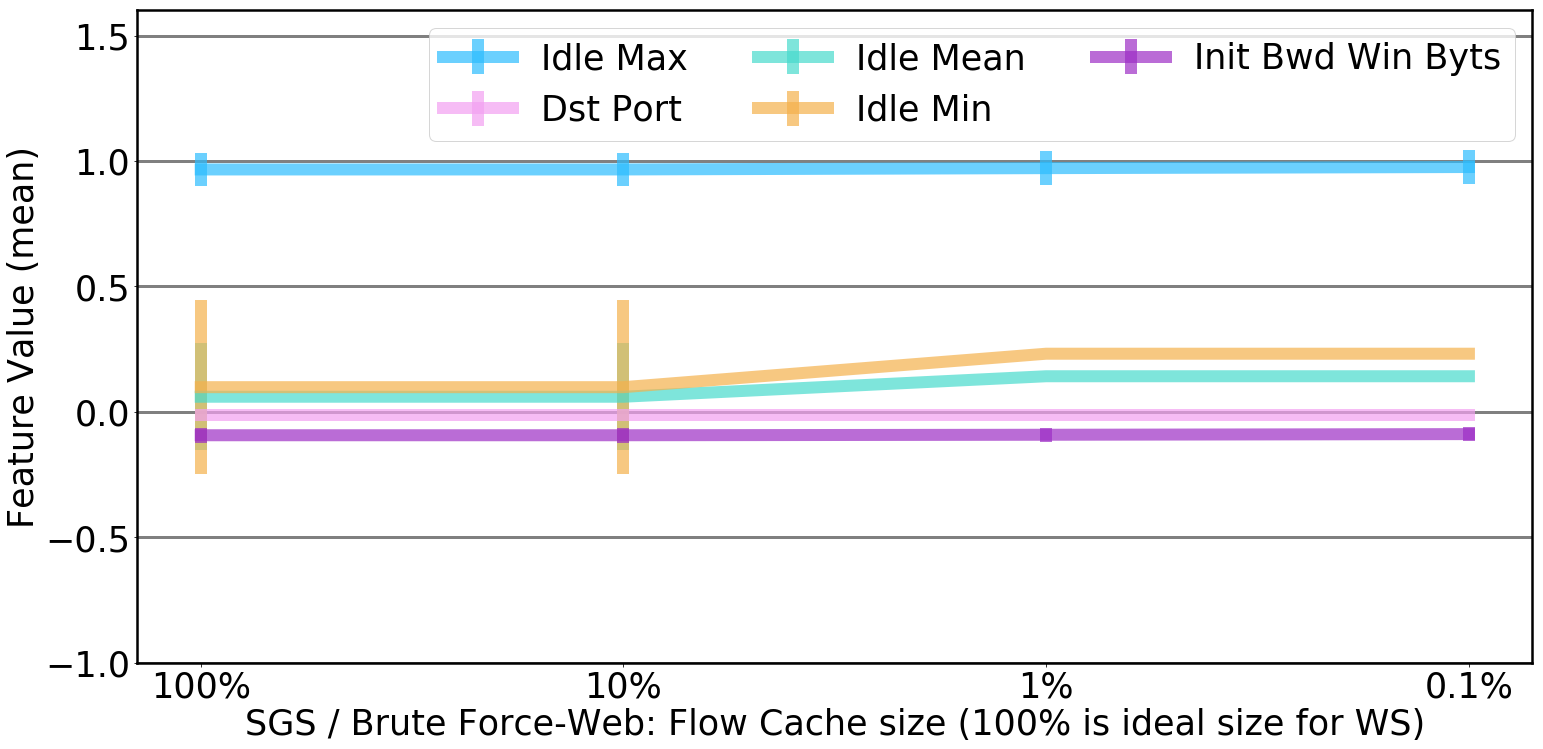

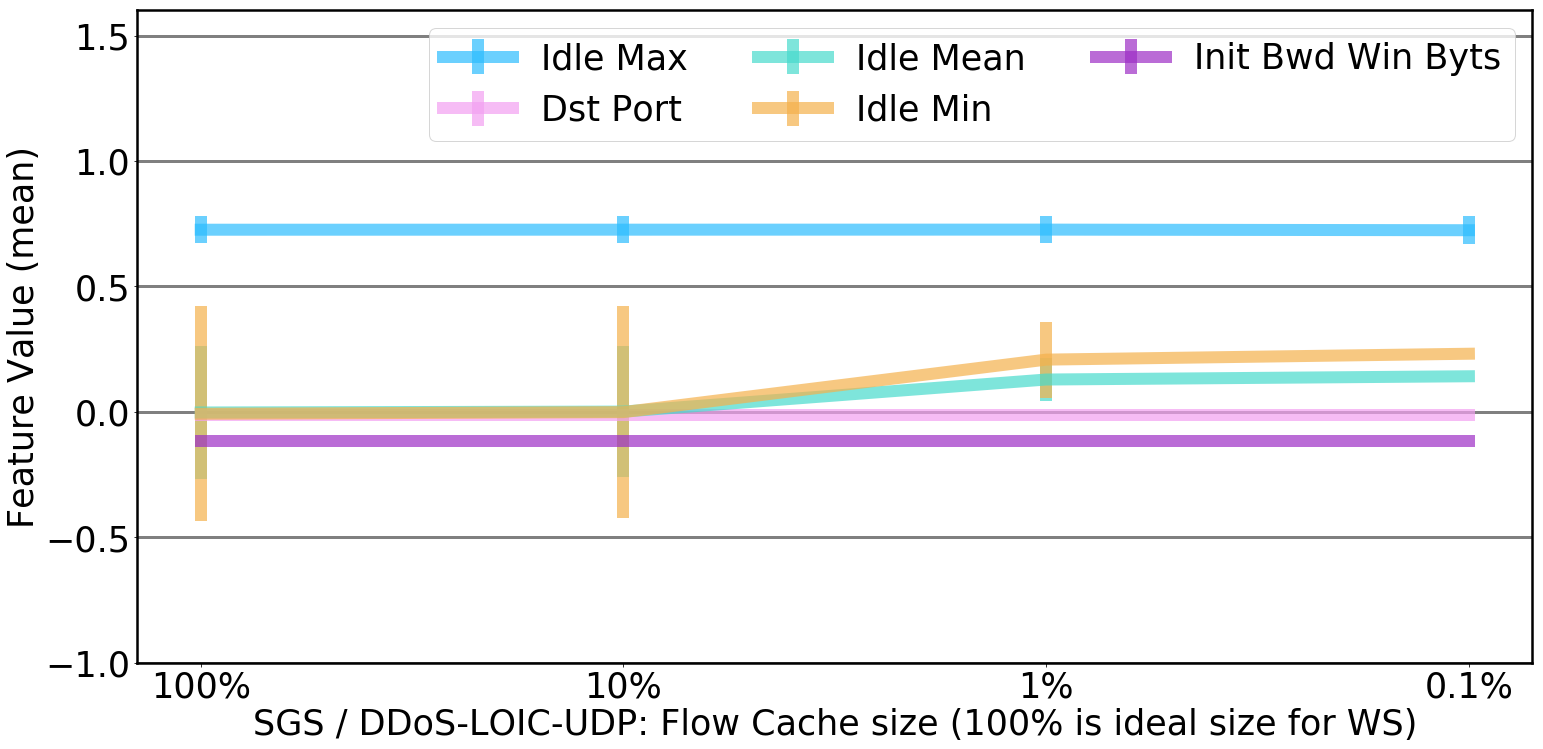

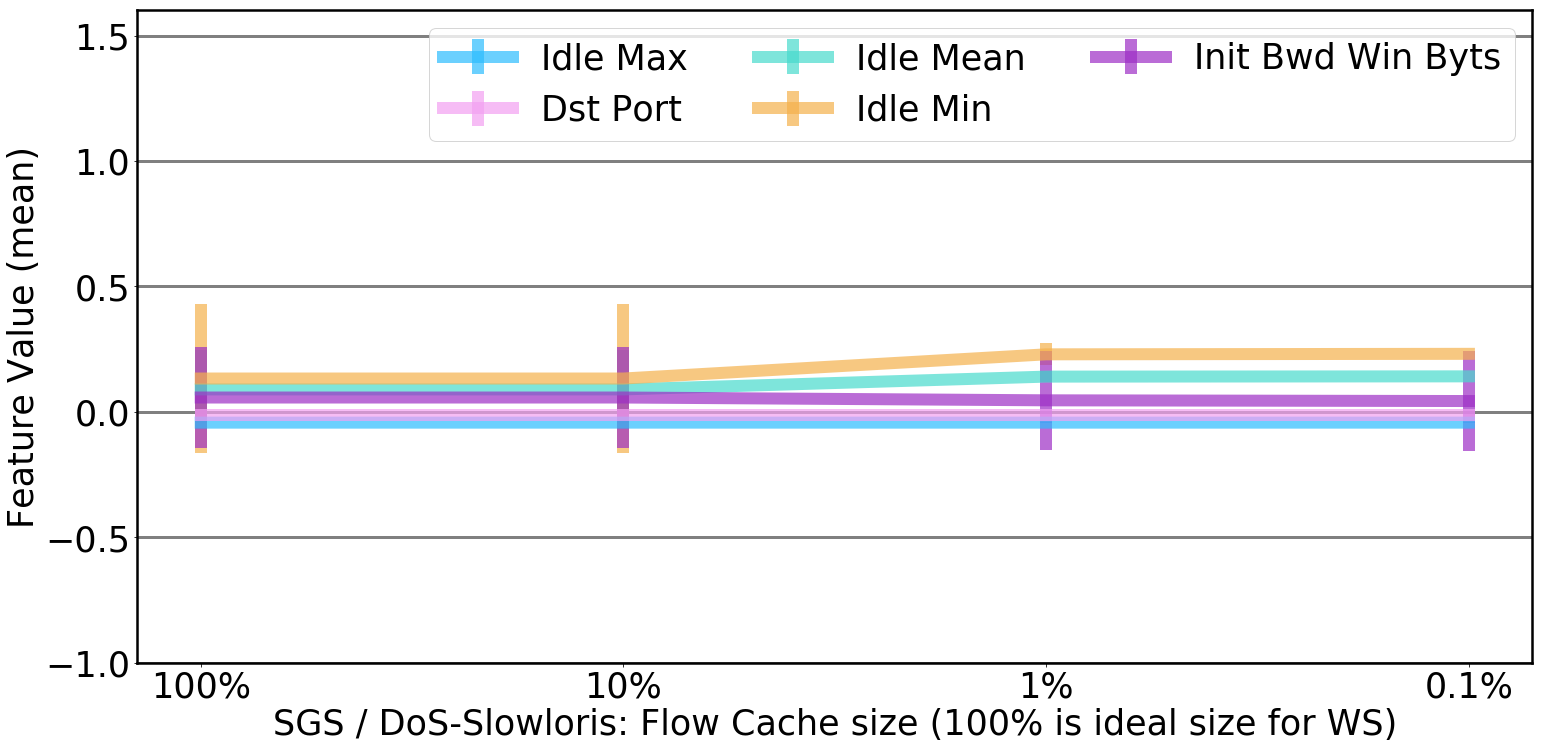

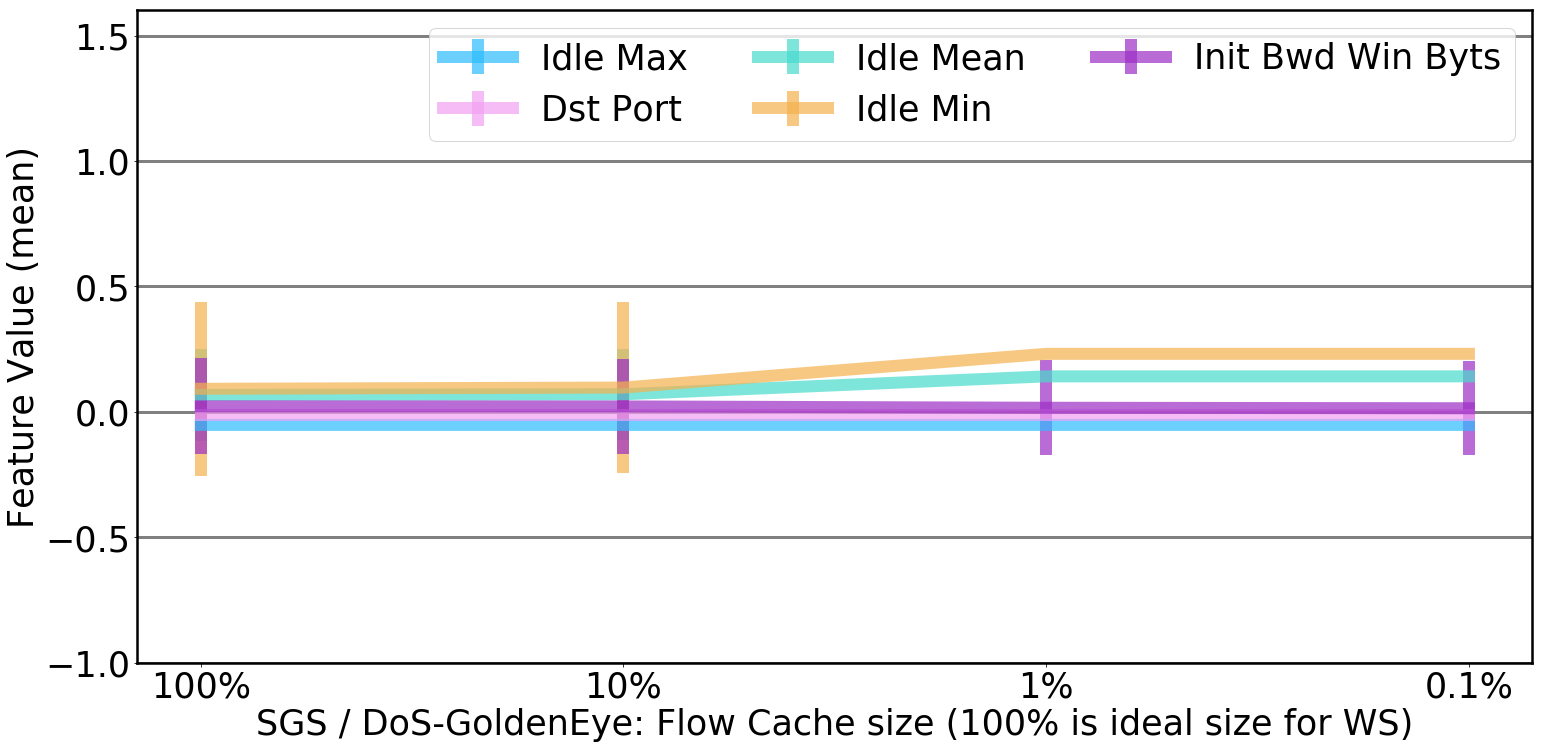

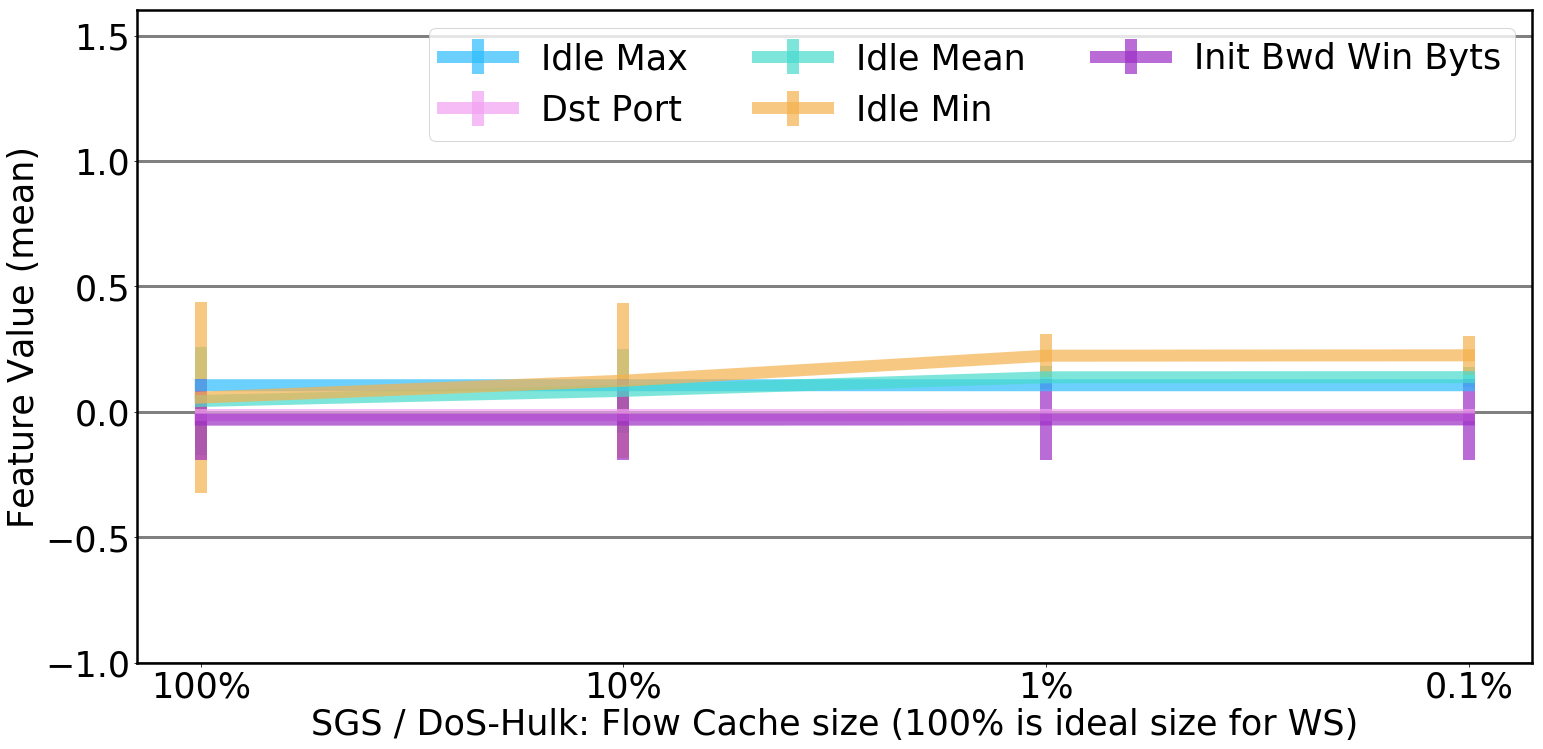

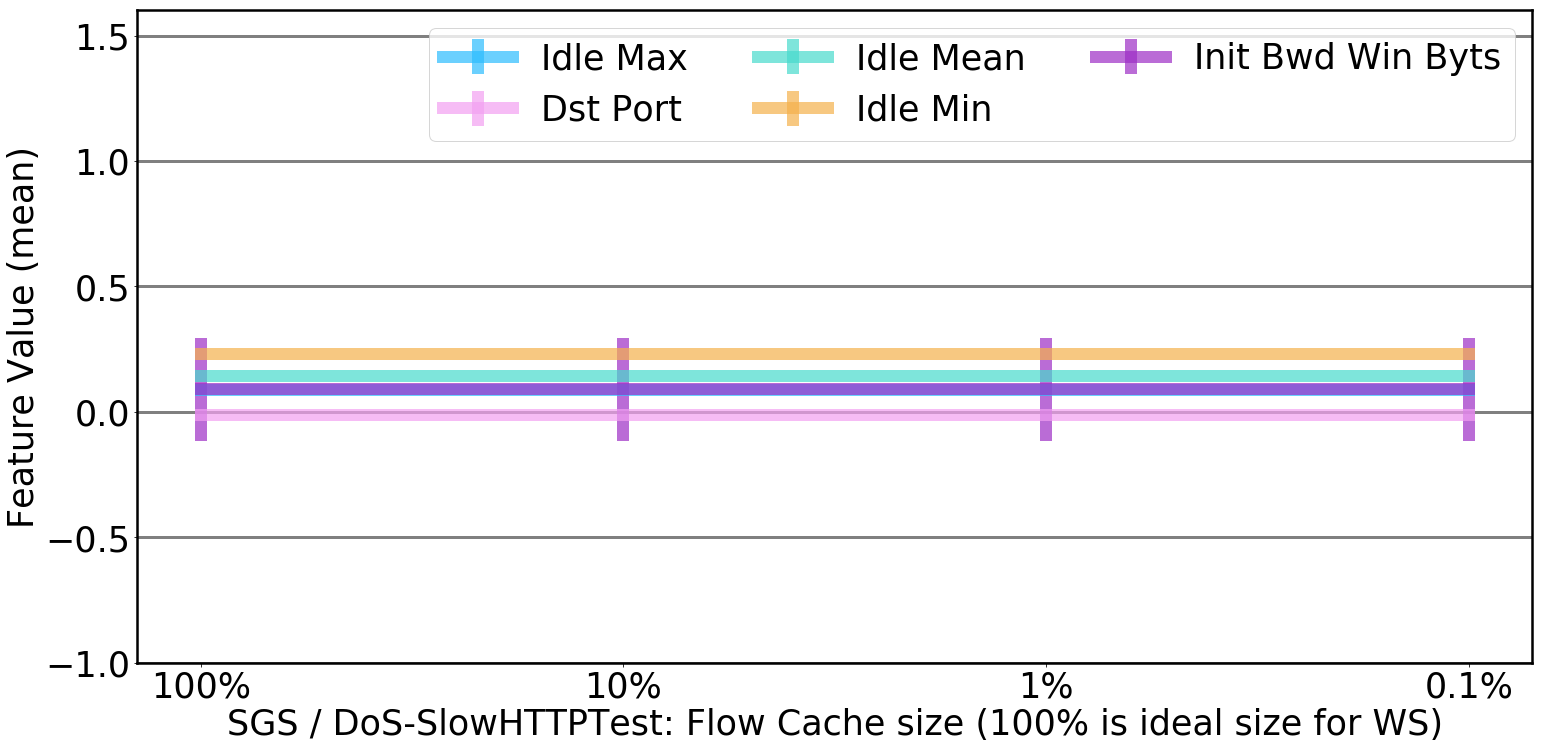

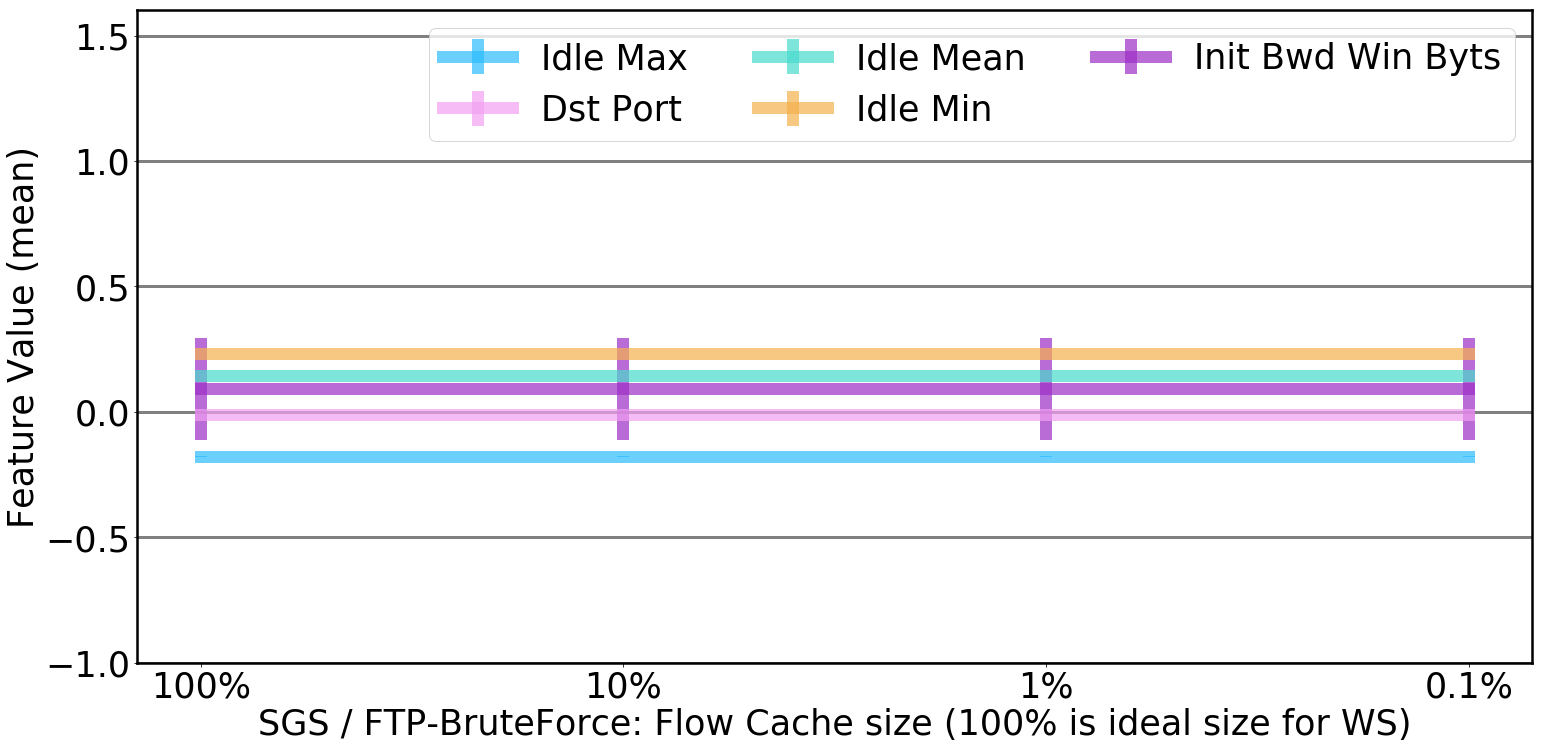

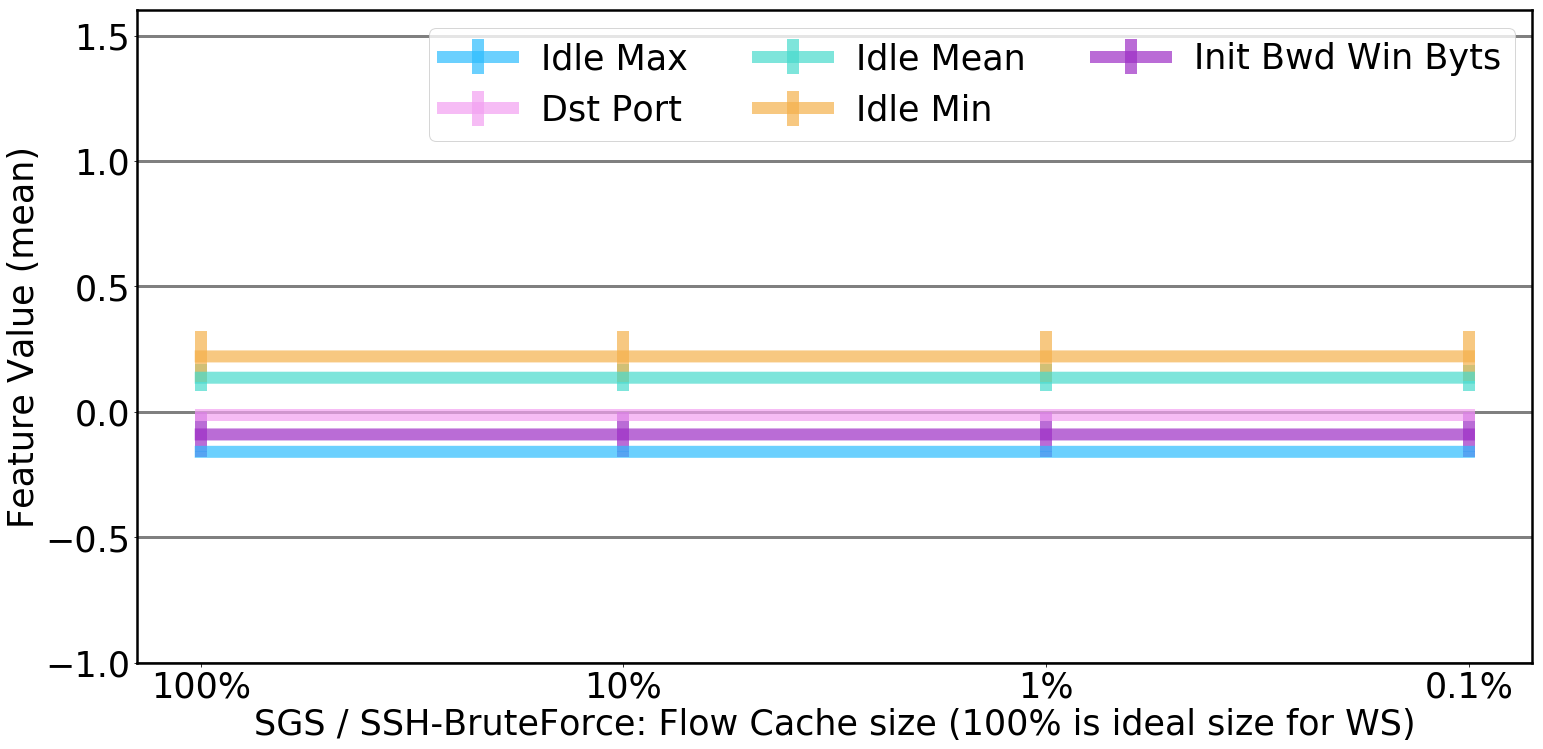

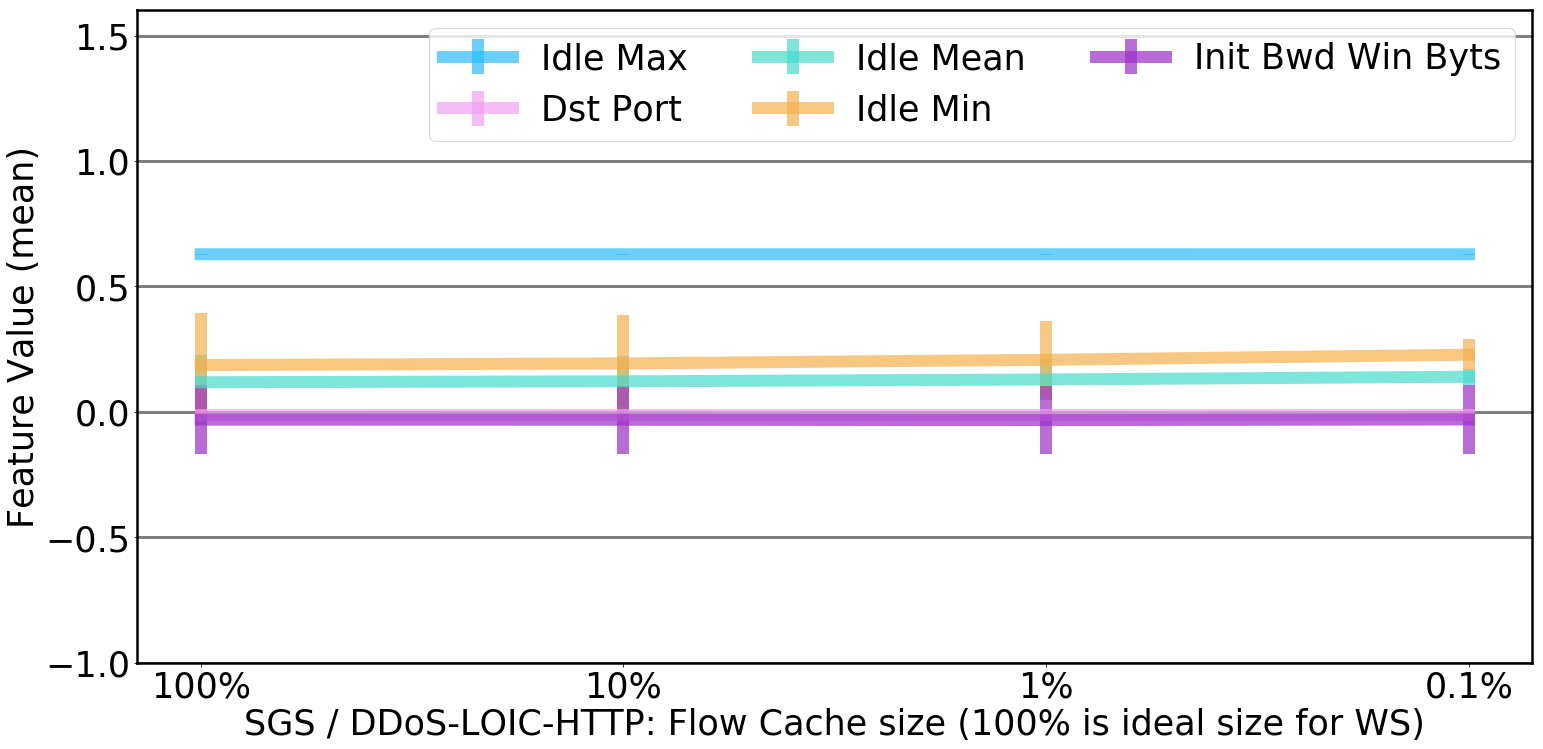

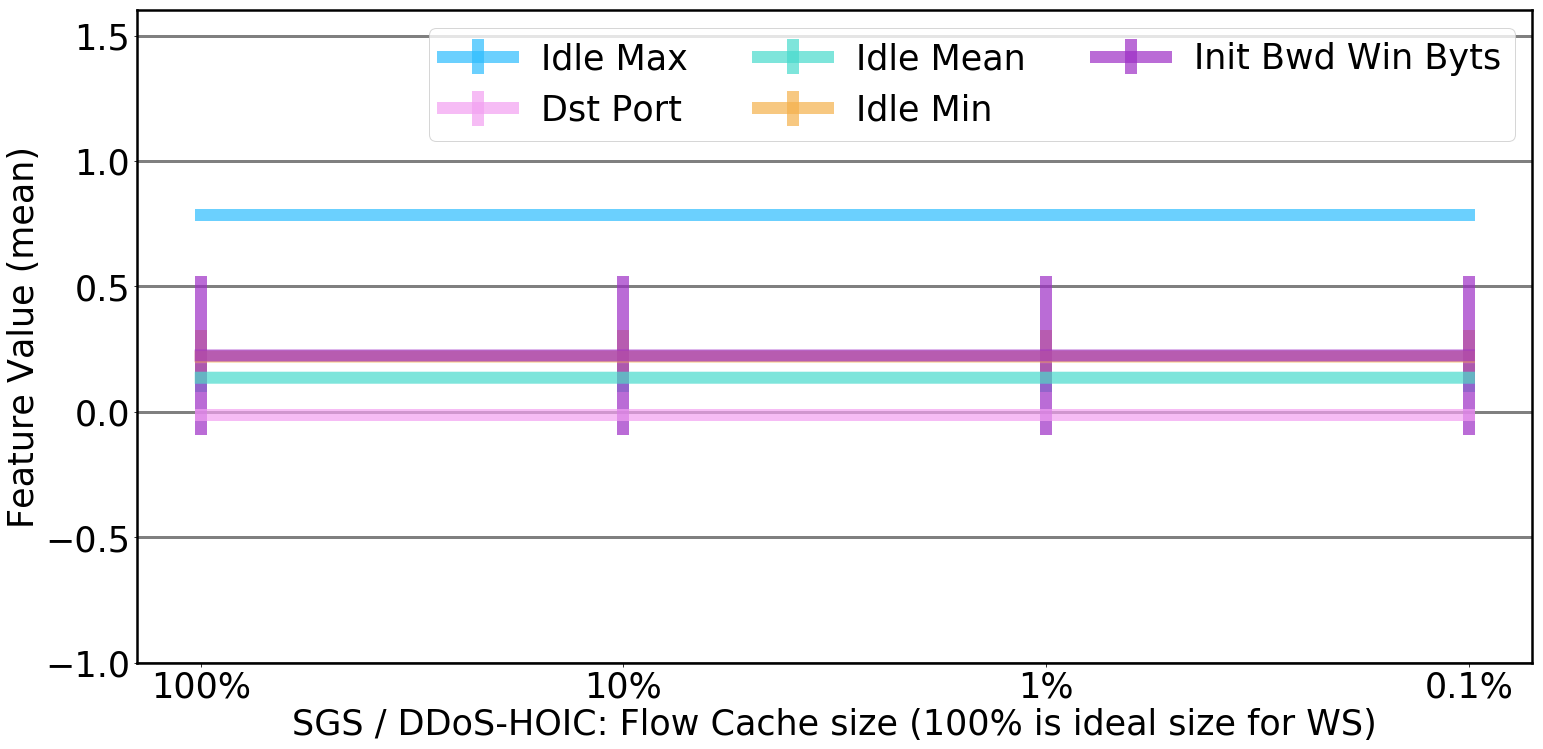

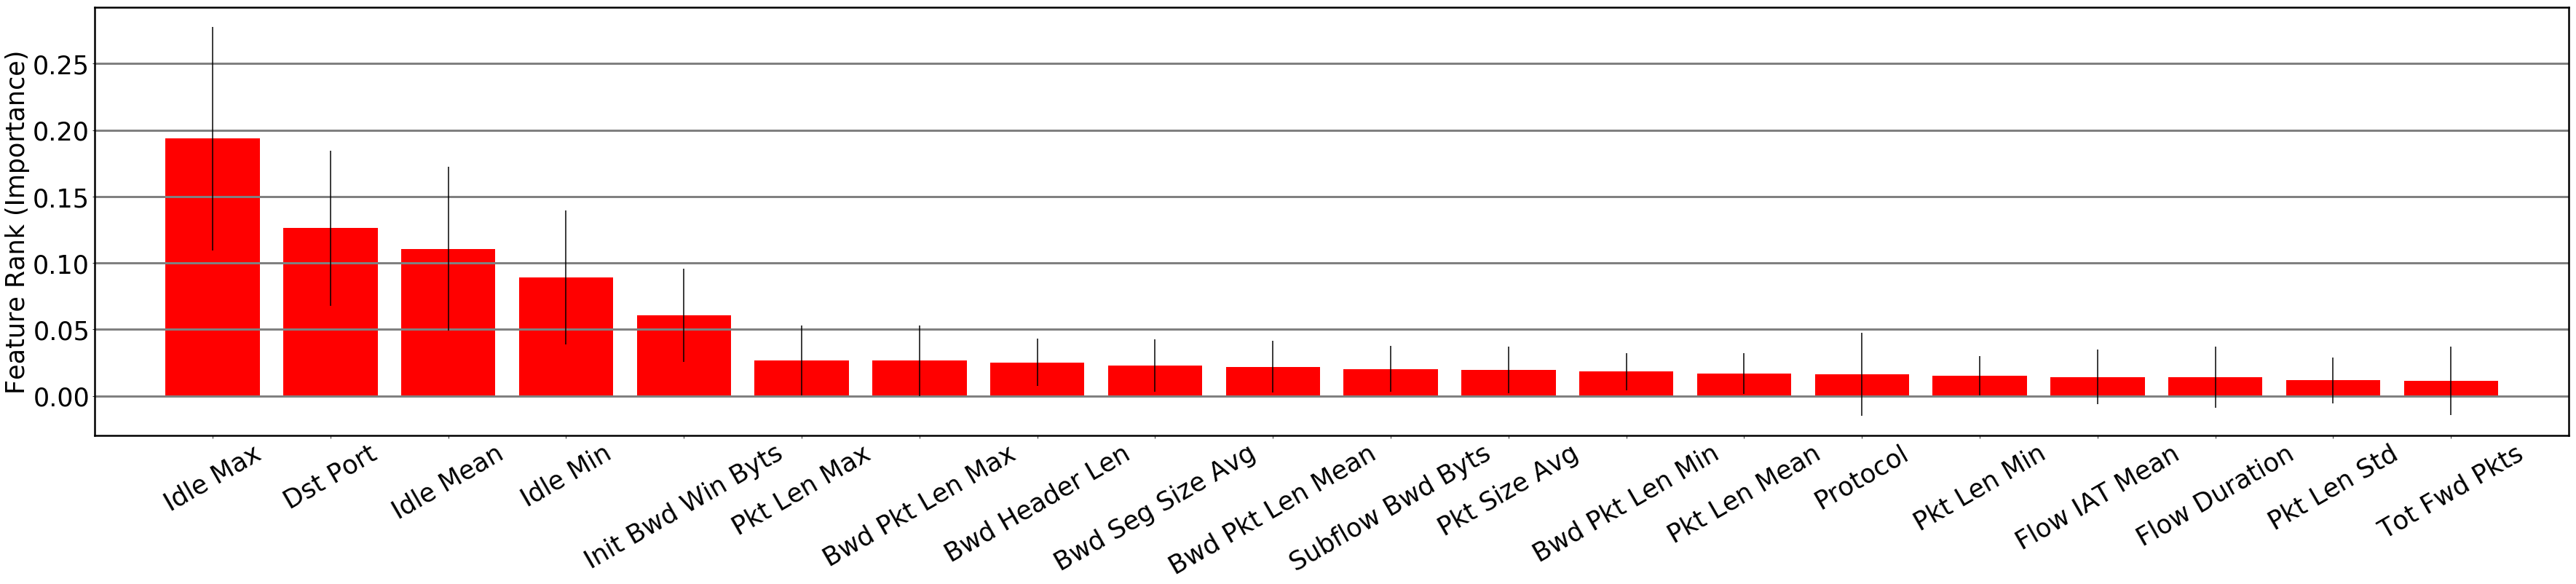

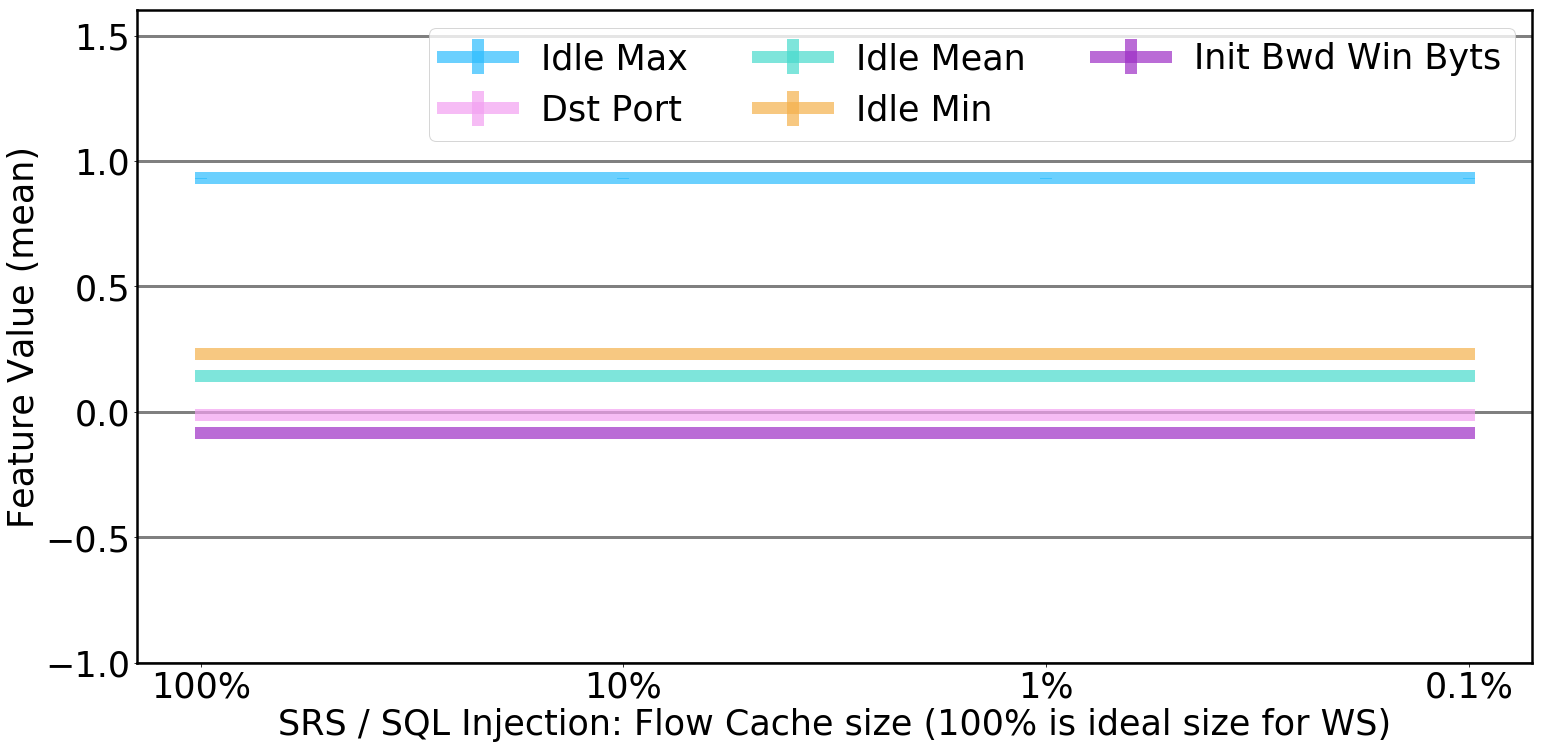

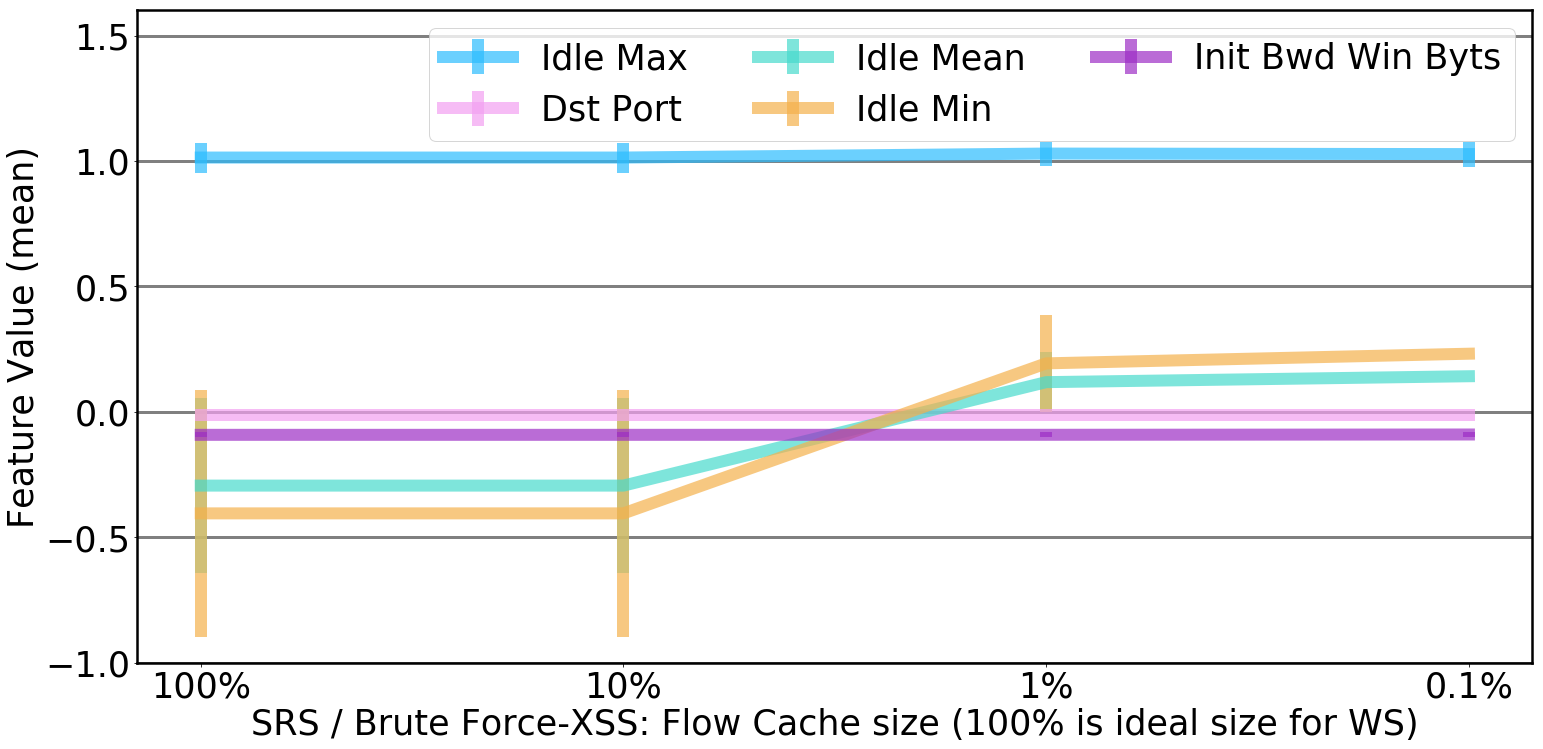

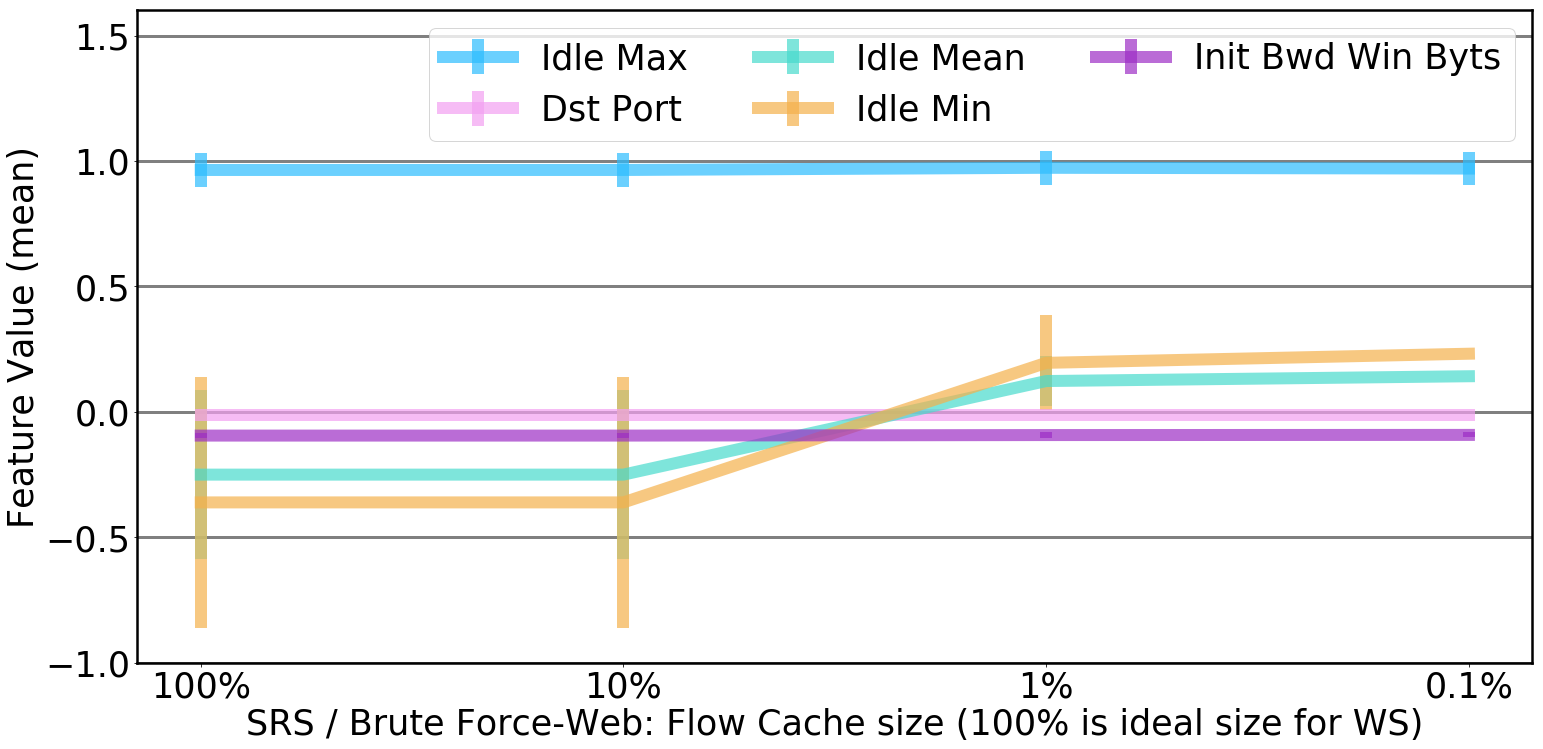

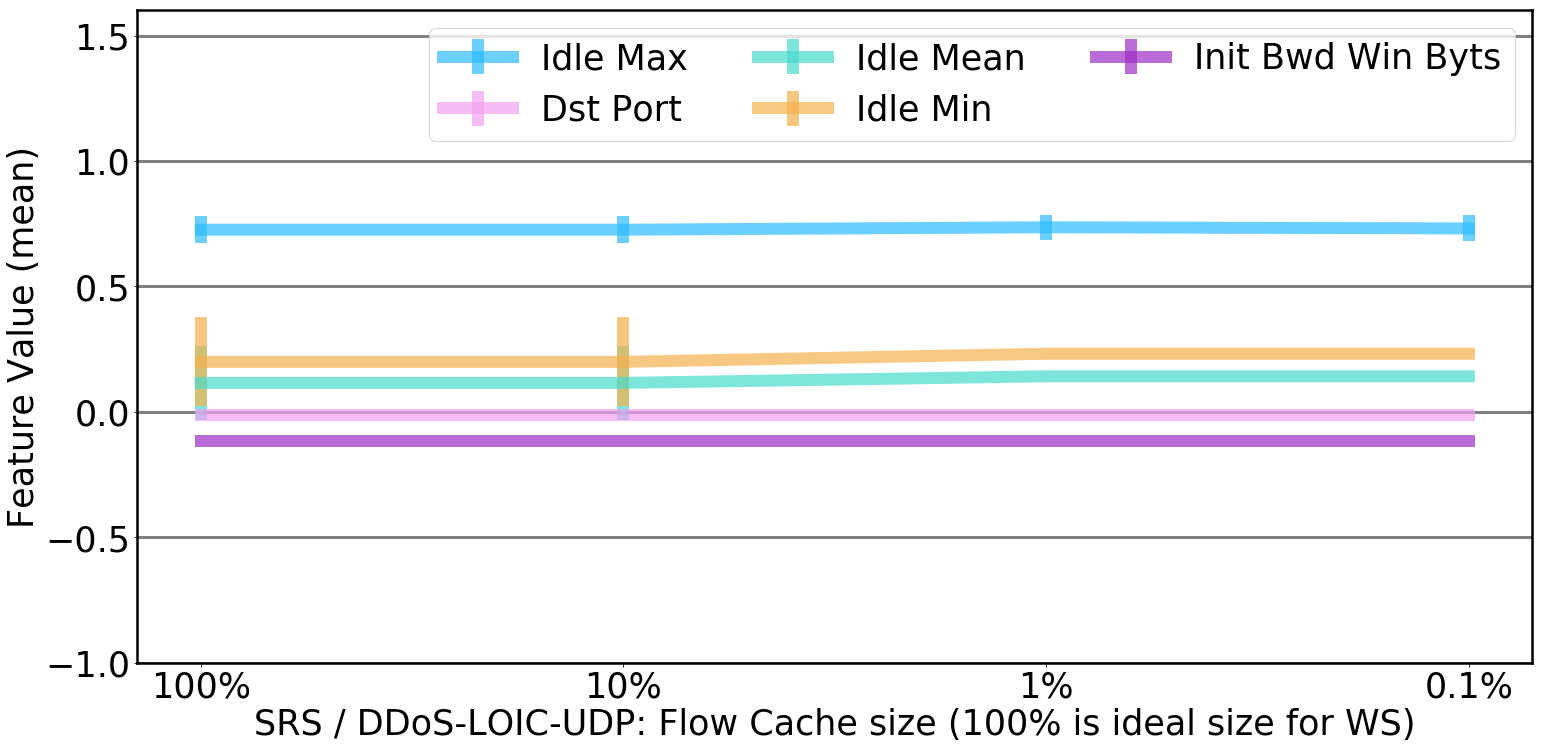

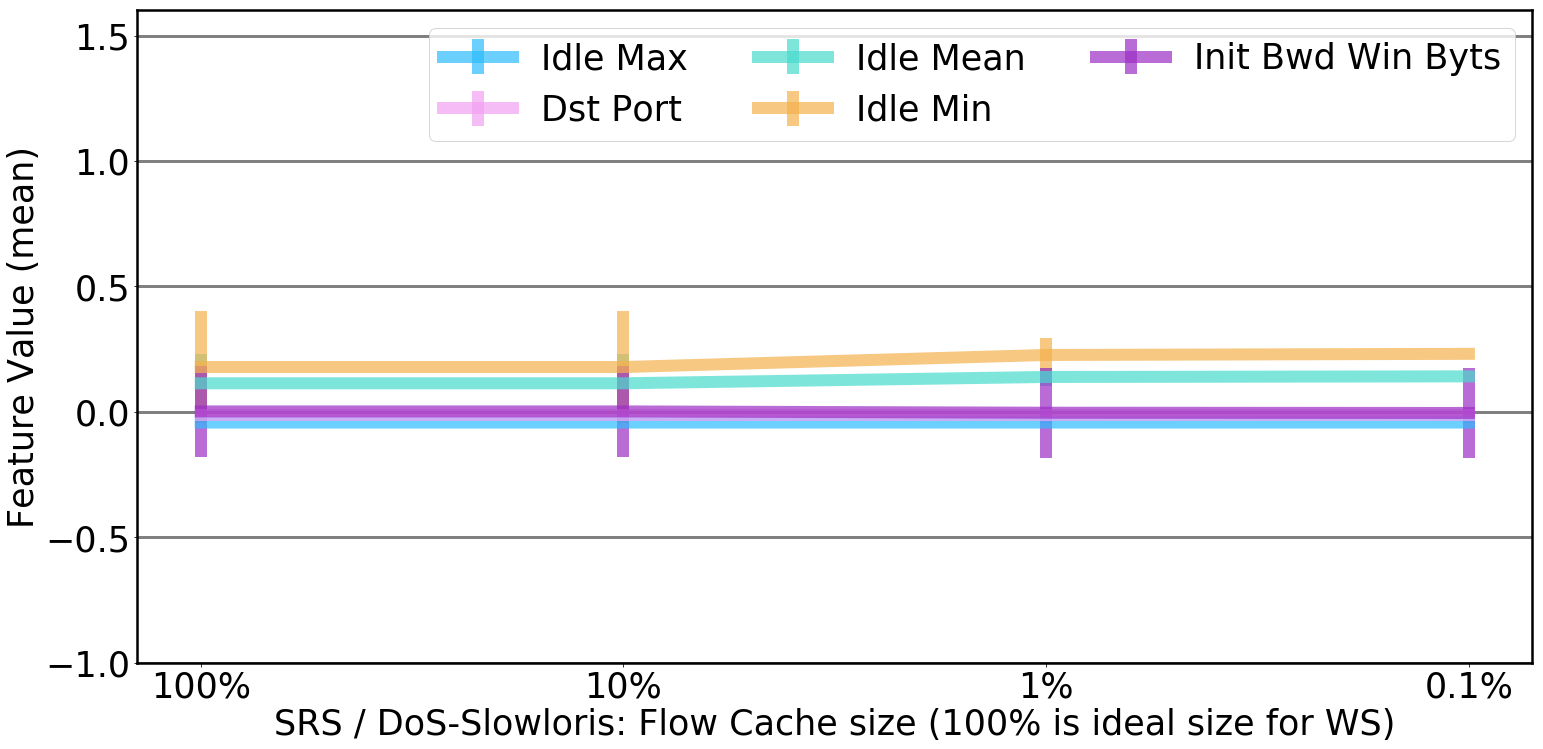

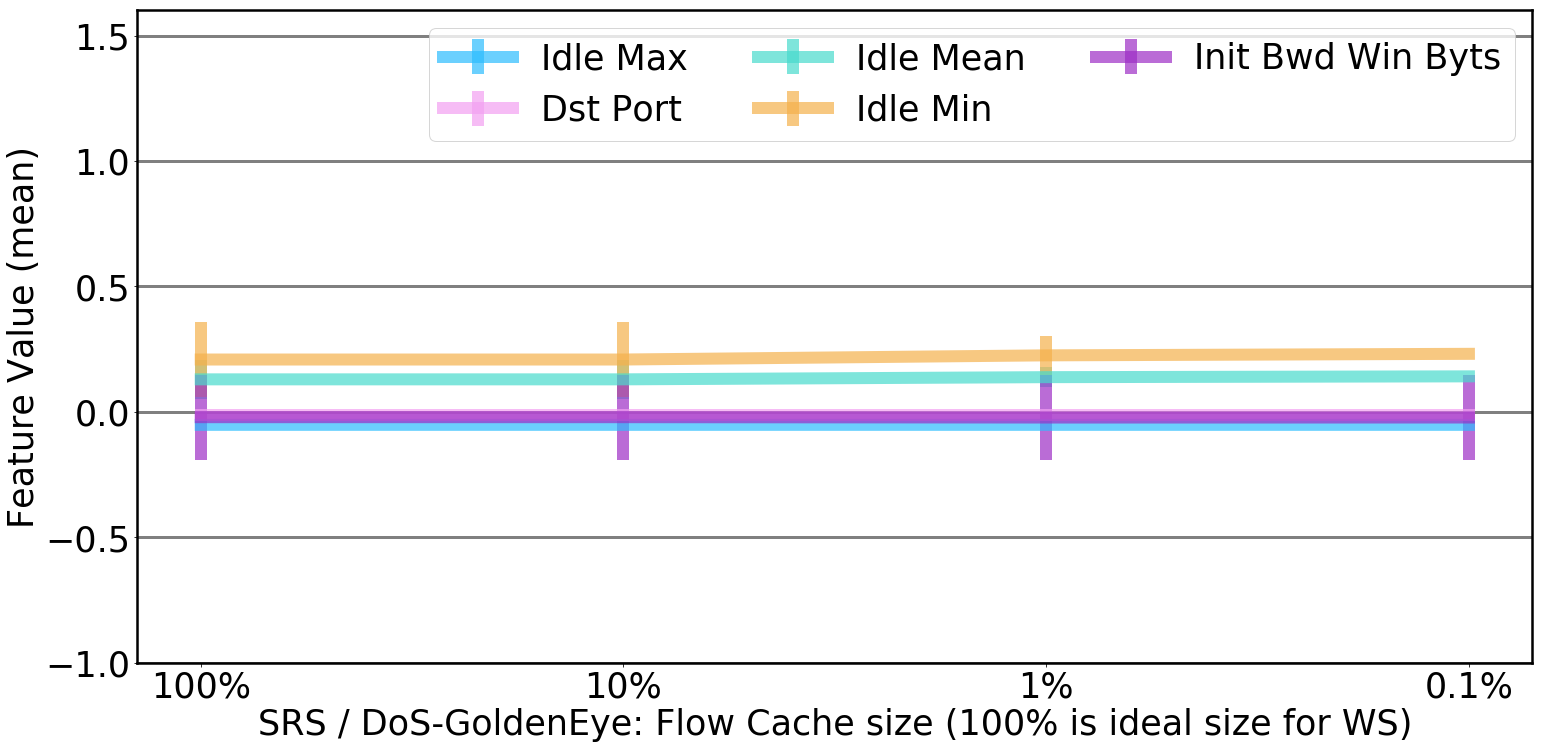

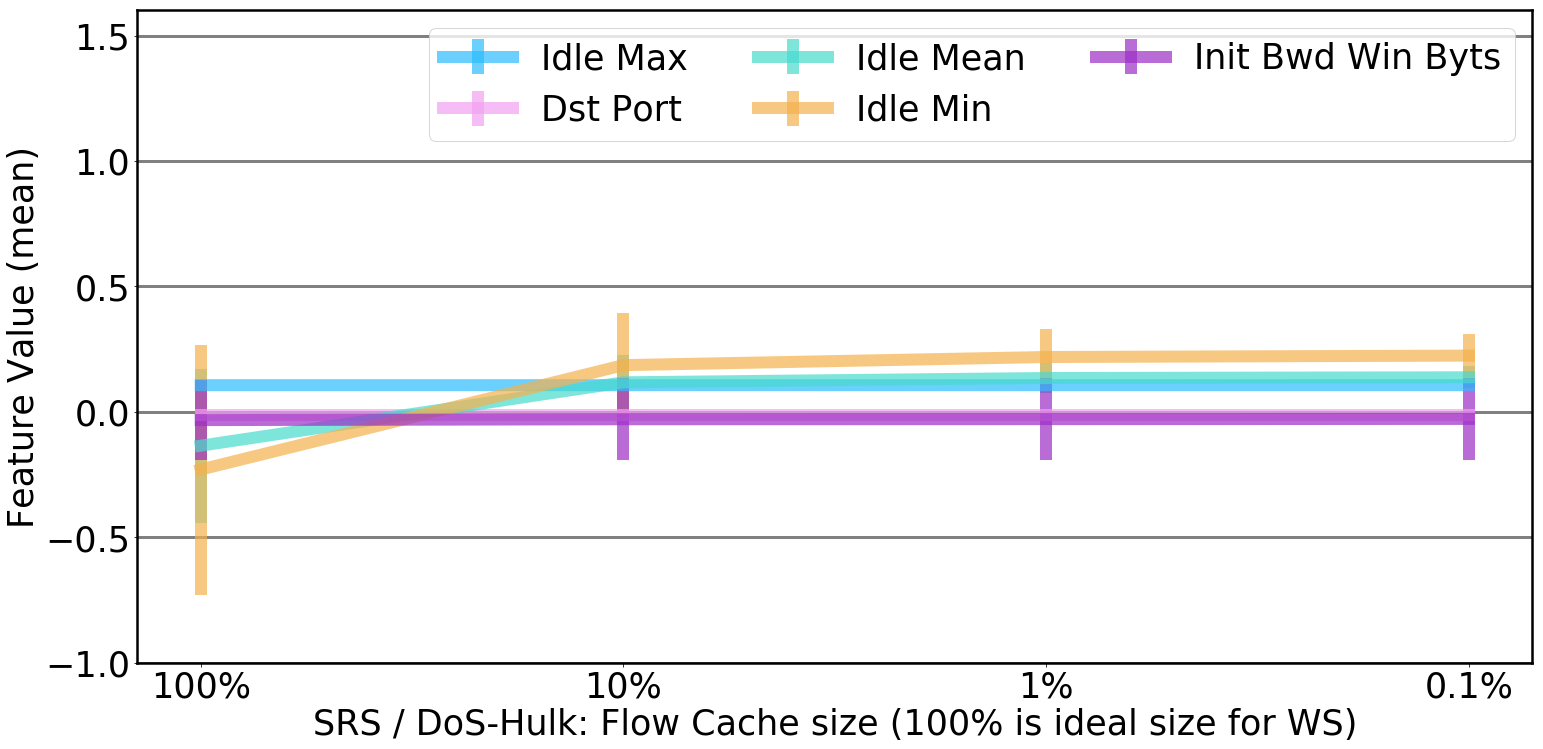

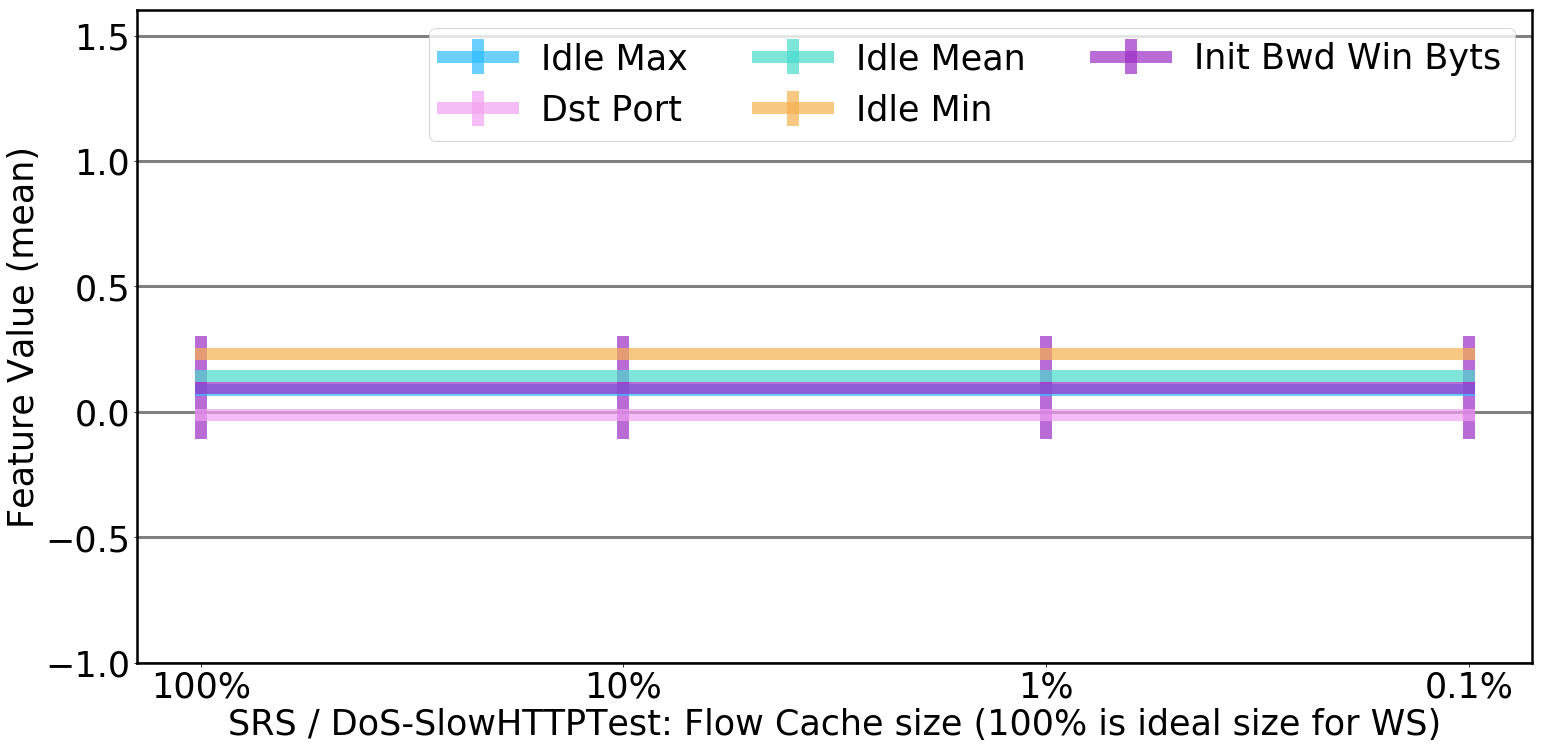

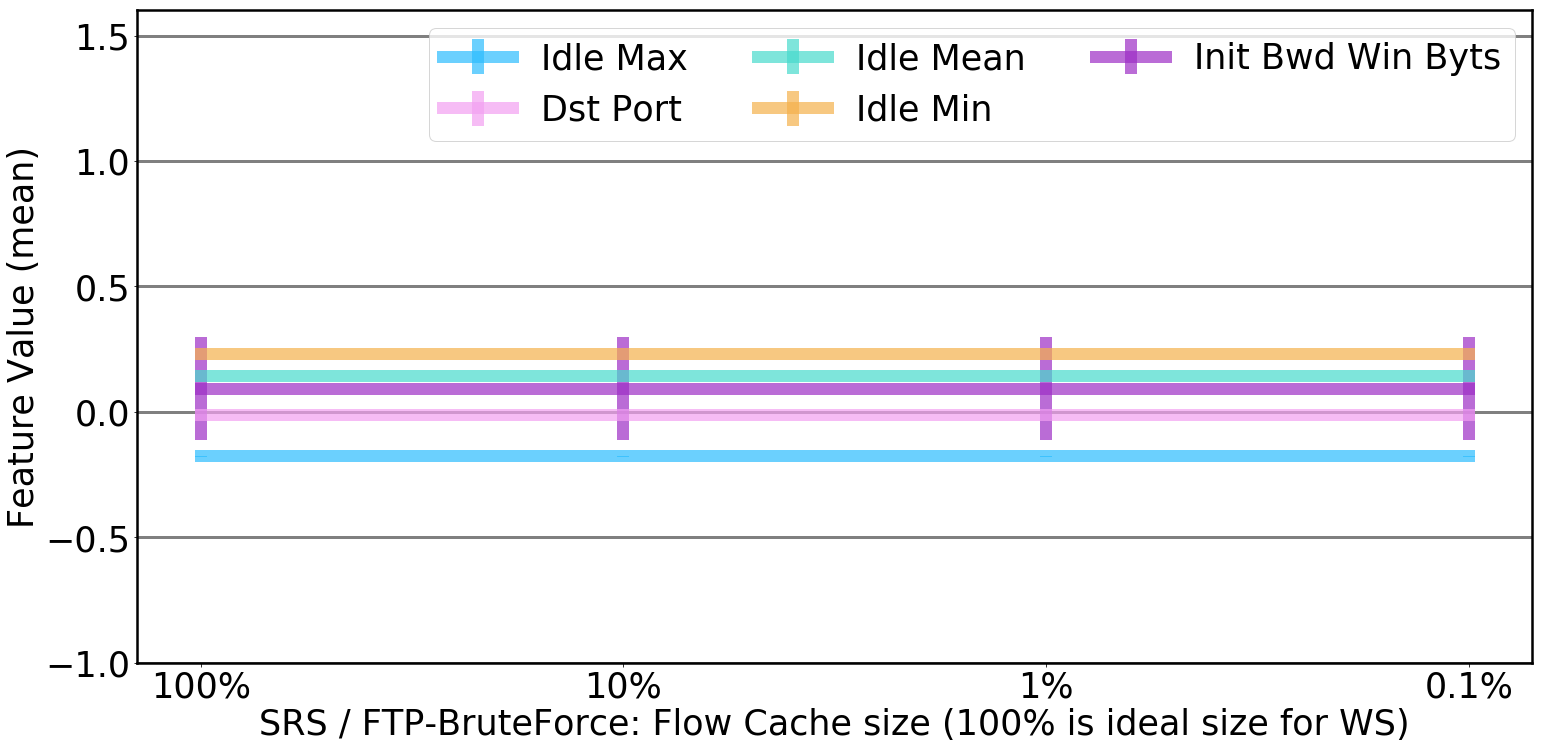

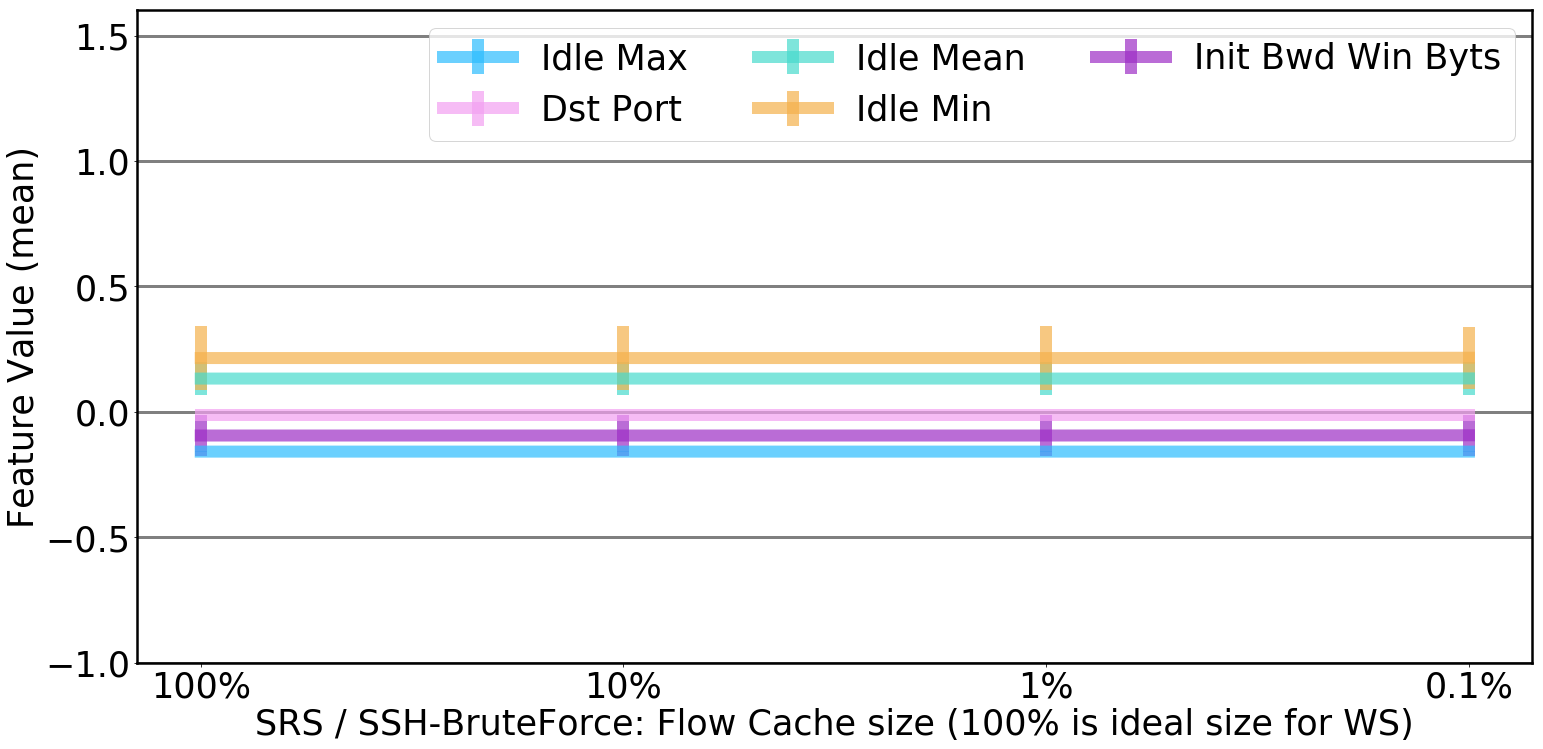

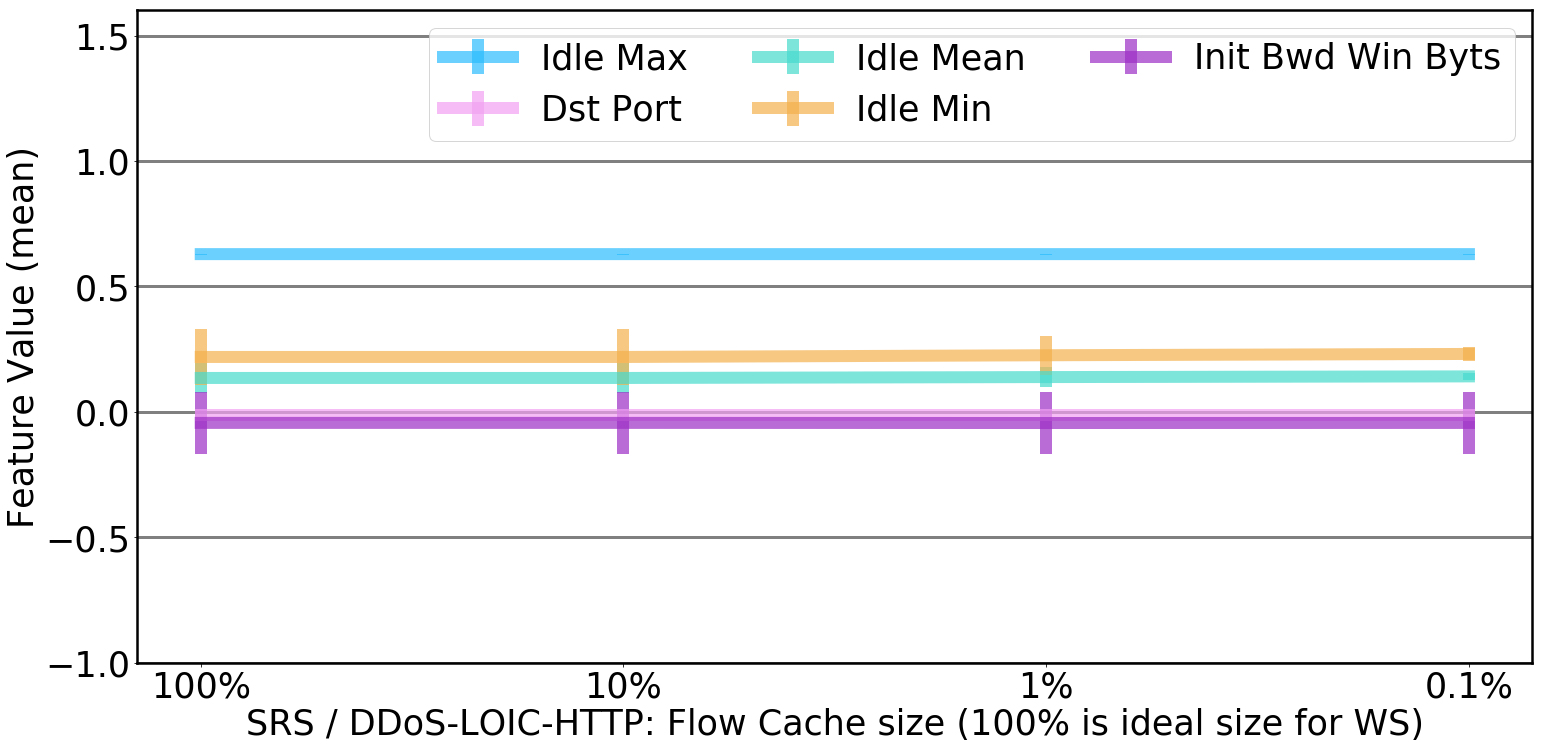

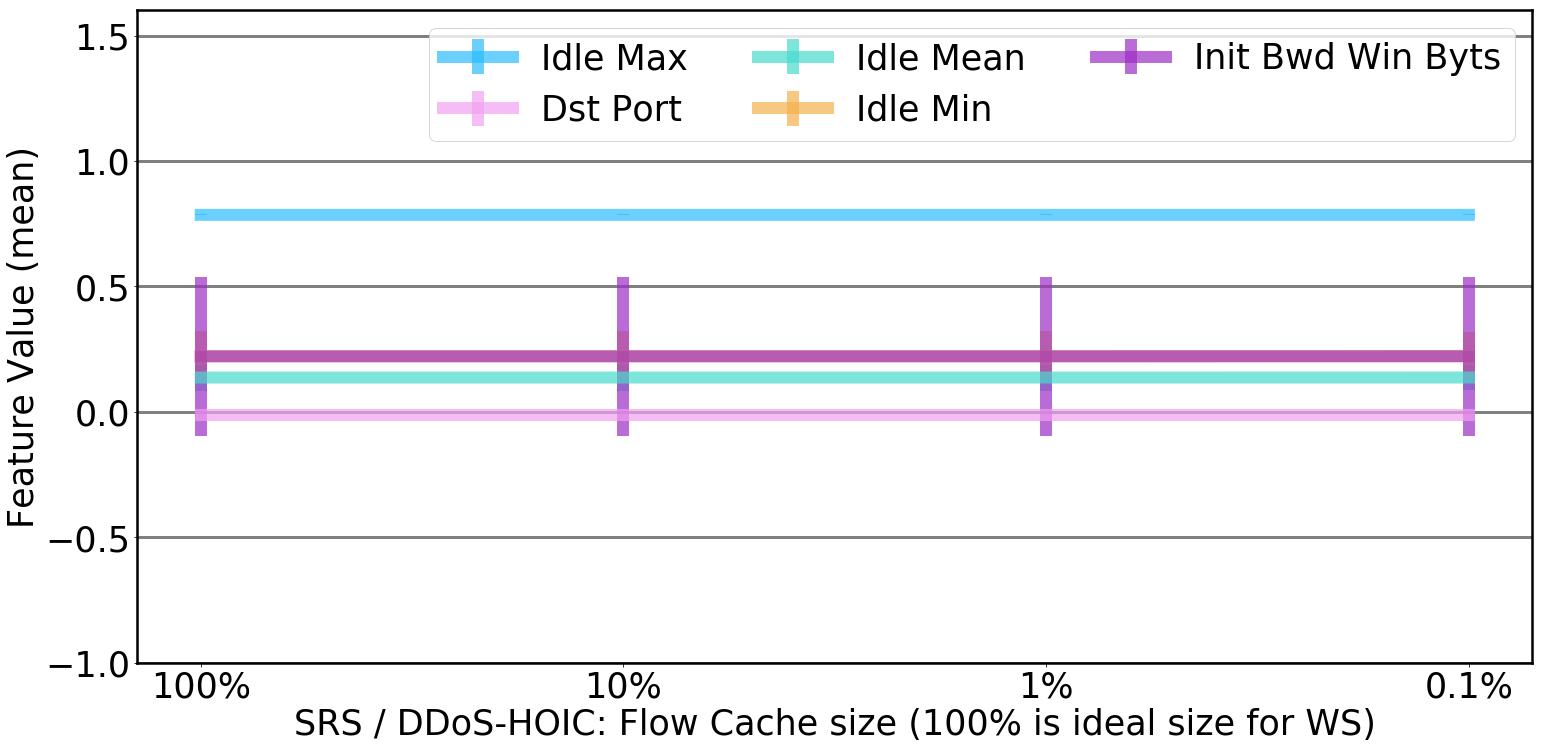

In [16]:
sr_dir = 'SR_1.0'
root = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/{}/'.format(sr_dir) 

for i,sampler_dir in enumerate(sorted(glob(join(root,'*_l')))):
    plot_feature_trend_for_sampler(sampler_dir)    

/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_10.0/SRS_SI_10_l/c_forest_b_explicit_n_100_bootstrap_True_mf_auto_msl_3_ms_0.01_md_25/log/10fold_0.pkl



  0%|          | 0/13 [00:00<?, ?it/s]

-------/data/juma/data/ids18/CSVs_r_1.0_m_1.0/SR_10.0/SRS_SI_10_l--------



100%|██████████| 13/13 [10:14<00:00, 47.27s/it]


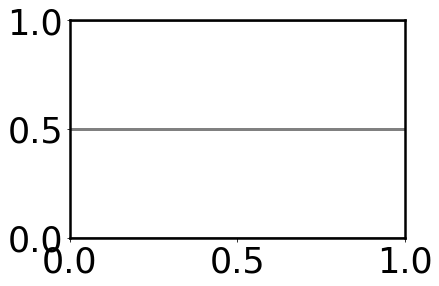

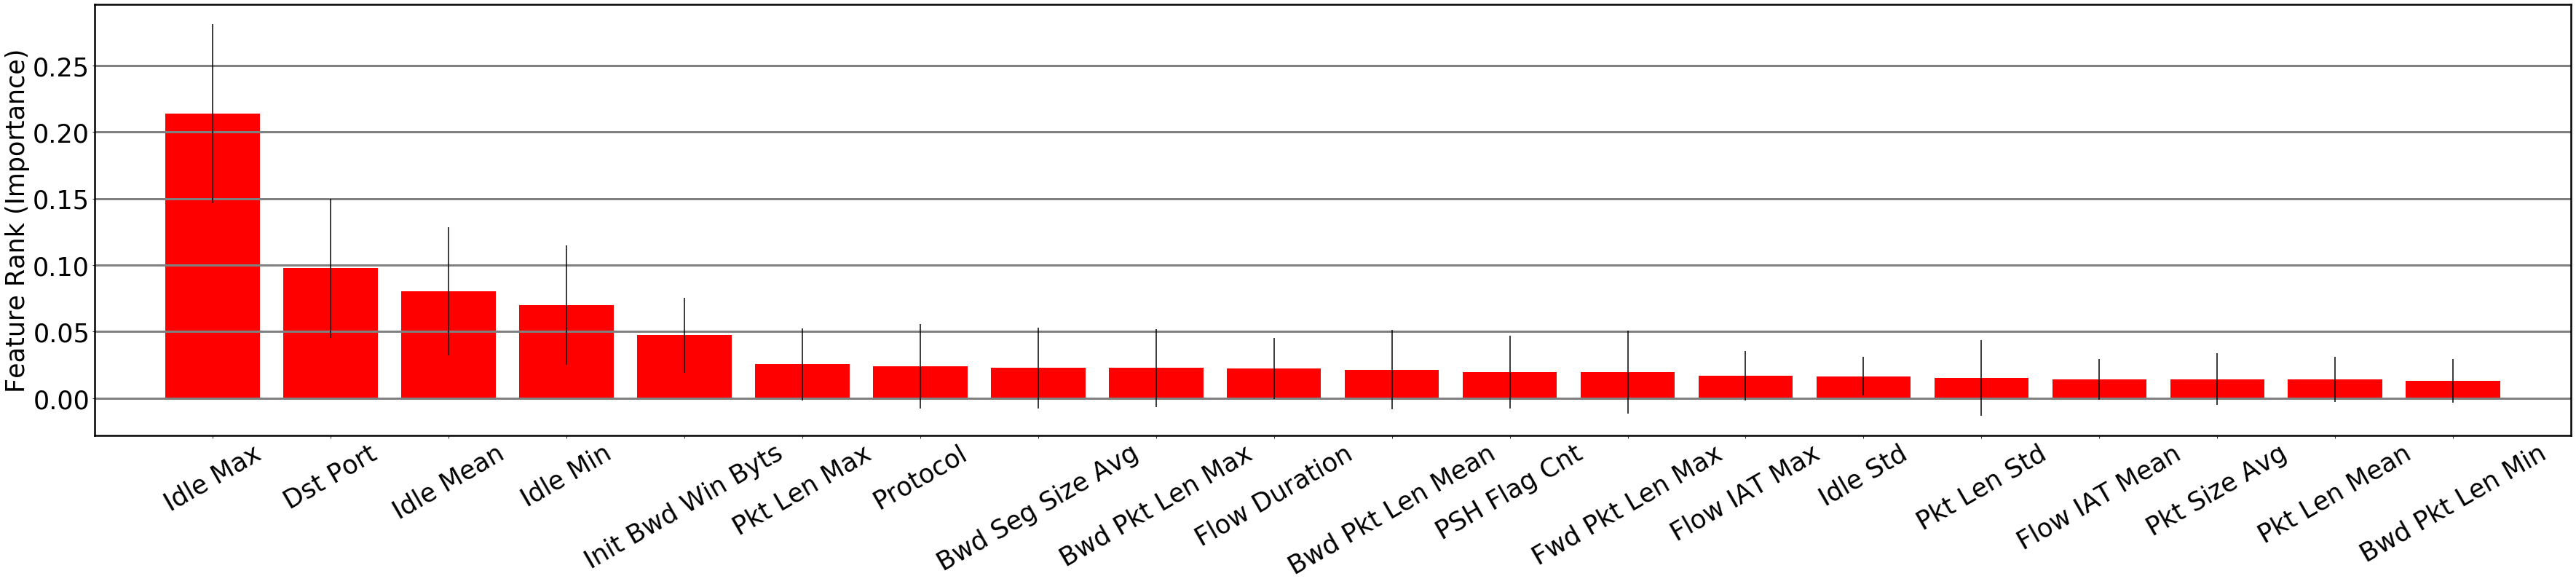

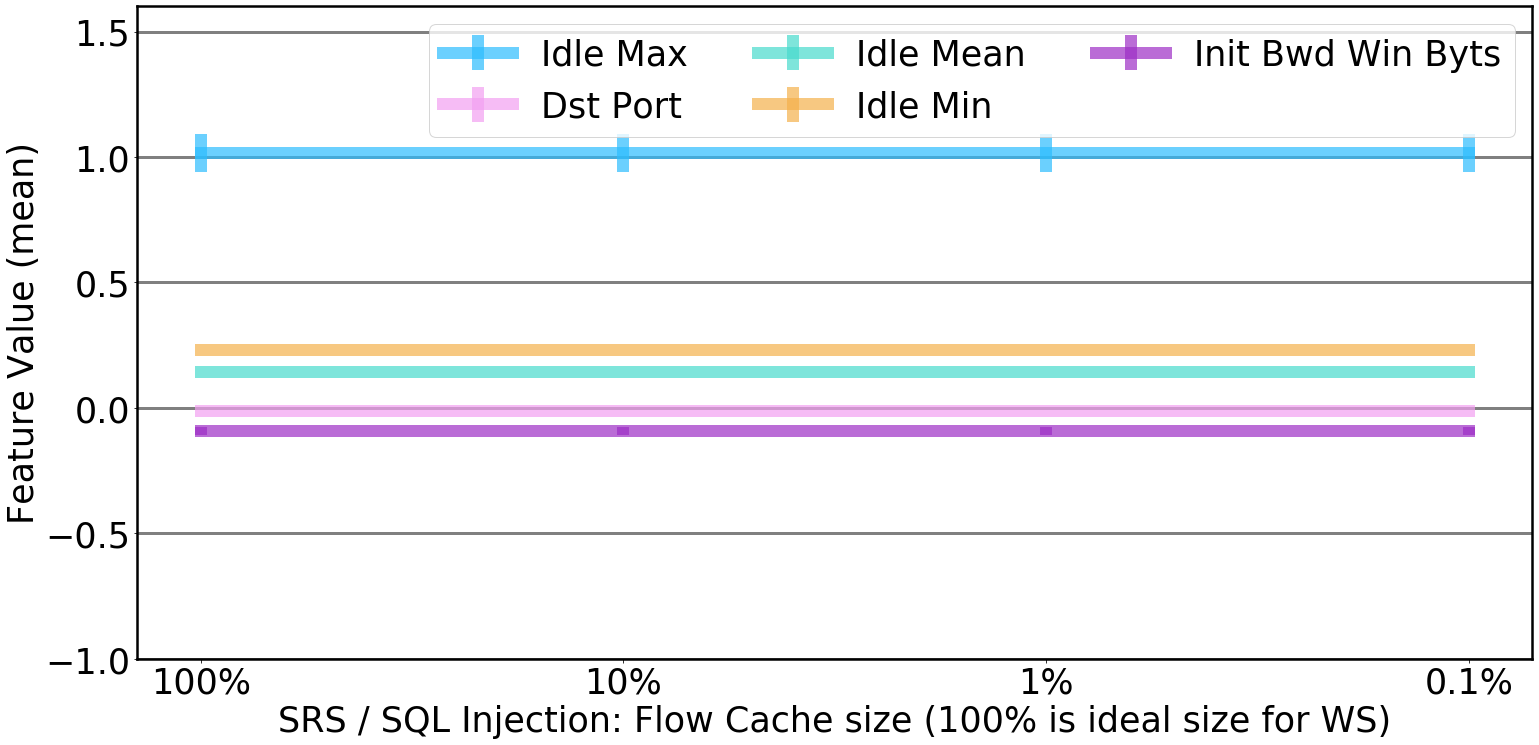

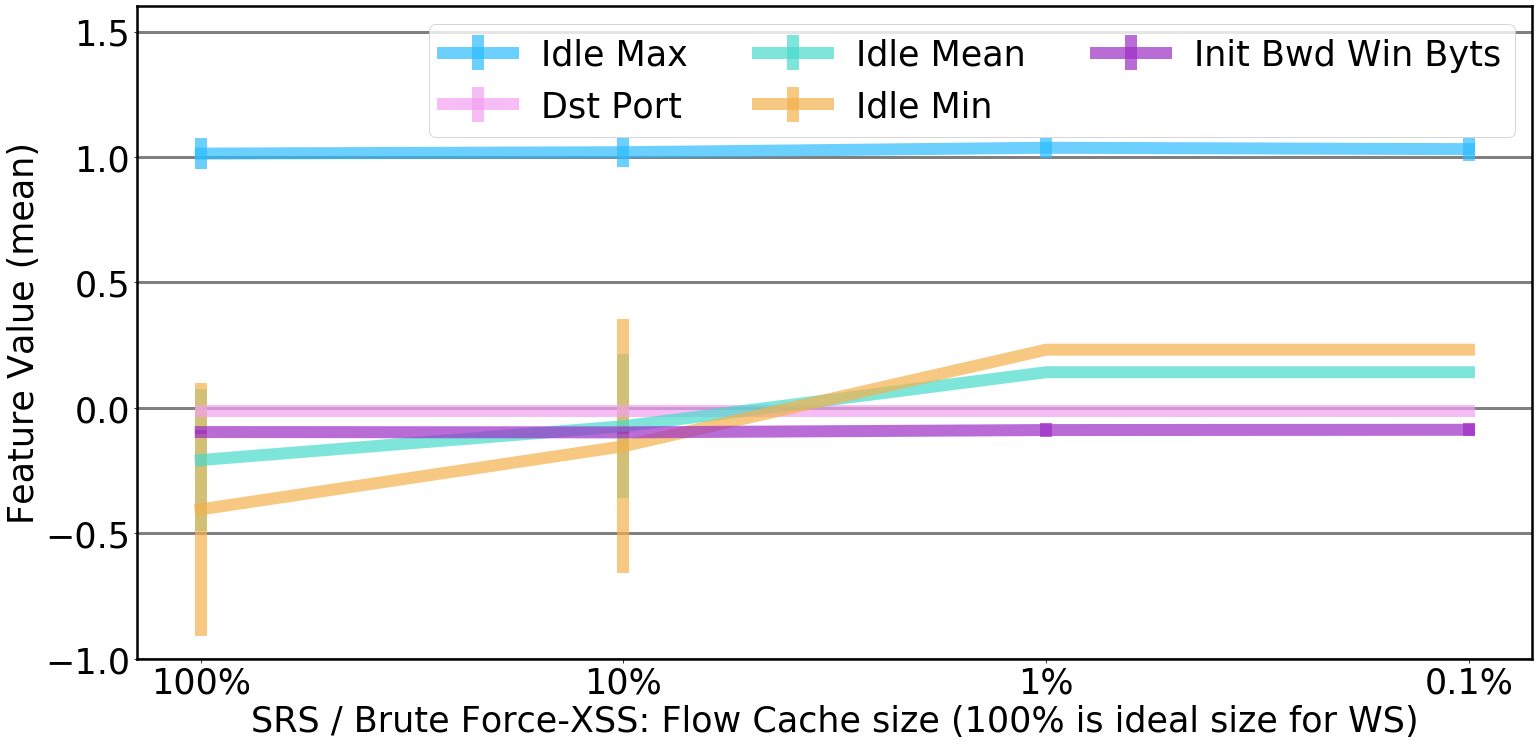

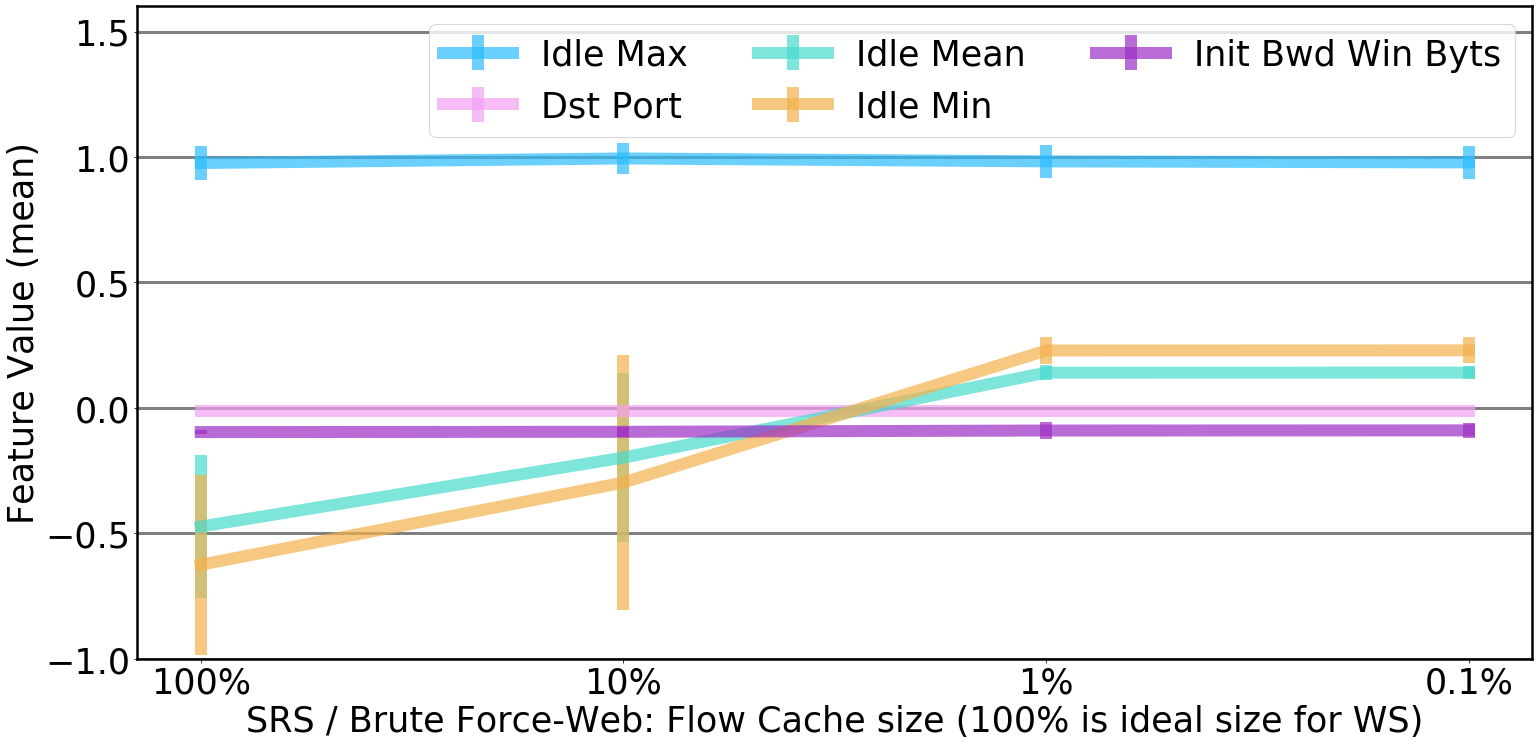

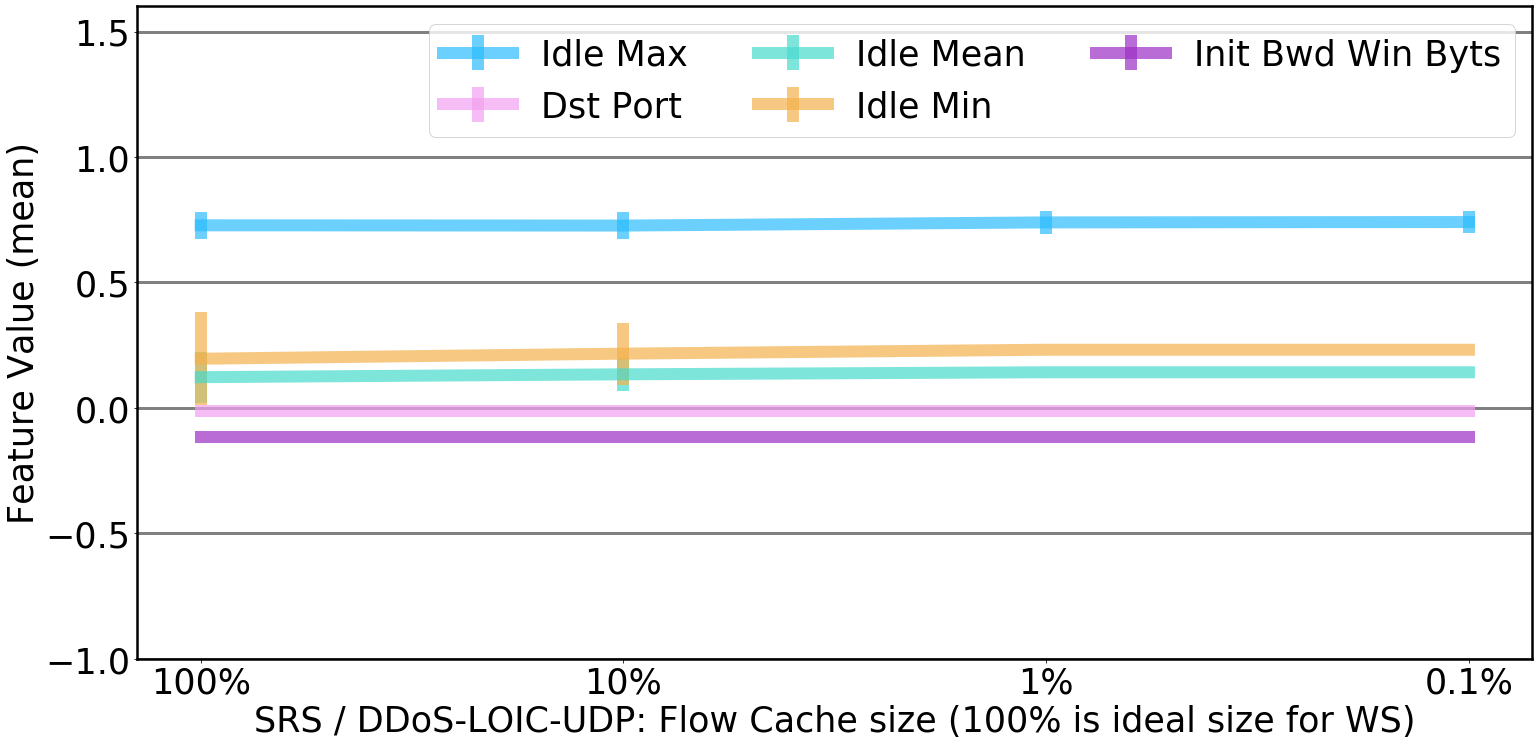

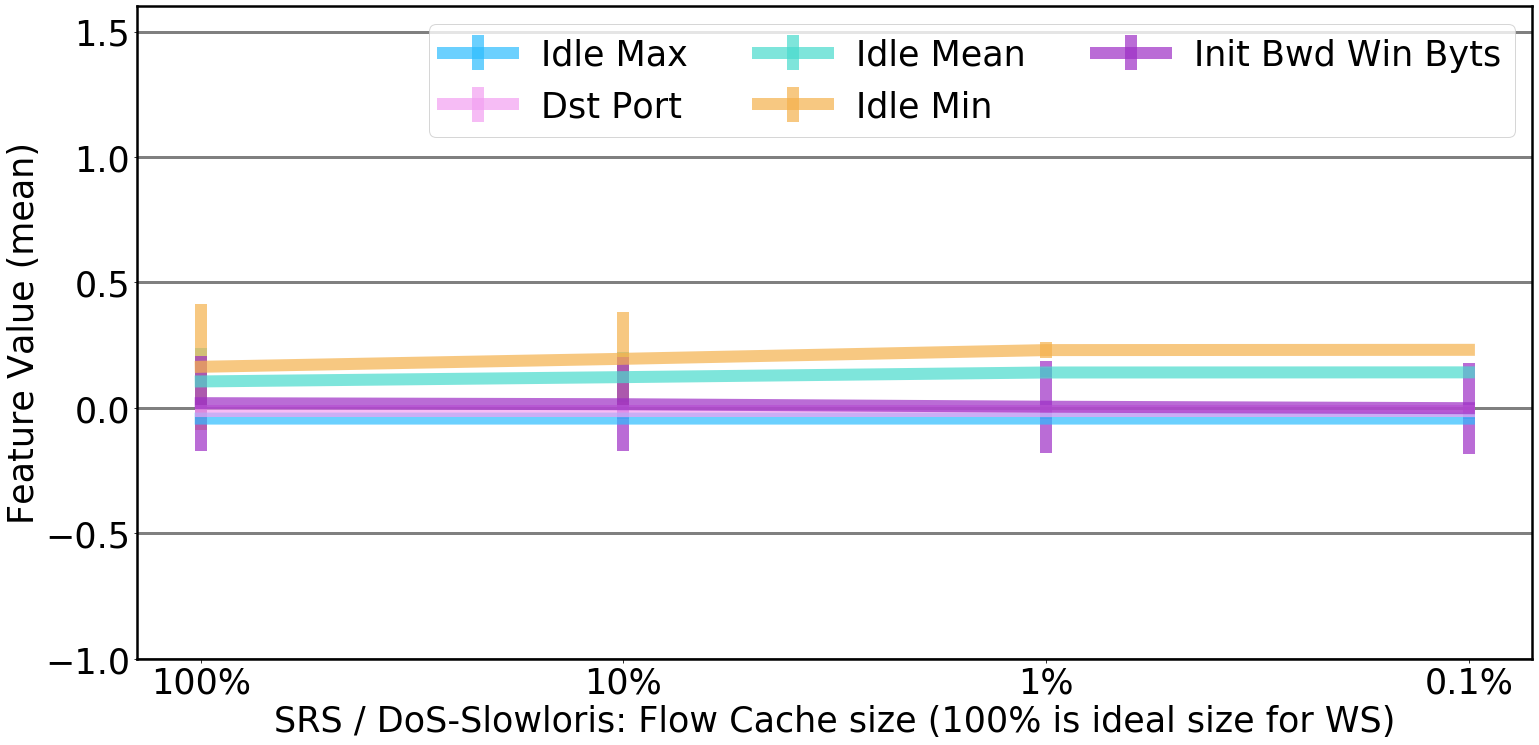

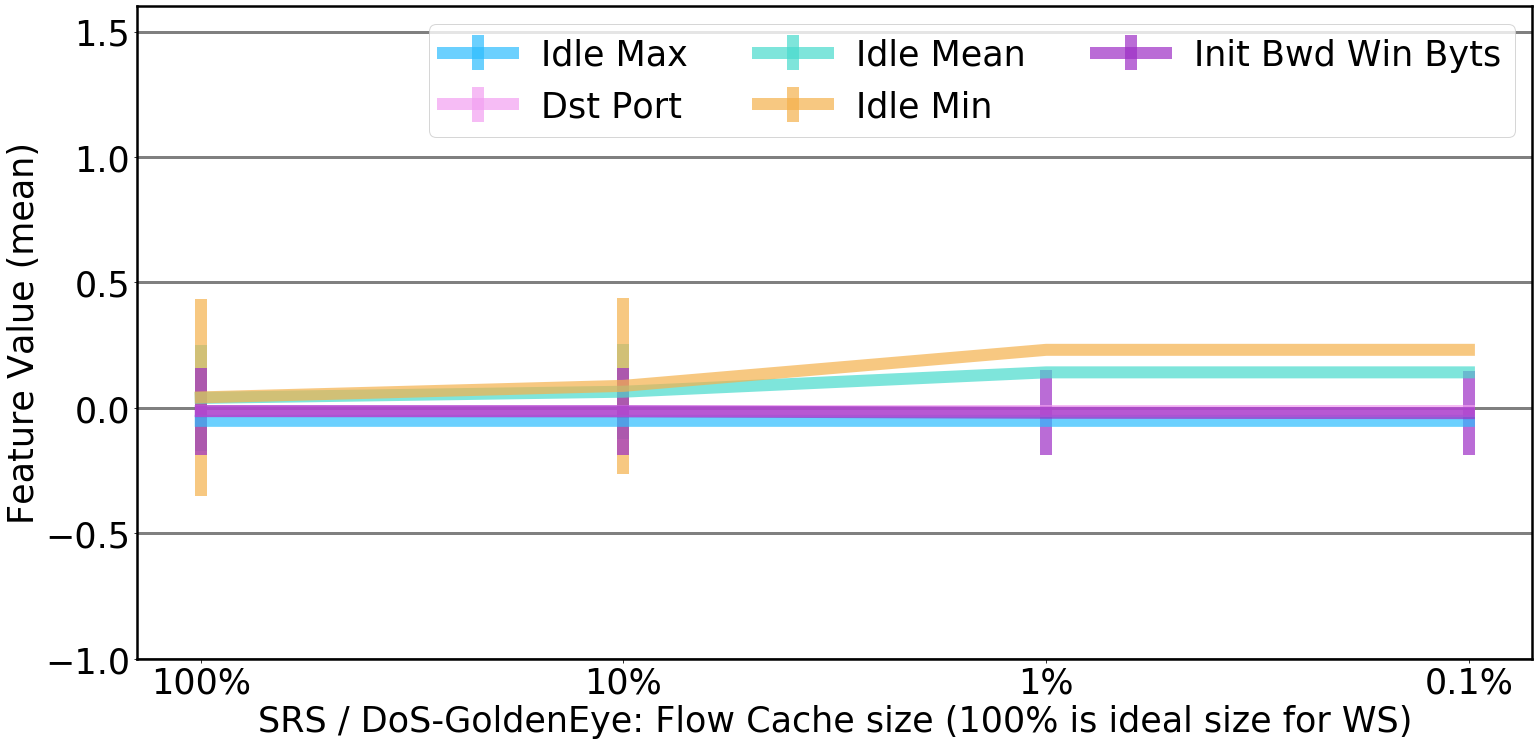

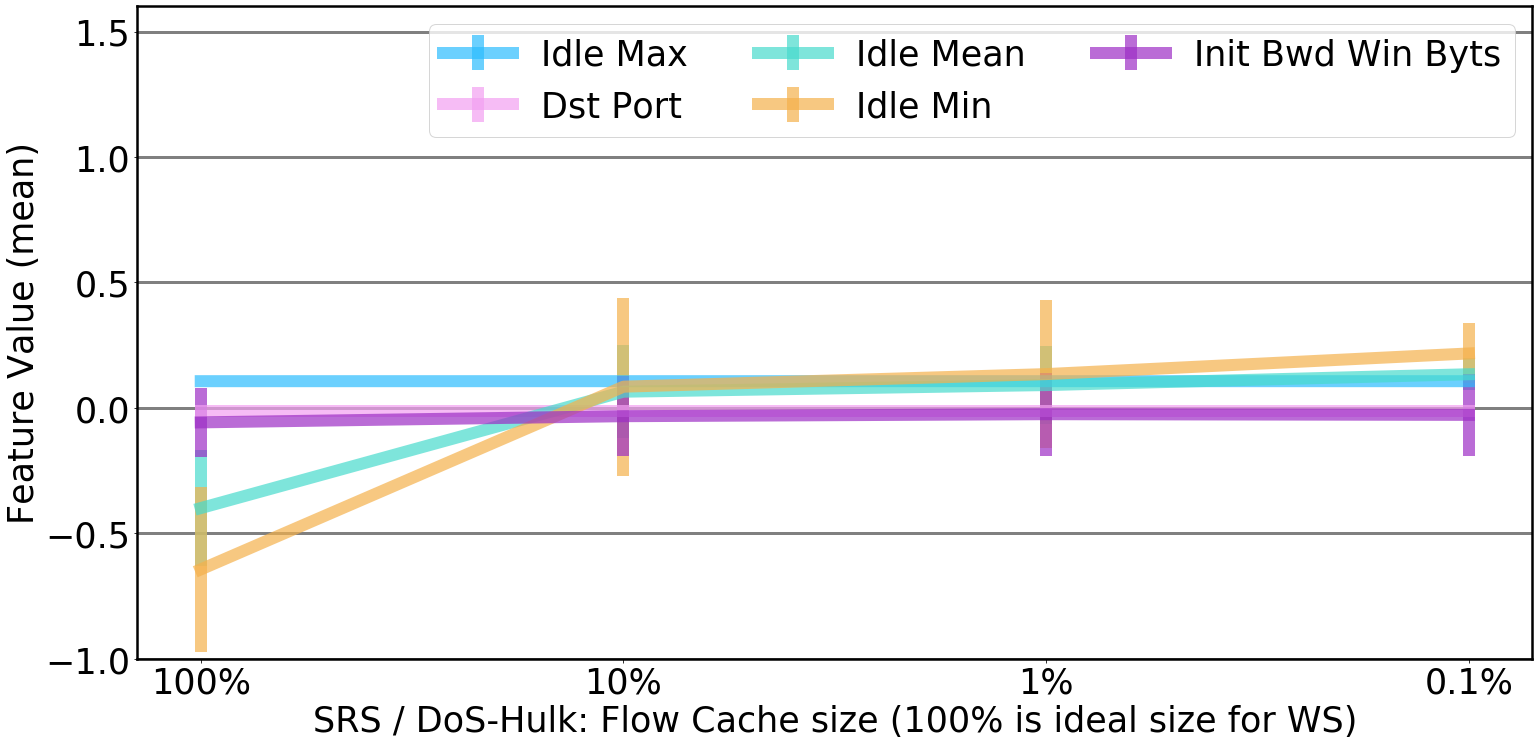

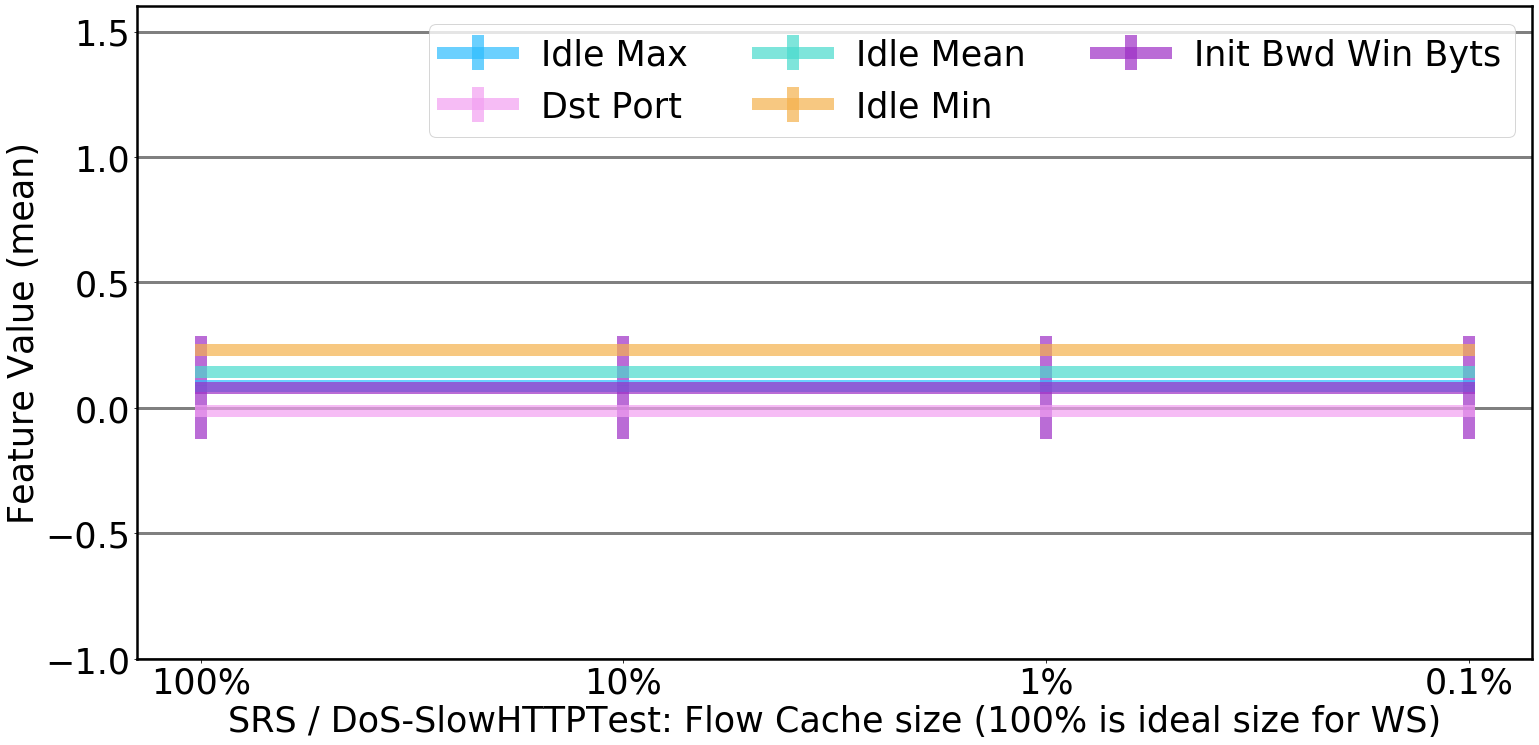

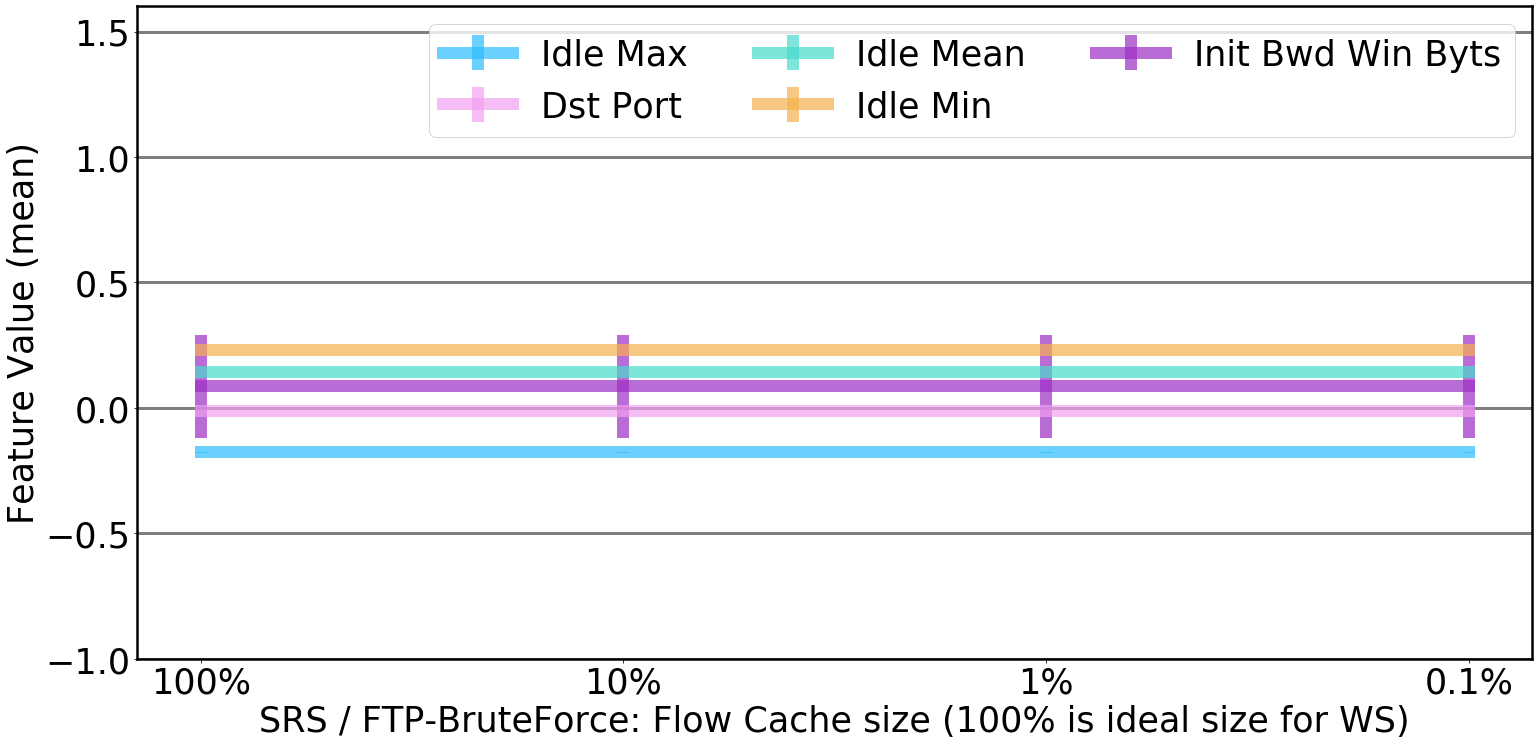

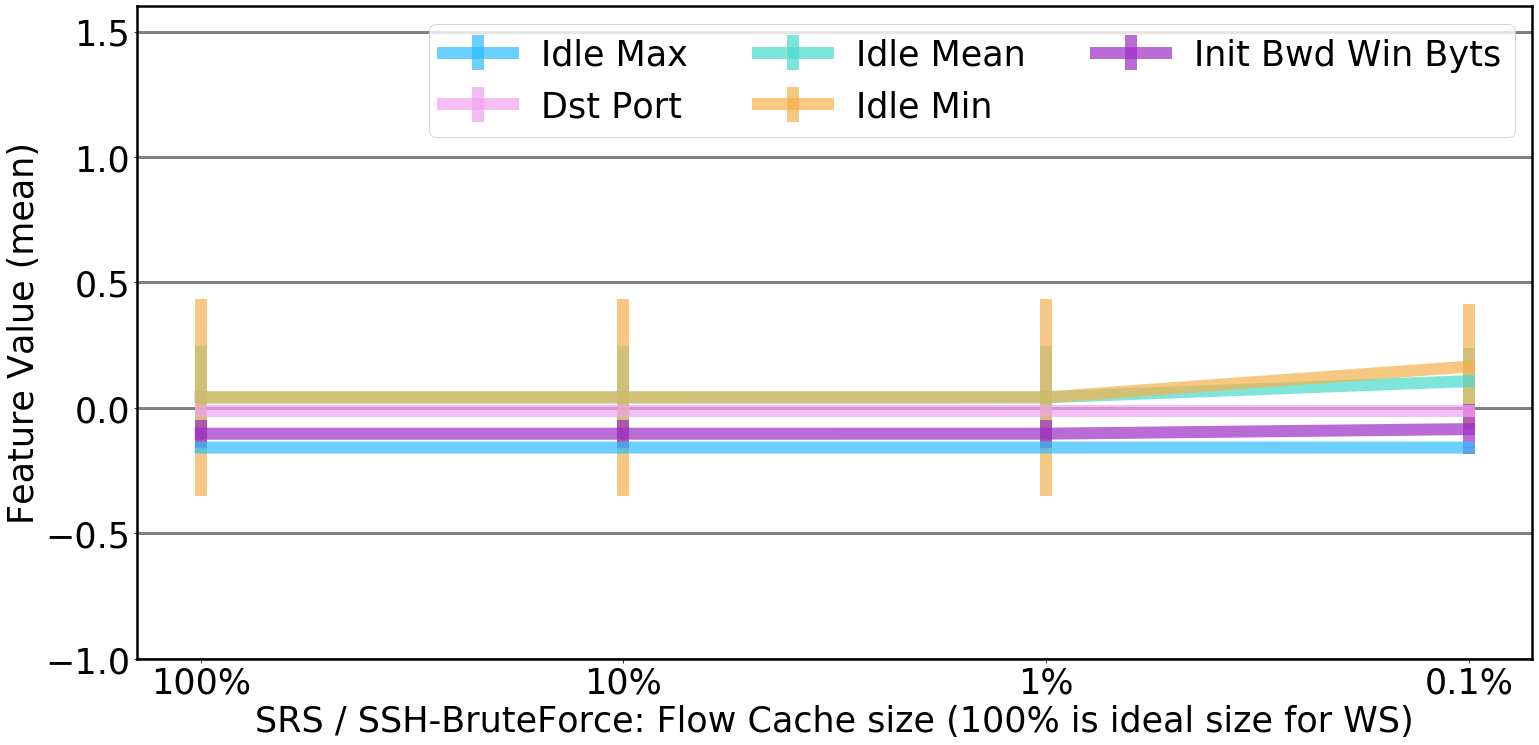

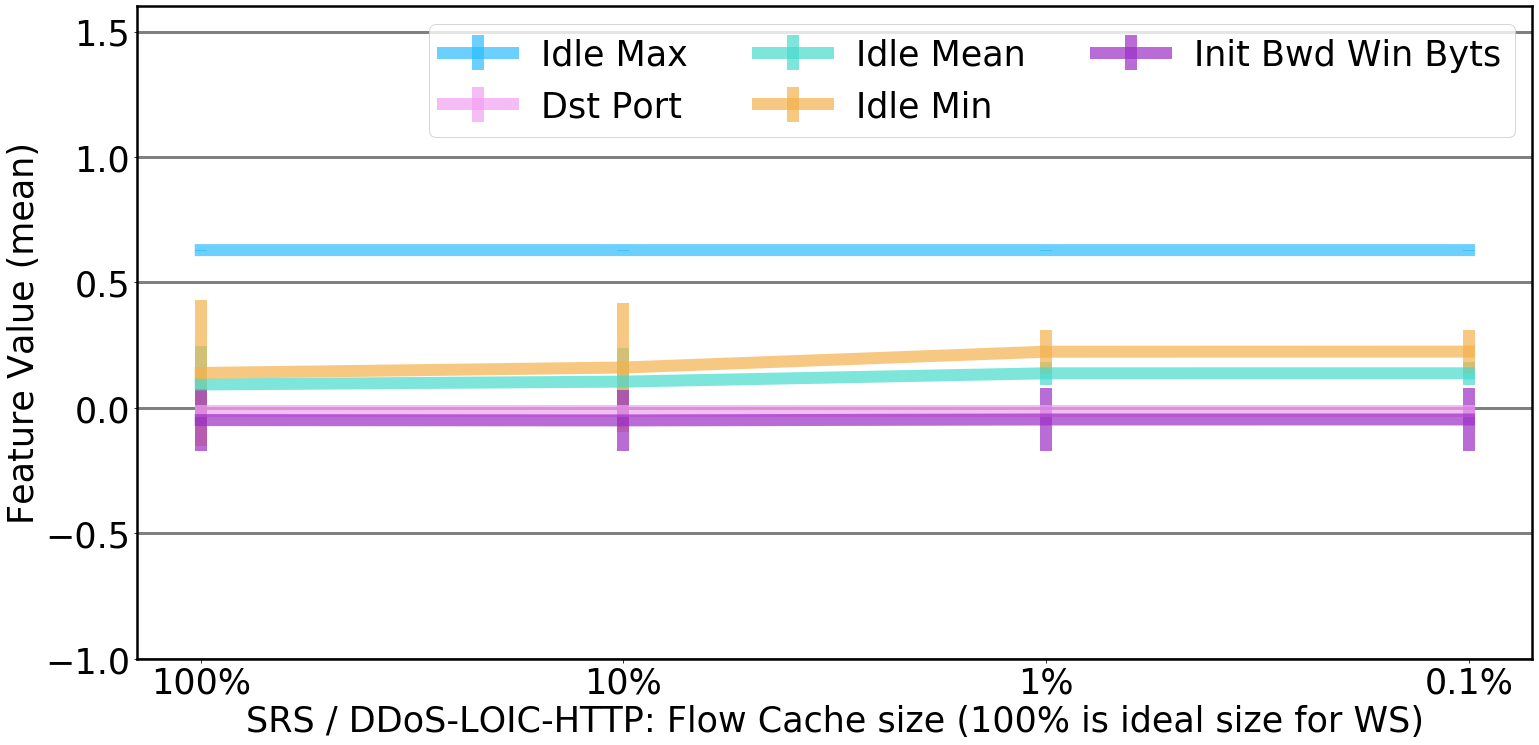

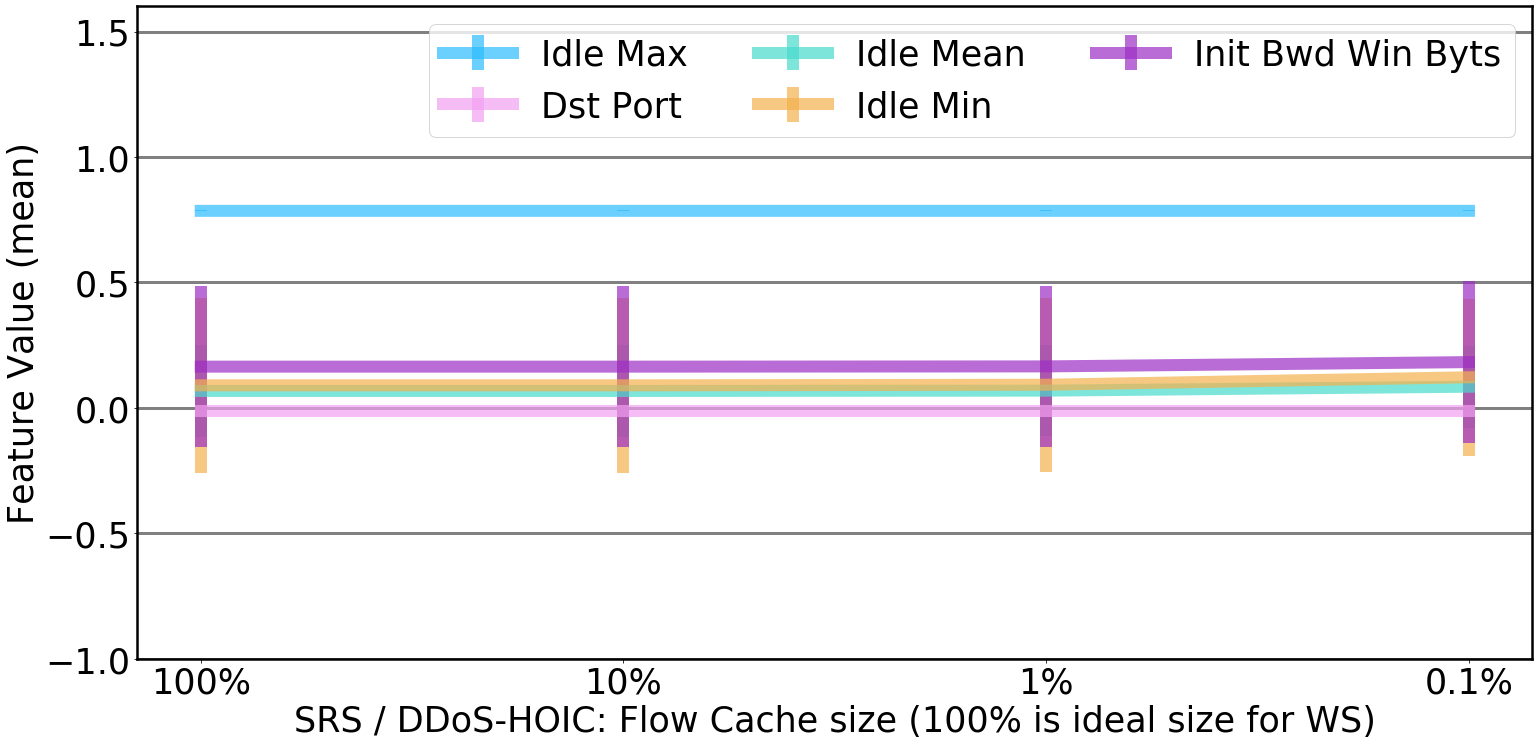

In [24]:
sr_dir = 'SR_10.0'
root = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/{}/'.format(sr_dir) 

for i,sampler_dir in enumerate(sorted(glob(join(root,'*_l')))):
    if 'SRS' in sampler_dir:
        plot_feature_trend_for_sampler(sampler_dir)    